# Advanced analysis

Após ter uma ideia inicial sobre os dados a partir das análises iniciais iremos nos aprofundar em alguns aspectos que aparentam ser importantes.

## 1. Leitura dos dados

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#Estilo ggplot
plt.style.use('ggplot')

In [2]:
#Setando diretorio Data como o atual
os.chdir('../Data')

#Leitura dos dados
df_parkinson = pd.read_csv('parkinson_v1.csv',index_col='name')

In [3]:
'''Plota varios boxplot definido por x e cols'''
def boxplot(df,cols,x):
    
    #Iremos plotar 3 graficos por linhas
    ncol = 3
    
    #Numero de linhas é calculado automaticamente
    nrow = int(len(cols)/3)+1
    
    fig = plt.figure(figsize=(15,15))
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    for index,c in enumerate(cols):
        ax = fig.add_subplot(nrow,ncol,index+1)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        sns.boxplot(data=df,x=x,y=c)
    plt.show()
    
'''Plota um pairplot customizado'''
def pairplot(df,col_plot,hue):
    
    #Pairplot
    g = sns.pairplot(data=df,hue=hue,vars=col_plot)

    #Quantidade de colunas para plotar
    n = len(col_plot)
    
    #Customizando figura
    for index in range(n):
        
        #Muda o tamanho de xticklabels 
        for tick_x in g.axes[n-1][index].get_xticklabels():
            tick_x.set_fontsize(13)

        #Muda o tamanho de yticklabels
        for tick_y in g.axes[index][0].get_yticklabels():
            tick_y.set_fontsize(13)

        #Muda o tamanho de xlabel/ylabel
        g.axes[n-1][index].xaxis.label.set_size(15)
        g.axes[index][0].yaxis.label.set_size(15)

    #Muda tamanho das legendas
    g.fig.get_children()[-1].properties()['title'].set_fontsize(15)
    g.fig.get_children()[-1].prop.set_size(15)
    plt.show()

# 2. Análises

## 2.1 Criação de novas métricas

Criação de novas atributos seguindo a fórmula wpsf = psp * pspf e análises sobre o mesmo.

In [4]:
#Criando novos atributos
df_parkinson['wpsf2'] = df_parkinson['psp2'] * df_parkinson['pspf2']
df_parkinson['wpsf3'] = df_parkinson['psp3'] * df_parkinson['pspf3']

#Arrumando coluna
df_parkinson.rename(columns={'wpsf':'wpsf1'},inplace=True)

#Mudando posicao das colunas
new_cols = np.concatenate((df_parkinson.drop(columns='evaluate').select_dtypes(['int','float']).columns.values,['evaluate'],df_parkinson.select_dtypes('object').columns.values))
df_parkinson = df_parkinson.loc[:,new_cols]

#Nome das colunas numericas
numeric_cols = df_parkinson.columns[0:-3].values

#Aplicação da boxcox para tentar normalizar os dados - ajuda na visualização
for col in numeric_cols:
    df_parkinson.loc[:,col],_ = boxcox(df_parkinson[col])
    
#Copiando dados
df_StandardScaler = df_parkinson.copy()
df_MinMaxScaler = df_parkinson.copy()

#Normalizacao dos dados - media 0 e desvio padrao 1
df_StandardScaler.loc[:,numeric_cols] = StandardScaler().fit_transform(df_StandardScaler.loc[:,numeric_cols])

#Normalizacao dos dados - min 0 e max 1
df_MinMaxScaler.loc[:,numeric_cols] = MinMaxScaler().fit_transform(df_MinMaxScaler.loc[:,numeric_cols])

#Salvando dados
df_StandardScaler.to_csv('parkinson_normalizado_ss.csv',index=False)
df_MinMaxScaler.to_csv('parkinson_normalizado_mm.csv',index=False)

#Analises com normalizacao 1
# df_parkinson = df_StandardScaler.copy()

#Analises com normalizacao 2
df_parkinson = df_MinMaxScaler.copy()

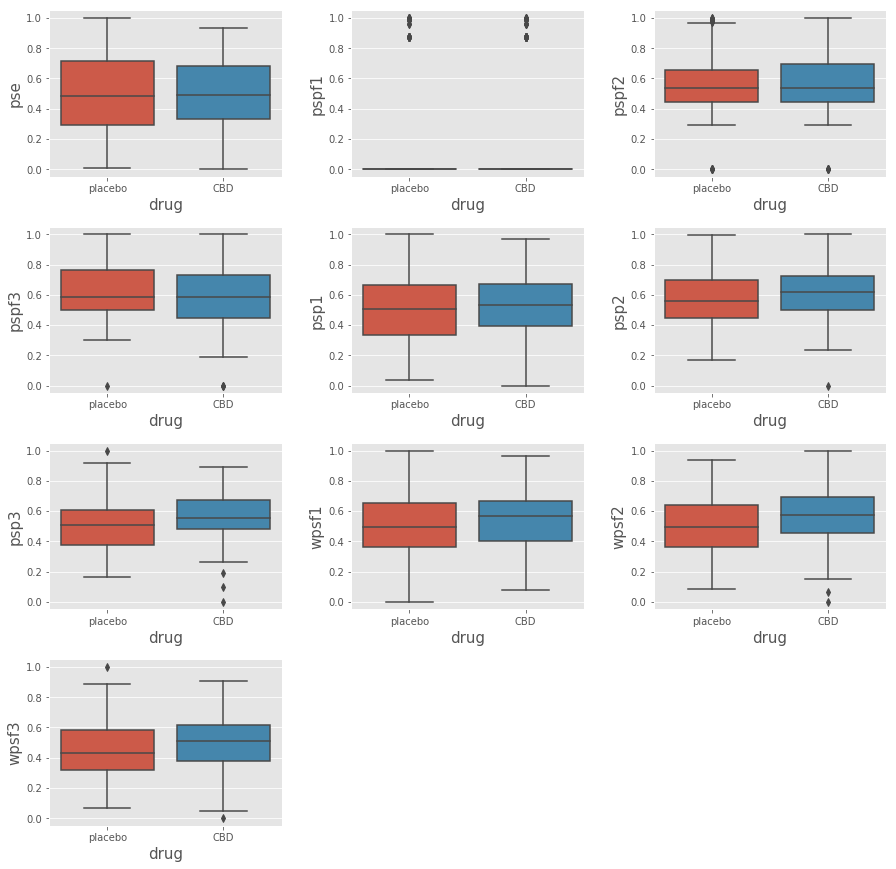

In [5]:
#Boxplot divido por droga
boxplot(df_parkinson,numeric_cols,'drug')

In [6]:
#ANOVA
_,pvalue = f_oneway(df_parkinson.loc[df_parkinson['drug'] == 'placebo',['wpsf2','wpsf3']],df_parkinson.loc[df_parkinson['drug'] == 'CBD',['wpsf2','wpsf3']])
pvalue

array([0.01092704, 0.0201824 ])

Apesar de não ser tão aparente no boxplot o ANOVA indica que há diferenças significativas entre os grupos para as novas métricas.

## 2.2 Separando dataset em avaliação 1 e 2

In [7]:
#Divindo dados
df_evaluate1 = df_parkinson.loc[df_parkinson['evaluate'] == 1]
df_evaluate2 = df_parkinson.loc[df_parkinson['evaluate'] == 2]

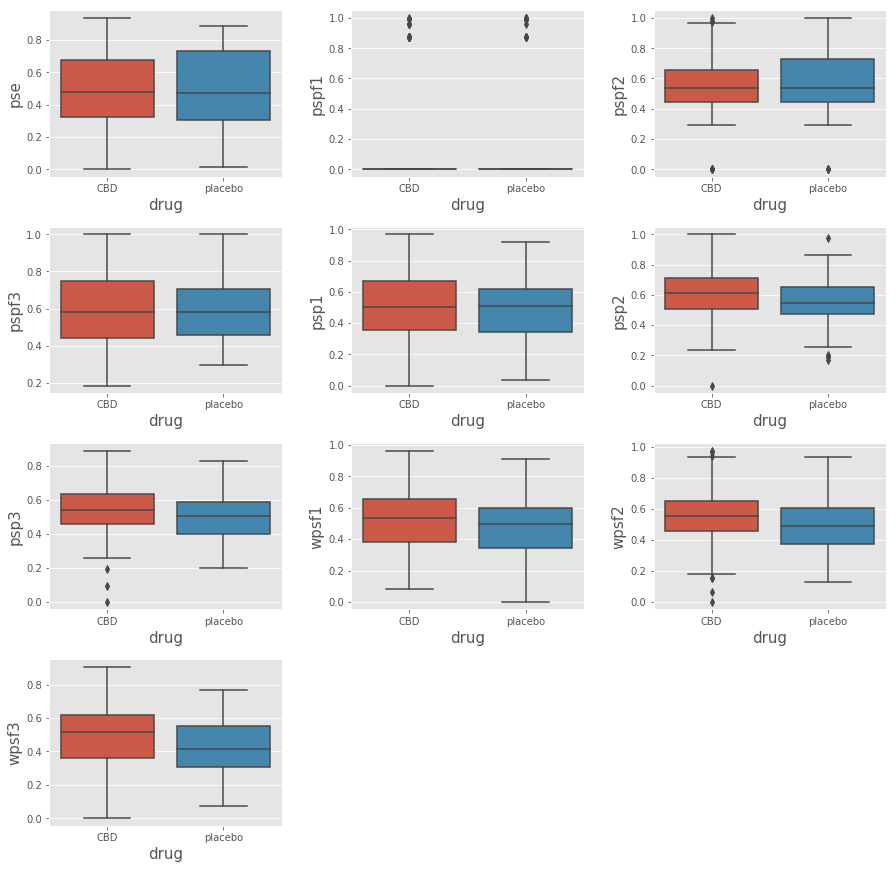

{'pse': 0.9274064140184914, 'pspf1': 0.31280237733967553, 'pspf2': 0.5884907089137863, 'pspf3': 0.5417618102424482, 'psp1': 0.2632045069467537, 'psp2': 0.05208315698557737, 'psp3': 0.027923249967055953, 'wpsf1': 0.17251787743408947, 'wpsf2': 0.09587964705516282, 'wpsf3': 0.009281801426290344}


In [8]:
#Boxplot
boxplot(df_evaluate1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_evaluate1.loc[df_evaluate1['drug'] == 'placebo',numeric_cols],df_evaluate1.loc[df_evaluate1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

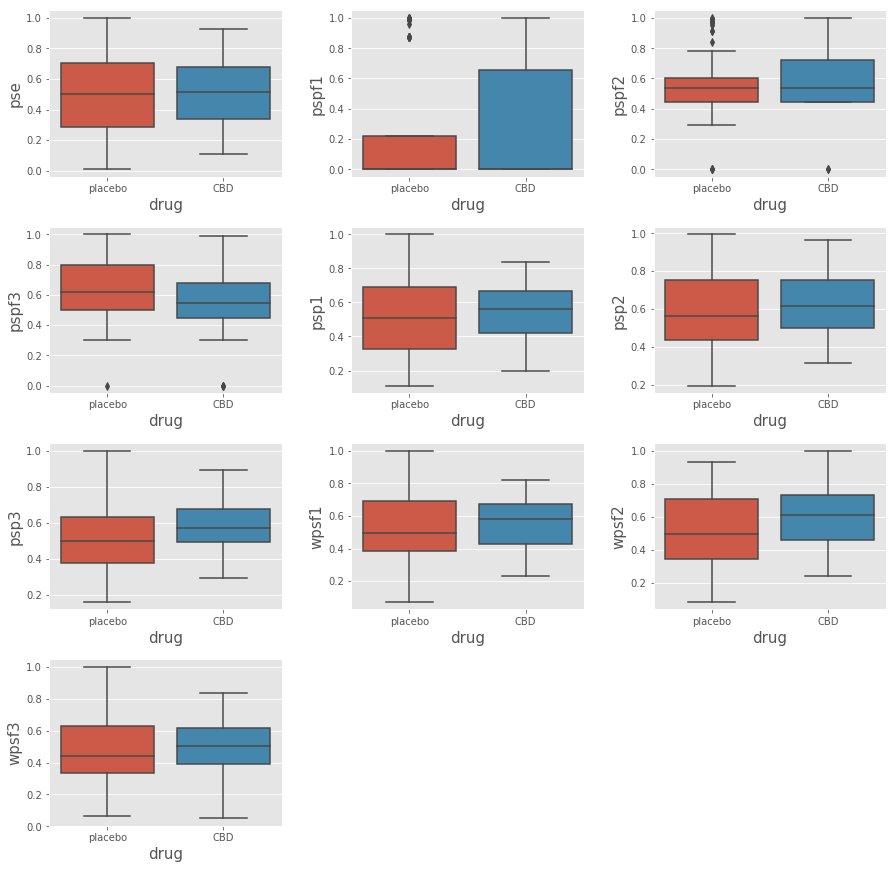

{'pse': 0.6561058914784985, 'pspf1': 0.9438395189904487, 'pspf2': 0.24323779980239582, 'pspf3': 0.013777748190479167, 'psp1': 0.29205802364457806, 'psp2': 0.121923982793473, 'psp3': 0.005178527362403207, 'wpsf1': 0.25443517585954917, 'wpsf2': 0.03634642028683096, 'wpsf3': 0.34539345940298816}


In [9]:
#Boxplot
boxplot(df_evaluate2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_evaluate2.loc[df_evaluate2['drug'] == 'placebo',numeric_cols],df_evaluate2.loc[df_evaluate2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

Interessanter notar que há diferenças no tipo de avaliação. Seria bom considerar alguma variável que indicasse isso.

## 2.3 Separando dataset em avaliação 1 e 2 e avaliando nas medidas - Boxplot

### 2.3.1 Avaliação 1

In [10]:
#Dividindo dataset por medida
df_measureB = df_evaluate1[df_evaluate1['measure'] == 'B'].drop(columns=['measure','evaluate'])
df_measureP = df_evaluate1[df_evaluate1['measure'] == 'P'].drop(columns=['measure','evaluate'])
df_measureA = df_evaluate1[df_evaluate1['measure'] == 'A'].drop(columns=['measure','evaluate'])
df_measureS1 = df_evaluate1[df_evaluate1['measure'] == 'S1'].drop(columns=['measure','evaluate'])
df_measureS2 = df_evaluate1[df_evaluate1['measure'] == 'S2'].drop(columns=['measure','evaluate'])
df_measureF1 = df_evaluate1[df_evaluate1['measure'] == 'F1'].drop(columns=['measure','evaluate'])
df_measureF2 = df_evaluate1[df_evaluate1['measure'] == 'F2'].drop(columns=['measure','evaluate'])

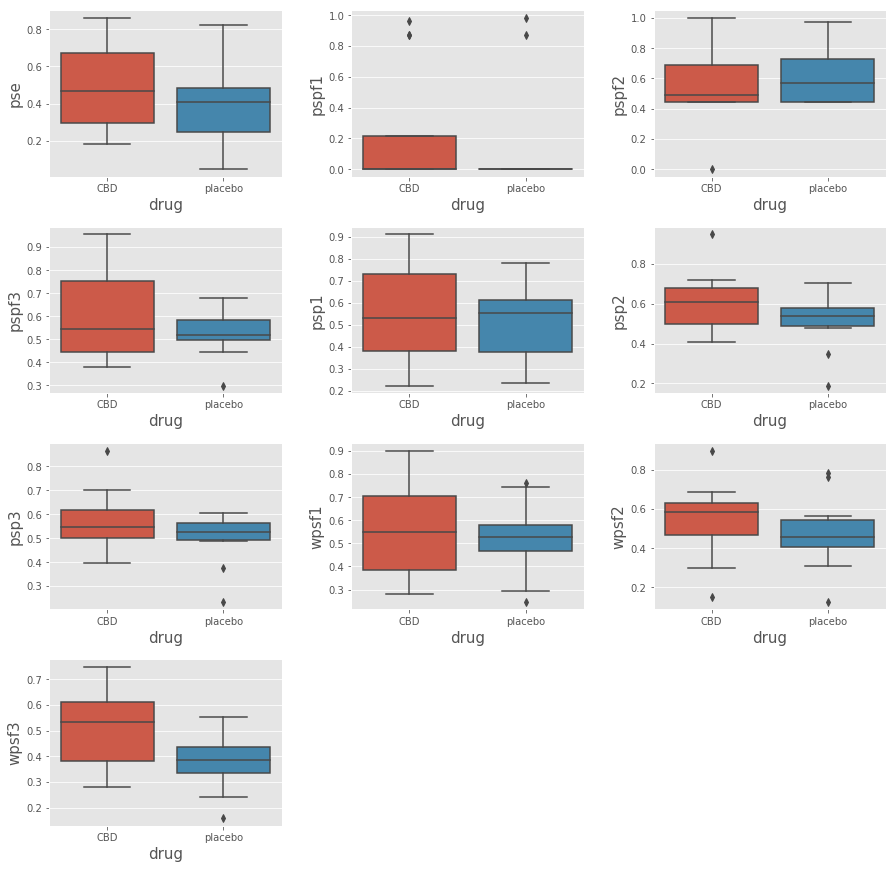

{'pse': 0.46077011346131747, 'pspf1': 0.8187893108012131, 'pspf2': 0.5227681535731366, 'pspf3': 0.1893016933719997, 'psp1': 0.7749780185060964, 'psp2': 0.15420714064070026, 'psp3': 0.16092387537428904, 'wpsf1': 0.7342794405128625, 'wpsf2': 0.38947306613119304, 'wpsf3': 0.03815963322345719}


In [11]:
#Boxplot - medida B
boxplot(df_measureB,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureB.loc[df_measureB['drug'] == 'placebo',numeric_cols],df_measureB.loc[df_measureB['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

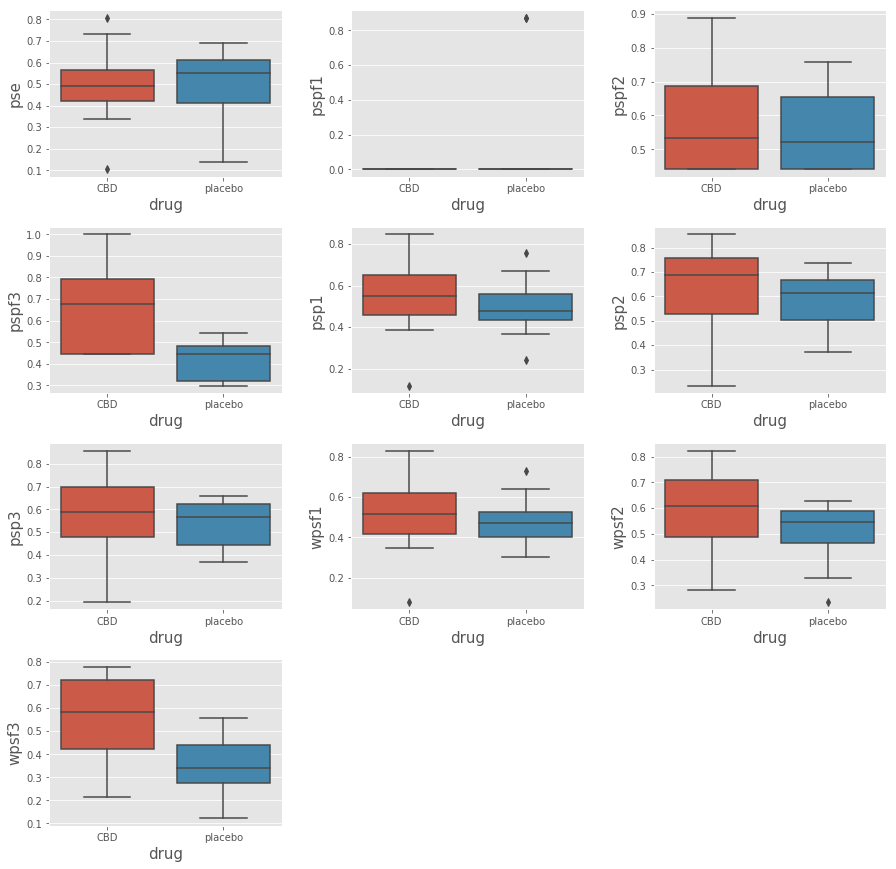

{'pse': 0.9914586322840607, 'pspf1': 0.11426288841575143, 'pspf2': 0.6732926947943789, 'pspf3': 0.002015159038266002, 'psp1': 0.5111186145147042, 'psp2': 0.5608312094198808, 'psp3': 0.5163536771494954, 'wpsf1': 0.6677779767814438, 'wpsf2': 0.26333445957989127, 'wpsf3': 0.00662858577078918}


In [12]:
#Boxplot - medida P
boxplot(df_measureP,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureP.loc[df_measureP['drug'] == 'placebo',numeric_cols],df_measureP.loc[df_measureP['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

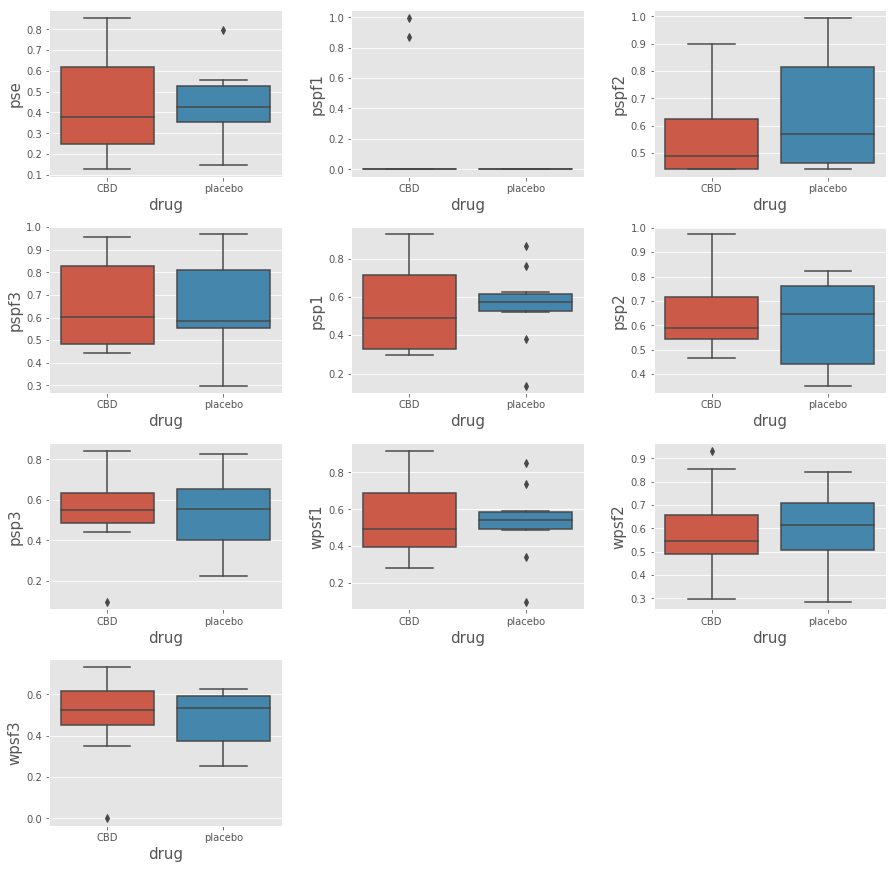

{'pse': 0.9474452158323261, 'pspf1': 0.19372107628656318, 'pspf2': 0.2544815297132204, 'pspf3': 0.8747064356353362, 'psp1': 0.9548617283203179, 'psp2': 0.5598717545954284, 'psp3': 0.94463245402557, 'wpsf1': 0.782792419690007, 'wpsf2': 0.7768566984667421, 'wpsf3': 0.7912278510445095}


In [13]:
#Boxplot - medida A
boxplot(df_measureA,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureA.loc[df_measureA['drug'] == 'placebo',numeric_cols],df_measureA.loc[df_measureA['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

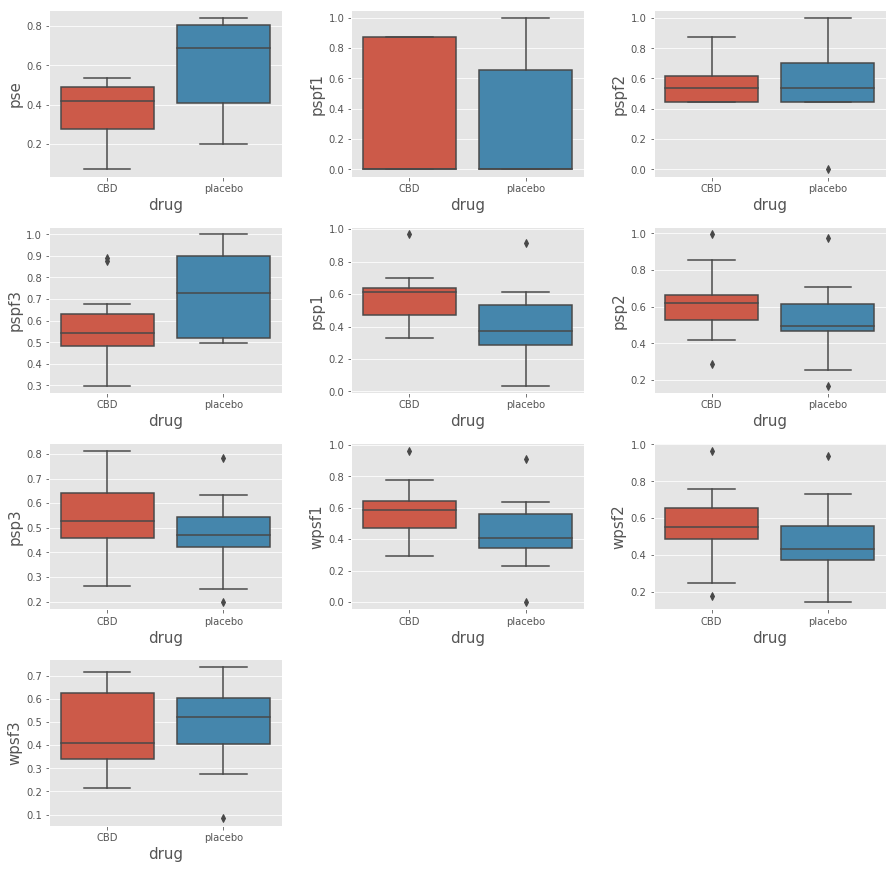

{'pse': 0.016828227657952534, 'pspf1': 0.9312658764833145, 'pspf2': 0.9591295160686147, 'pspf3': 0.07321213163561825, 'psp1': 0.07477855837199797, 'psp2': 0.31727584097444794, 'psp3': 0.3410095566507406, 'wpsf1': 0.1218583537897584, 'wpsf2': 0.39136585006512004, 'wpsf3': 0.8299528527739346}


In [14]:
#Boxplot - medida S1
boxplot(df_measureS1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS1.loc[df_measureS1['drug'] == 'placebo',numeric_cols],df_measureS1.loc[df_measureS1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

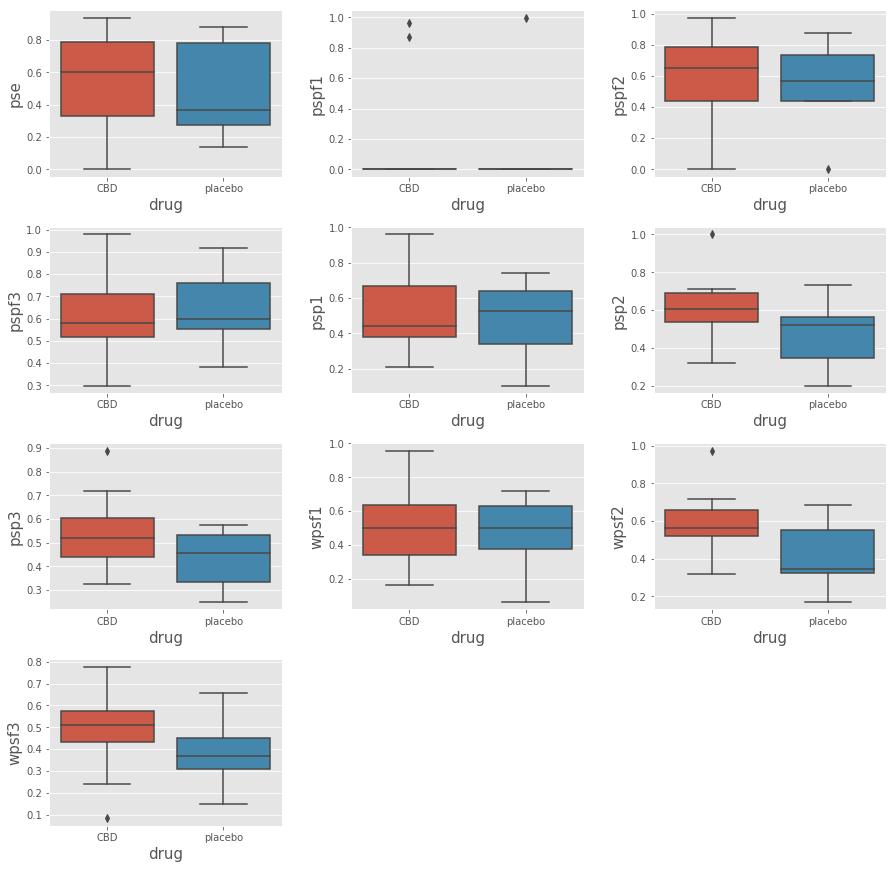

{'pse': 0.6514493590958375, 'pspf1': 0.7185744237716667, 'pspf2': 0.5910348959507246, 'pspf3': 0.8499830871405464, 'psp1': 0.6558204628042603, 'psp2': 0.13251399760649574, 'psp3': 0.07728192164812685, 'wpsf1': 0.7007499040476525, 'wpsf2': 0.02242932361891334, 'wpsf3': 0.14247063505702234}


In [15]:
#Boxplot - medida S2
boxplot(df_measureS2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS2.loc[df_measureS2['drug'] == 'placebo',numeric_cols],df_measureS2.loc[df_measureS2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

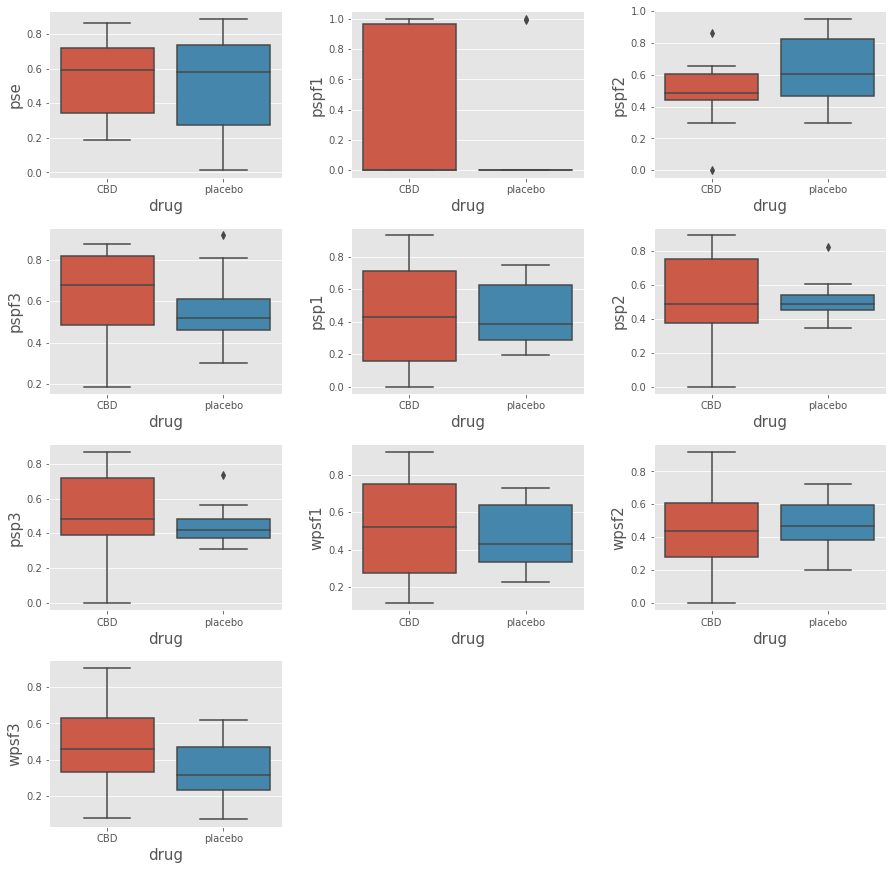

{'pse': 0.7740870079571577, 'pspf1': 0.32086246078811714, 'pspf2': 0.1367749381824308, 'pspf3': 0.45089962205781575, 'psp1': 0.9642029769239322, 'psp2': 0.8466468206330928, 'psp3': 0.4589103157306932, 'wpsf1': 0.6774938561648957, 'wpsf2': 0.594926836332148, 'wpsf3': 0.21039769629789484}


In [16]:
#Boxplot - medida F1
boxplot(df_measureF1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF1.loc[df_measureF1['drug'] == 'placebo',numeric_cols],df_measureF1.loc[df_measureF1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

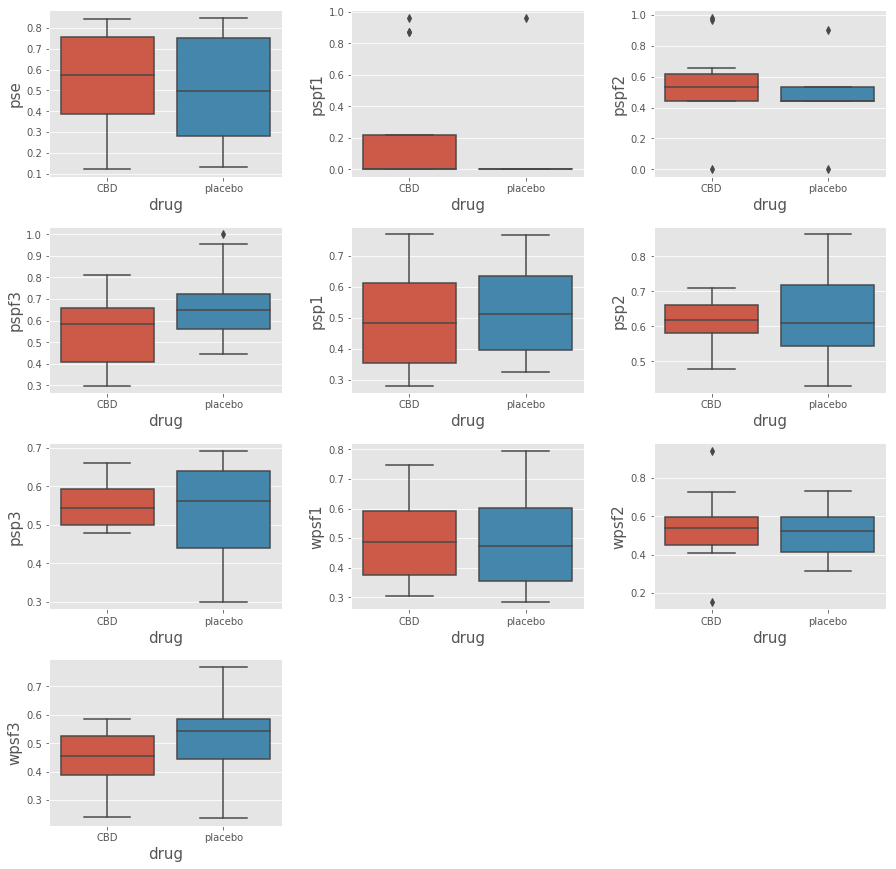

{'pse': 0.7767355470624805, 'pspf1': 0.4181380227068484, 'pspf2': 0.46350109006475027, 'pspf3': 0.10942666529320935, 'psp1': 0.7999165735768134, 'psp2': 0.575789773185299, 'psp3': 0.7351537654582383, 'wpsf1': 0.9537685449013338, 'wpsf2': 0.729900259464032, 'wpsf3': 0.24303836551000976}


In [17]:
#Boxplot - medida F2
boxplot(df_measureF2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF2.loc[df_measureF2['drug'] == 'placebo',numeric_cols],df_measureF2.loc[df_measureF2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

### 2.3.2 Avaliação 2

In [18]:
#Dividindo dataset por medida
df_measureB = df_evaluate2[df_evaluate2['measure'] == 'B'].drop(columns=['measure','evaluate'])
df_measureP = df_evaluate2[df_evaluate2['measure'] == 'P'].drop(columns=['measure','evaluate'])
df_measureA = df_evaluate2[df_evaluate2['measure'] == 'A'].drop(columns=['measure','evaluate'])
df_measureS1 = df_evaluate2[df_evaluate2['measure'] == 'S1'].drop(columns=['measure','evaluate'])
df_measureS2 = df_evaluate2[df_evaluate2['measure'] == 'S2'].drop(columns=['measure','evaluate'])
df_measureF1 = df_evaluate2[df_evaluate2['measure'] == 'F1'].drop(columns=['measure','evaluate'])
df_measureF2 = df_evaluate2[df_evaluate2['measure'] == 'F2'].drop(columns=['measure','evaluate'])

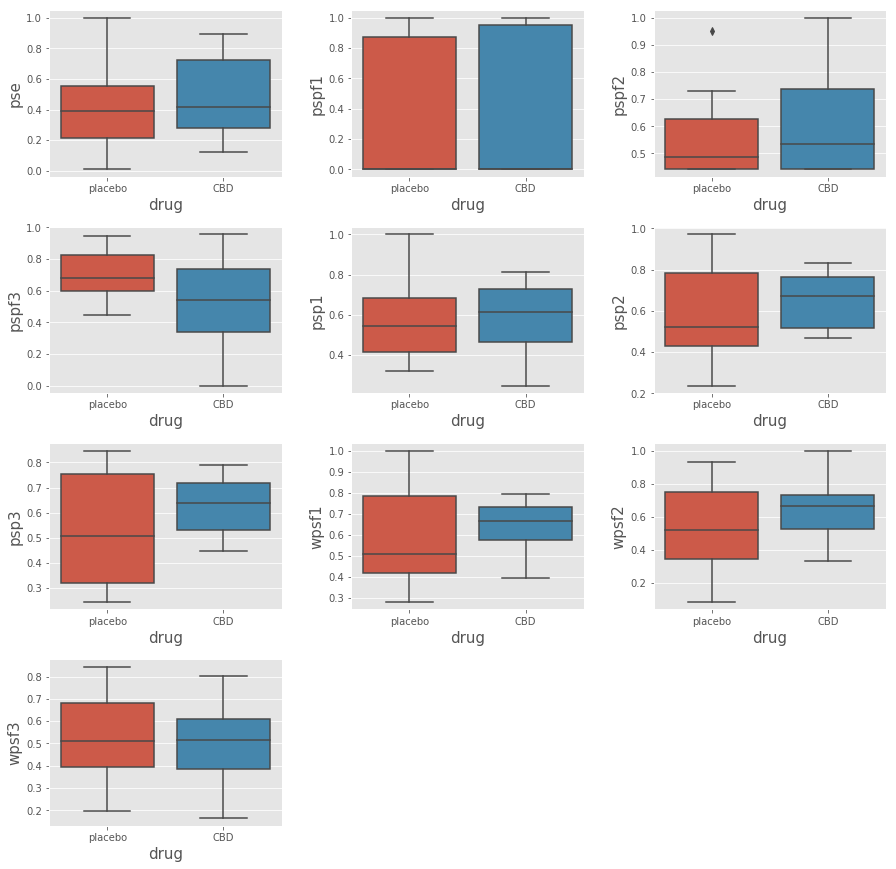

{'pse': 0.5044793103028459, 'pspf1': 0.6819218833538476, 'pspf2': 0.5373453883823693, 'pspf3': 0.08565783823187391, 'psp1': 0.9957422907015097, 'psp2': 0.5078815997435405, 'psp3': 0.2509670509069112, 'wpsf1': 0.6301157330936682, 'wpsf2': 0.3639060320303985, 'wpsf3': 0.7576077819562641}


In [19]:
#Boxplot - medida B
boxplot(df_measureB,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureB.loc[df_measureB['drug'] == 'placebo',numeric_cols],df_measureB.loc[df_measureB['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

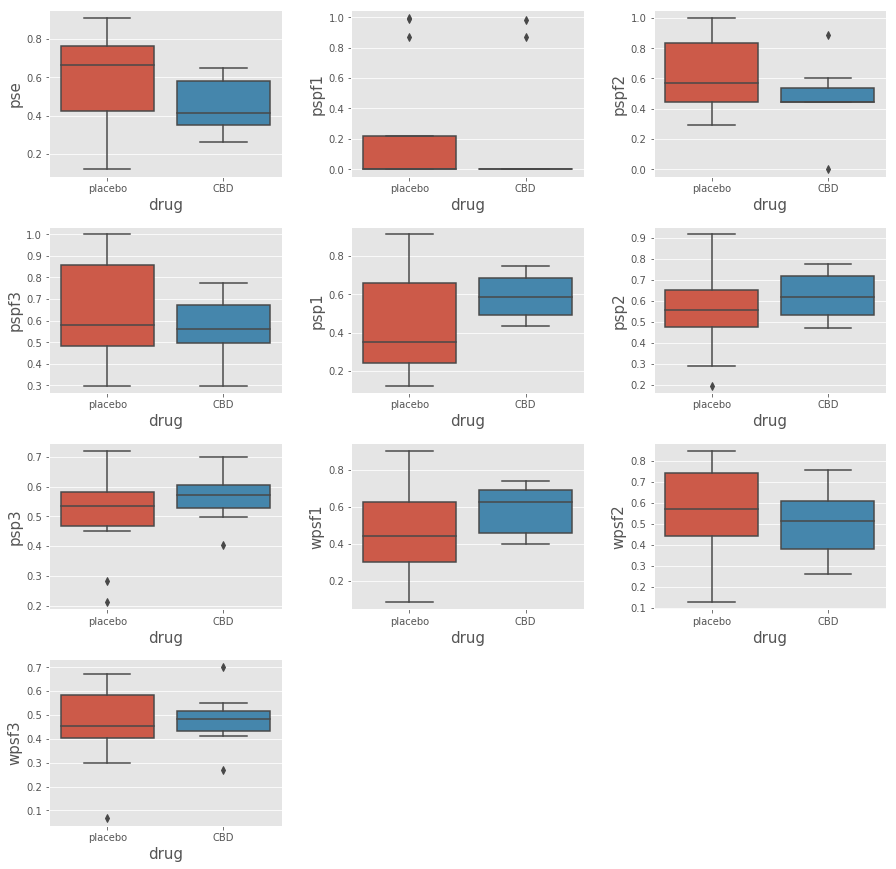

{'pse': 0.2158057749923704, 'pspf1': 0.7696591880782779, 'pspf2': 0.10107019658213198, 'pspf3': 0.4174973558932126, 'psp1': 0.1488360957411084, 'psp2': 0.41822857175672823, 'psp3': 0.28539086633186195, 'wpsf1': 0.1976245028994534, 'wpsf2': 0.4679106978871441, 'wpsf3': 0.7829489386788018}


In [20]:
#Boxplot - medida P
boxplot(df_measureP,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureP.loc[df_measureP['drug'] == 'placebo',numeric_cols],df_measureP.loc[df_measureP['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

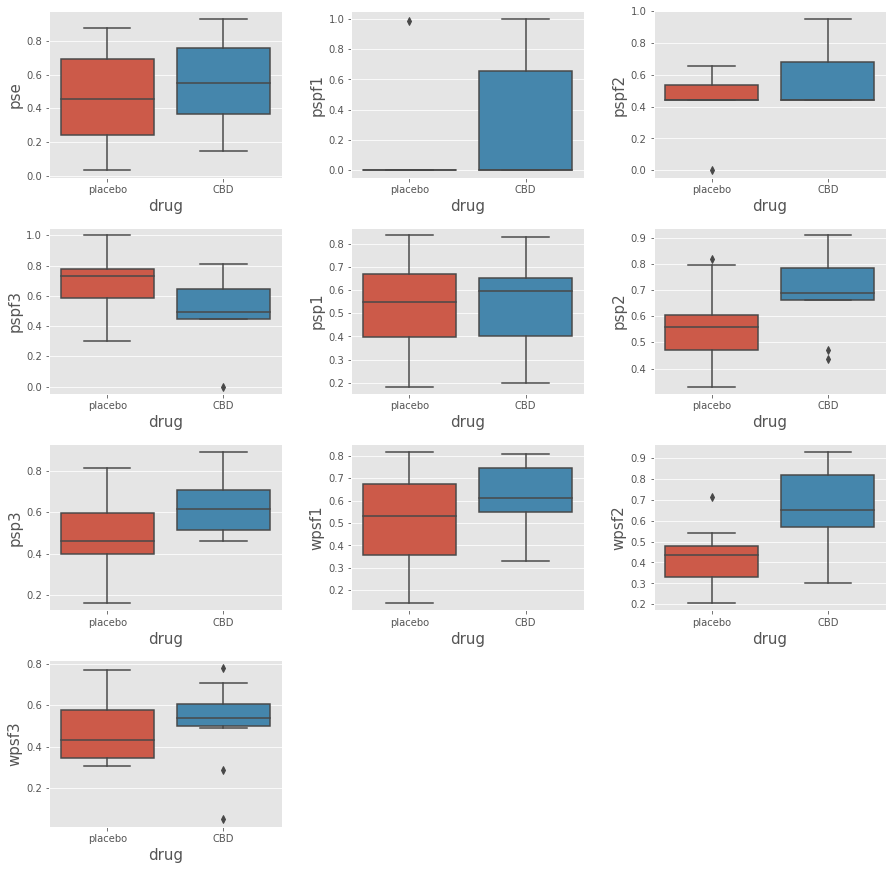

{'pse': 0.524233087139925, 'pspf1': 0.2166380940076684, 'pspf2': 0.17660587130265523, 'pspf3': 0.07221791735157457, 'psp1': 0.7504845252784154, 'psp2': 0.051197855313702564, 'psp3': 0.06666794645252214, 'wpsf1': 0.16418128656034367, 'wpsf2': 0.0033570548128251036, 'wpsf3': 0.6083038447788388}


In [21]:
#Boxplot - medida A
boxplot(df_measureA,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureA.loc[df_measureA['drug'] == 'placebo',numeric_cols],df_measureA.loc[df_measureA['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

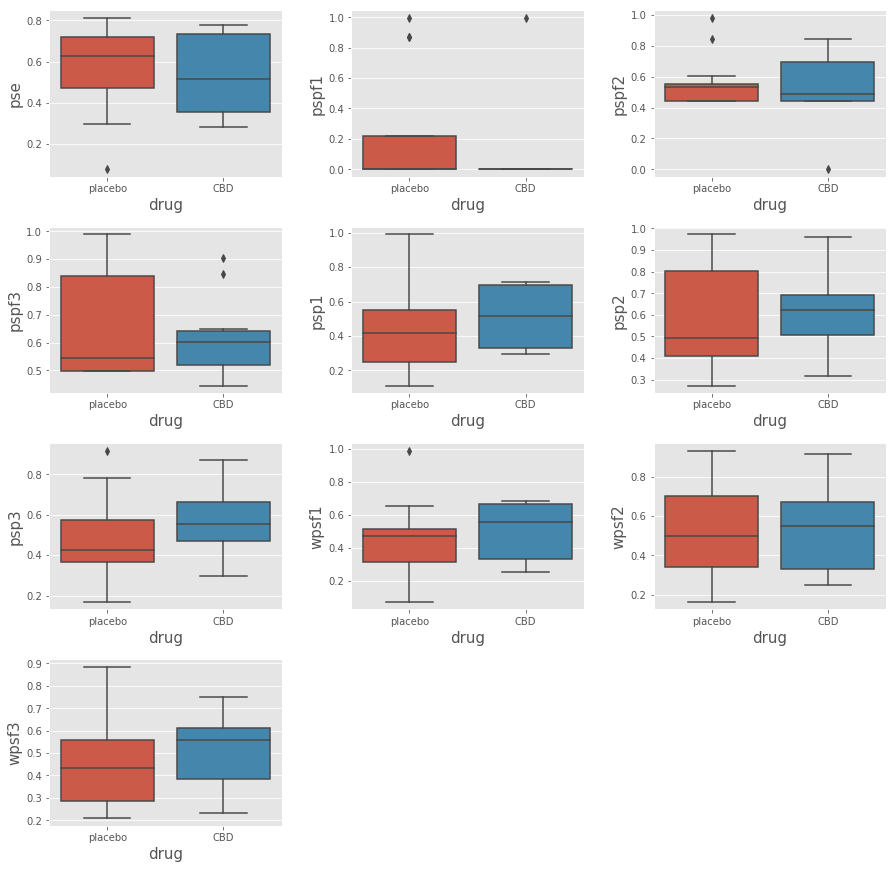

{'pse': 0.7382894254508137, 'pspf1': 0.4293508060732144, 'pspf2': 0.6693625325767341, 'pspf3': 0.6778167214572925, 'psp1': 0.45257849438049047, 'psp2': 0.7768130805973701, 'psp3': 0.34447189728323446, 'wpsf1': 0.5186607659856721, 'wpsf2': 0.9915303368303063, 'wpsf3': 0.4472566820624464}


In [22]:
#Boxplot - medida S1
boxplot(df_measureS1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS1.loc[df_measureS1['drug'] == 'placebo',numeric_cols],df_measureS1.loc[df_measureS1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

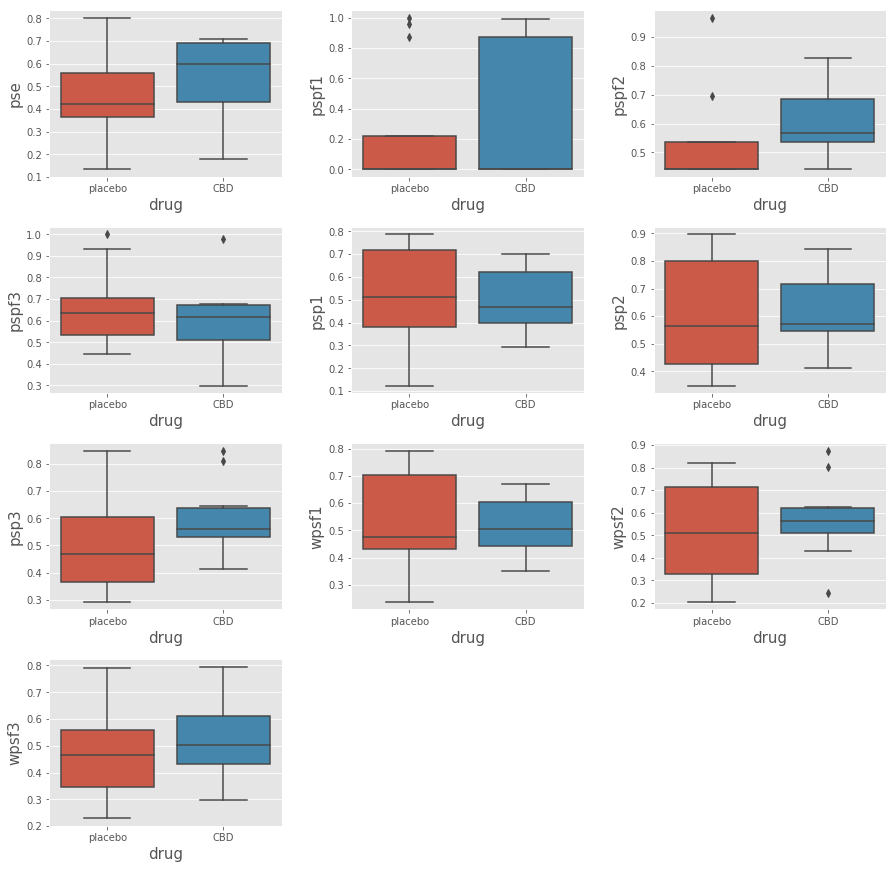

{'pse': 0.3341653510776609, 'pspf1': 0.520559895541739, 'pspf2': 0.2719072430327943, 'pspf3': 0.3968110065789233, 'psp1': 0.9232071862152441, 'psp2': 0.7293039512033311, 'psp3': 0.21147321264224103, 'wpsf1': 0.9207027403896368, 'wpsf2': 0.45297396801471423, 'wpsf3': 0.43651255295557656}


In [23]:
#Boxplot - medida S2
boxplot(df_measureS2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureS2.loc[df_measureS2['drug'] == 'placebo',numeric_cols],df_measureS2.loc[df_measureS2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

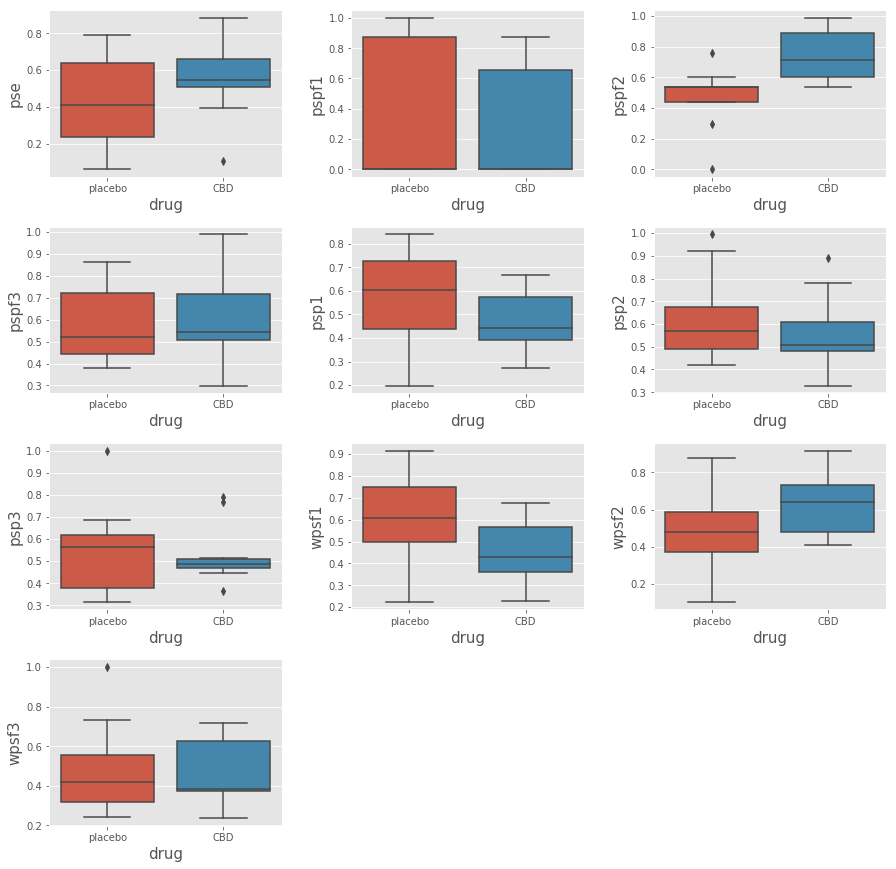

{'pse': 0.21728519967412352, 'pspf1': 0.7984199183397515, 'pspf2': 0.0016256596132041515, 'pspf3': 0.6917983276239507, 'psp1': 0.19828500086744824, 'psp2': 0.4584991503767981, 'psp3': 0.8259300411977557, 'wpsf1': 0.05960775999121423, 'wpsf2': 0.18601704310698022, 'wpsf3': 0.9638187311430915}


In [24]:
#Boxplot - medida F1
boxplot(df_measureF1,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF1.loc[df_measureF1['drug'] == 'placebo',numeric_cols],df_measureF1.loc[df_measureF1['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

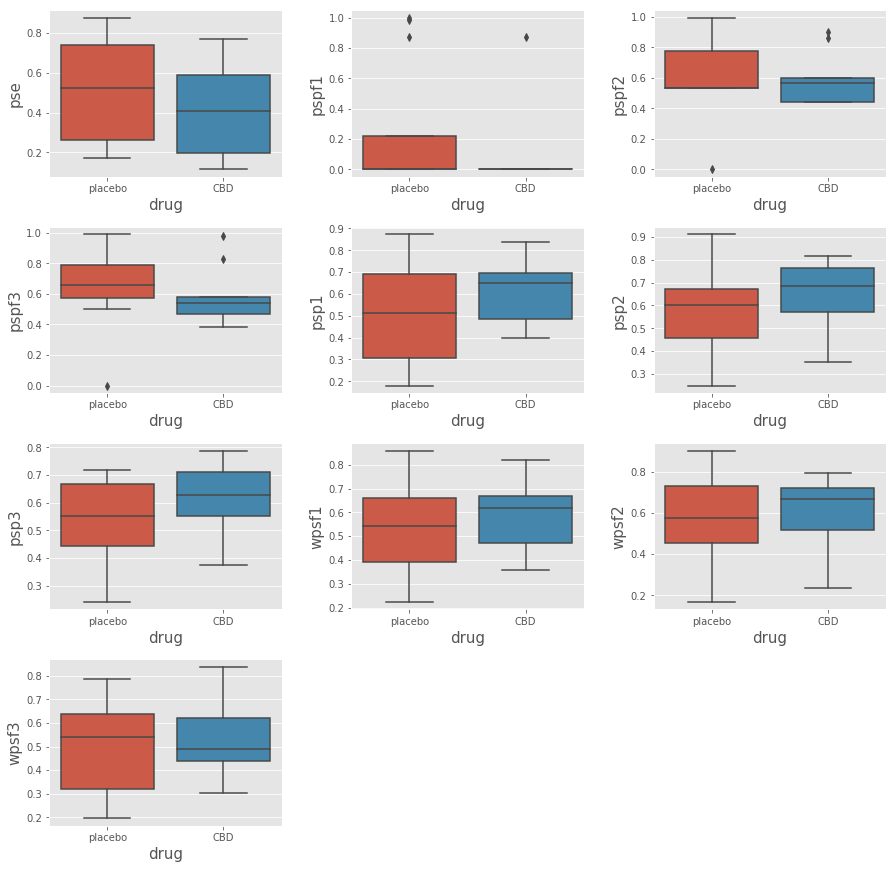

{'pse': 0.4336446993375124, 'pspf1': 0.35211627696755976, 'pspf2': 0.785570696070829, 'pspf3': 0.49768907937193974, 'psp1': 0.19431085030277864, 'psp2': 0.4122027989785999, 'psp3': 0.2466664523058719, 'wpsf1': 0.3748739046731633, 'wpsf2': 0.6695178802020949, 'wpsf3': 0.5889523209109746}


In [25]:
#Boxplot - medida F2
boxplot(df_measureF2,numeric_cols,'drug')

#ANOVA
_,pvalue = f_oneway(df_measureF2.loc[df_measureF2['drug'] == 'placebo',numeric_cols],df_measureF2.loc[df_measureF2['drug'] == 'CBD',numeric_cols])
print(dict(zip(numeric_cols,pvalue)))

Aparentemente ao realizar a divisão por avaliação, temos que os boxplot's tendem a ser semanticamente iguais, i.e, comparando as avaliações eles trazem o mesmo tipo de conclusão. 

Contudo, notamos que ao realizar essa separação temos que em algumas medidas os atributos acabam sendo mais relevantes.

Deve-se considerar na modelagem uma variável que indique o tipo de avaliação, pode ser que ajude para os algoritmos de aprendizado de máquina.

## 2.4 Separando dataset em avaliação 1 e 2 e avaliando nas medidas - Pairplot

### 2.4.1 Avaliação 1

In [26]:
#Dividindo dataset por medida
df_measureB = df_evaluate1[df_evaluate1['measure'] == 'B'].drop(columns=['measure','evaluate'])
df_measureP = df_evaluate1[df_evaluate1['measure'] == 'P'].drop(columns=['measure','evaluate'])
df_measureA = df_evaluate1[df_evaluate1['measure'] == 'A'].drop(columns=['measure','evaluate'])
df_measureS1 = df_evaluate1[df_evaluate1['measure'] == 'S1'].drop(columns=['measure','evaluate'])
df_measureS2 = df_evaluate1[df_evaluate1['measure'] == 'S2'].drop(columns=['measure','evaluate'])
df_measureF1 = df_evaluate1[df_evaluate1['measure'] == 'F1'].drop(columns=['measure','evaluate'])
df_measureF2 = df_evaluate1[df_evaluate1['measure'] == 'F2'].drop(columns=['measure','evaluate'])

#Colunas para plot
plot_cols = df_evaluate1.drop(columns=['measure','evaluate','drug']).columns.values

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


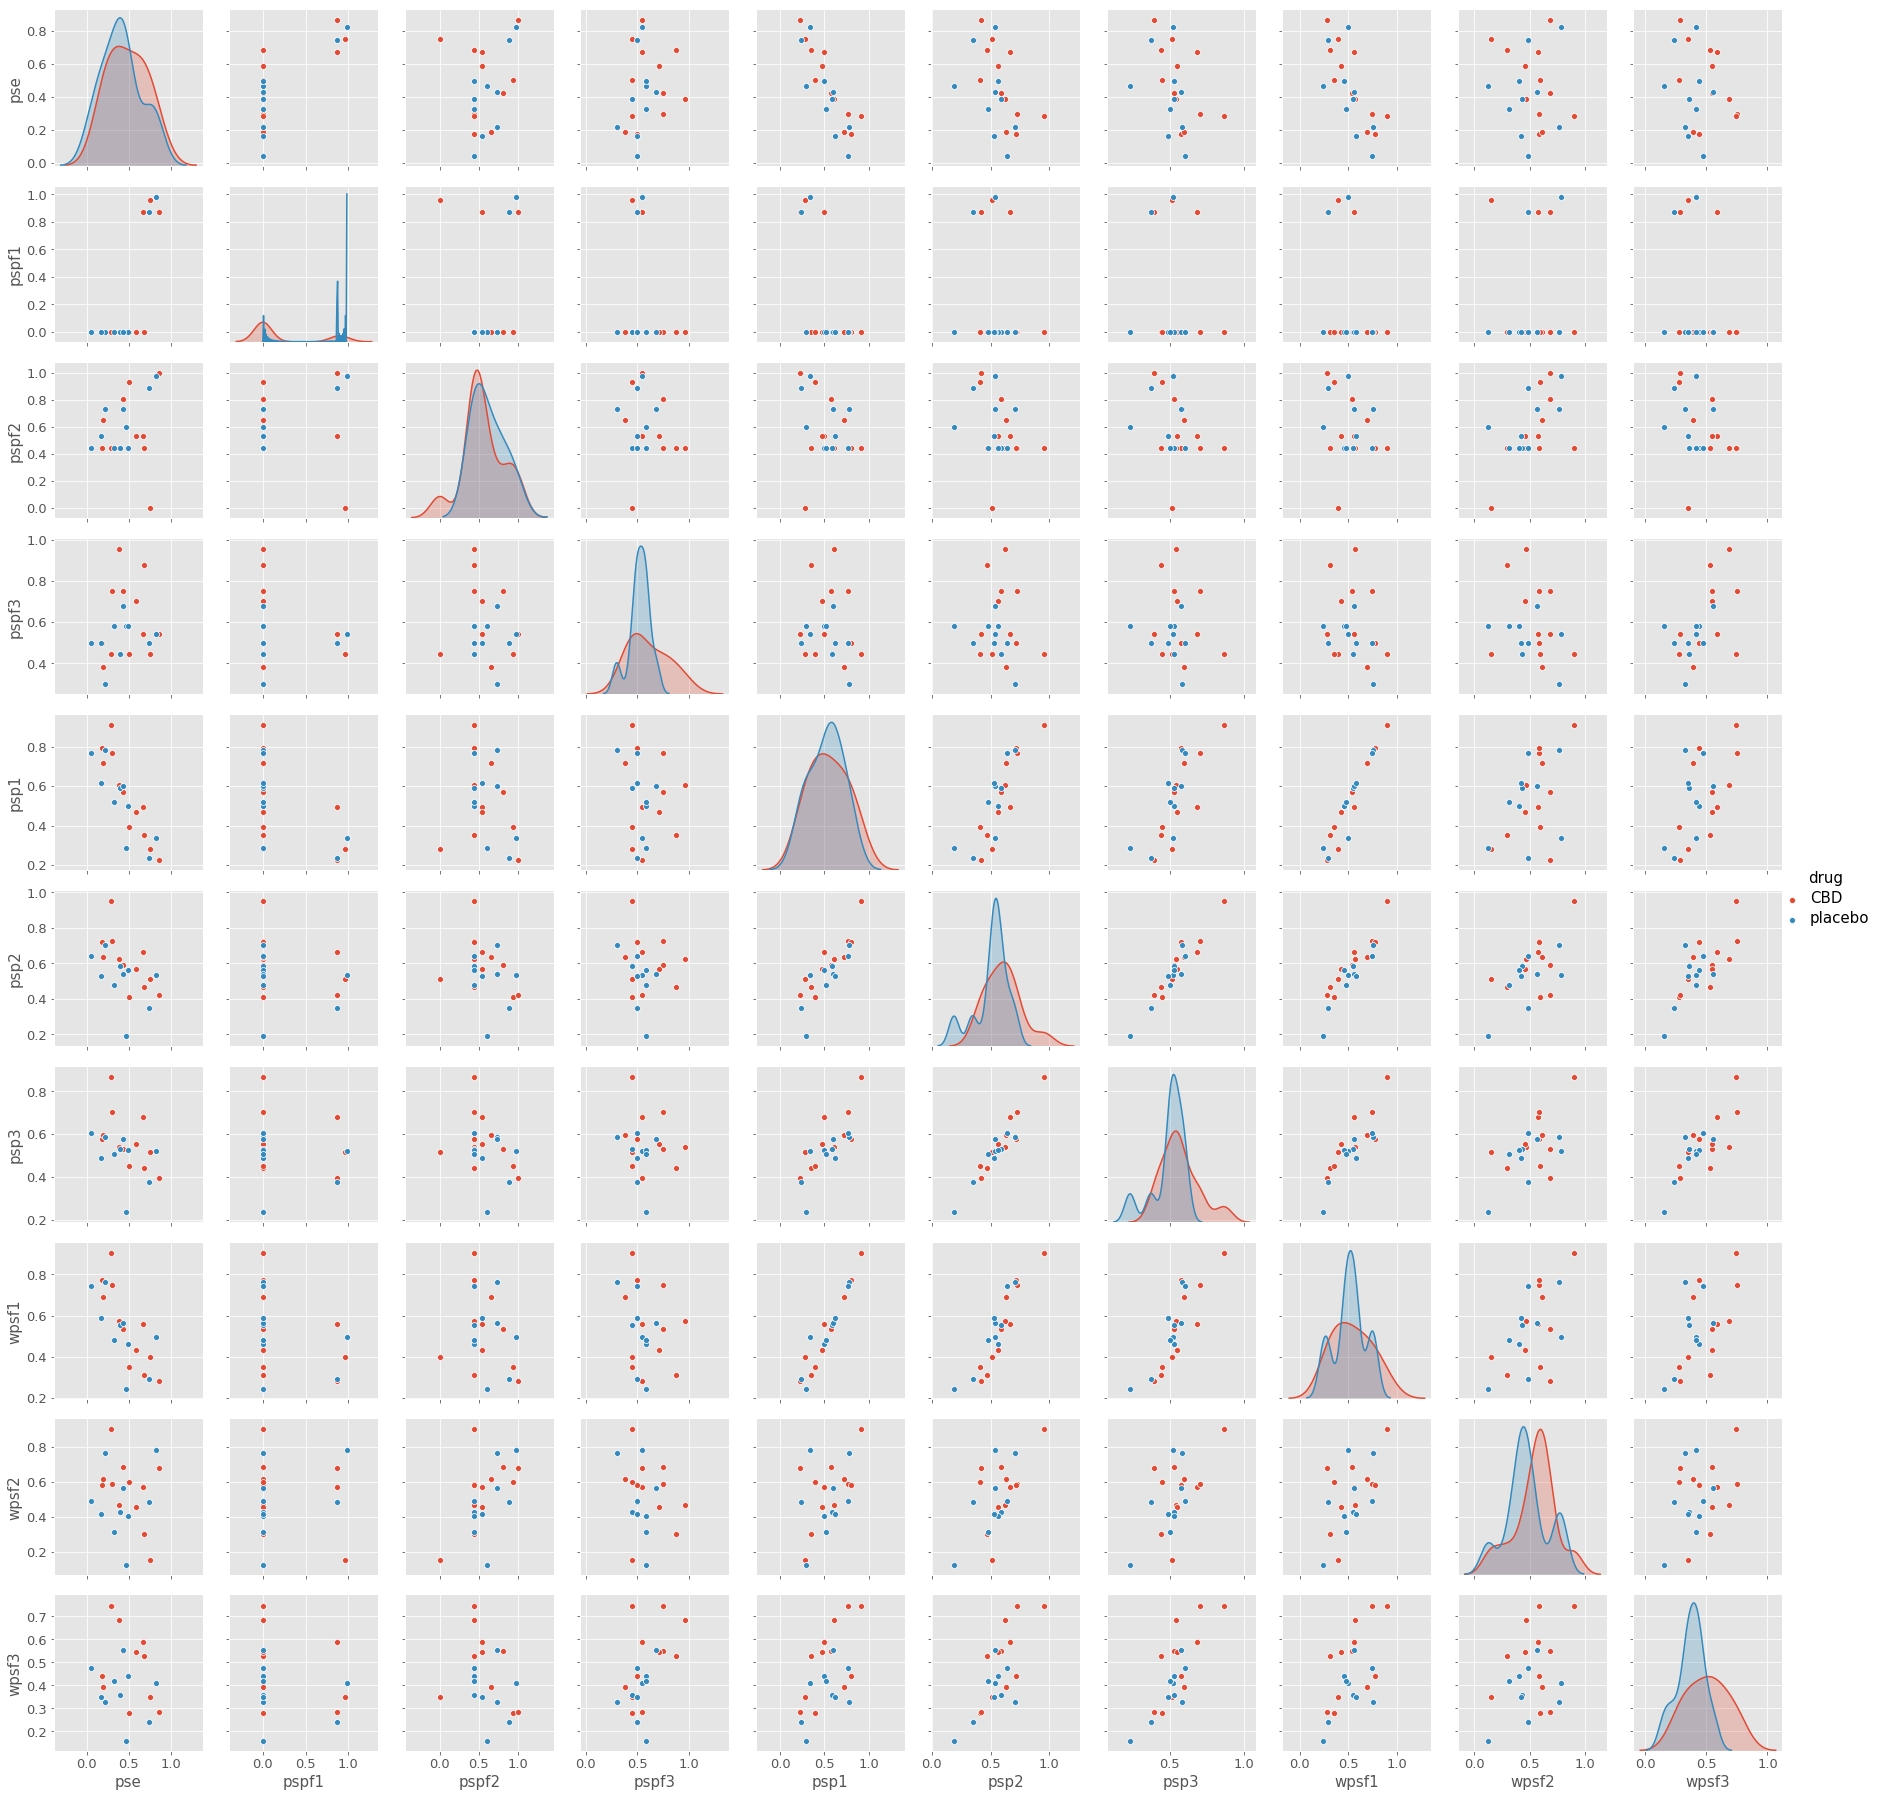

In [27]:
#Pairplot - medida B
pairplot(df_measureB,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/sugi/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/sugi/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/sugi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


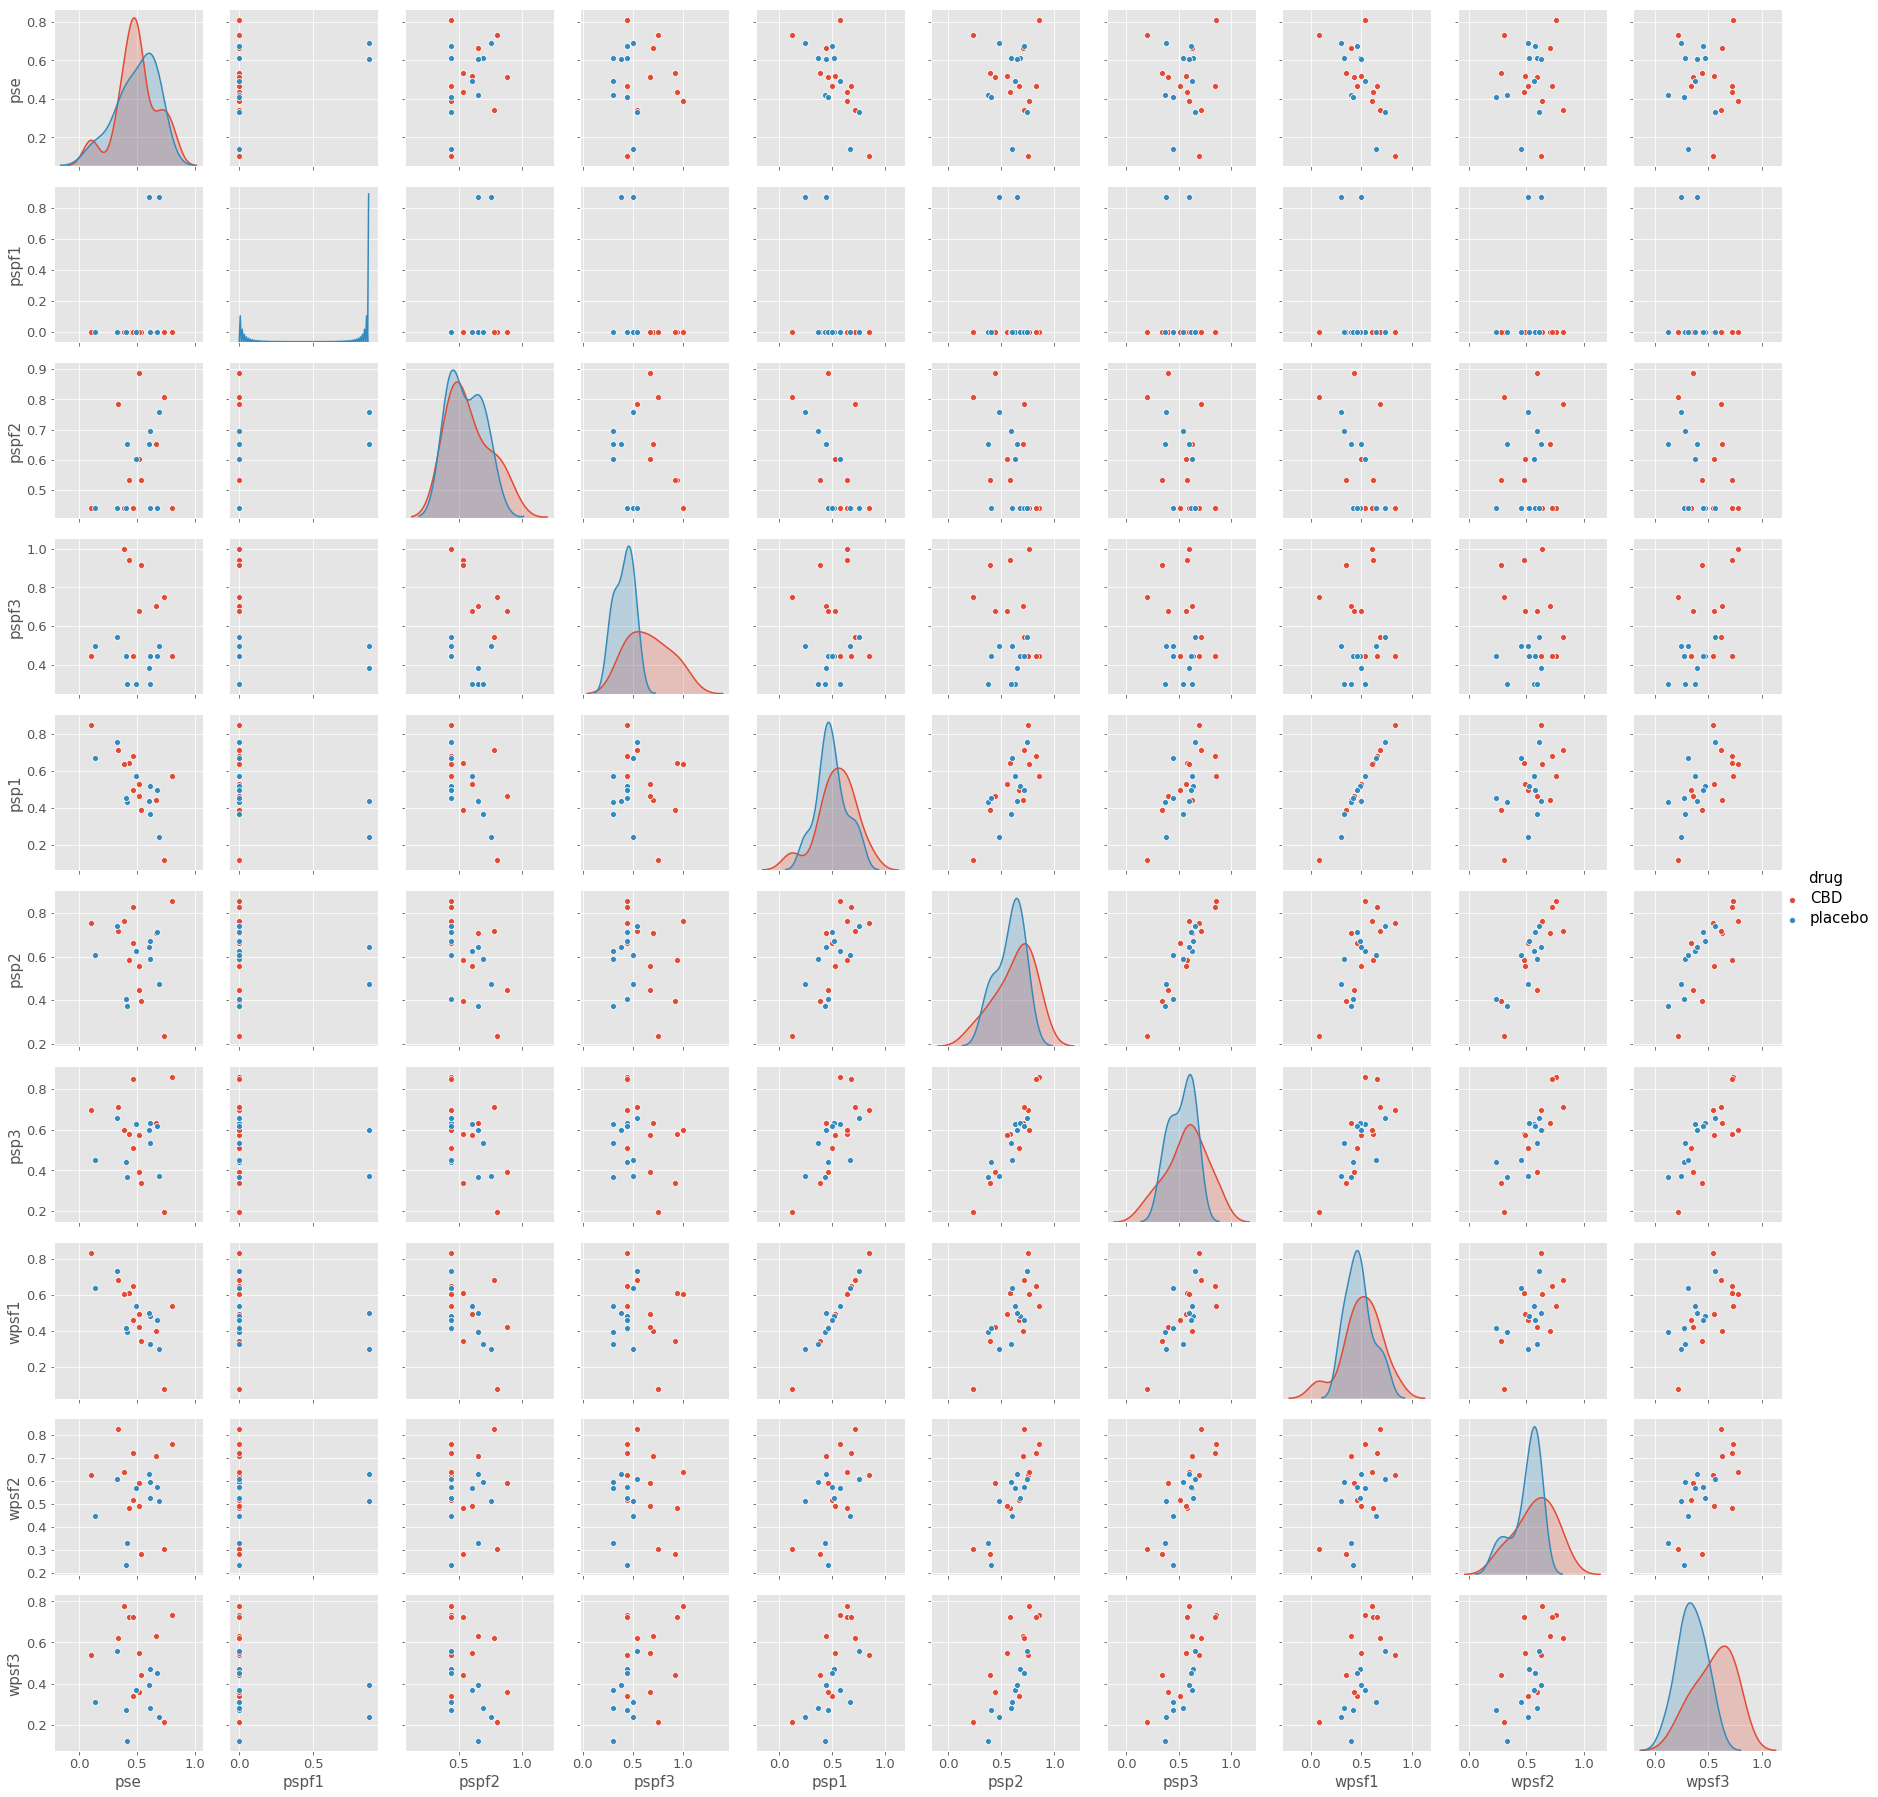

In [28]:
#Pairplot - medida P
pairplot(df_measureP,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/sugi/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/sugi/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/sugi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


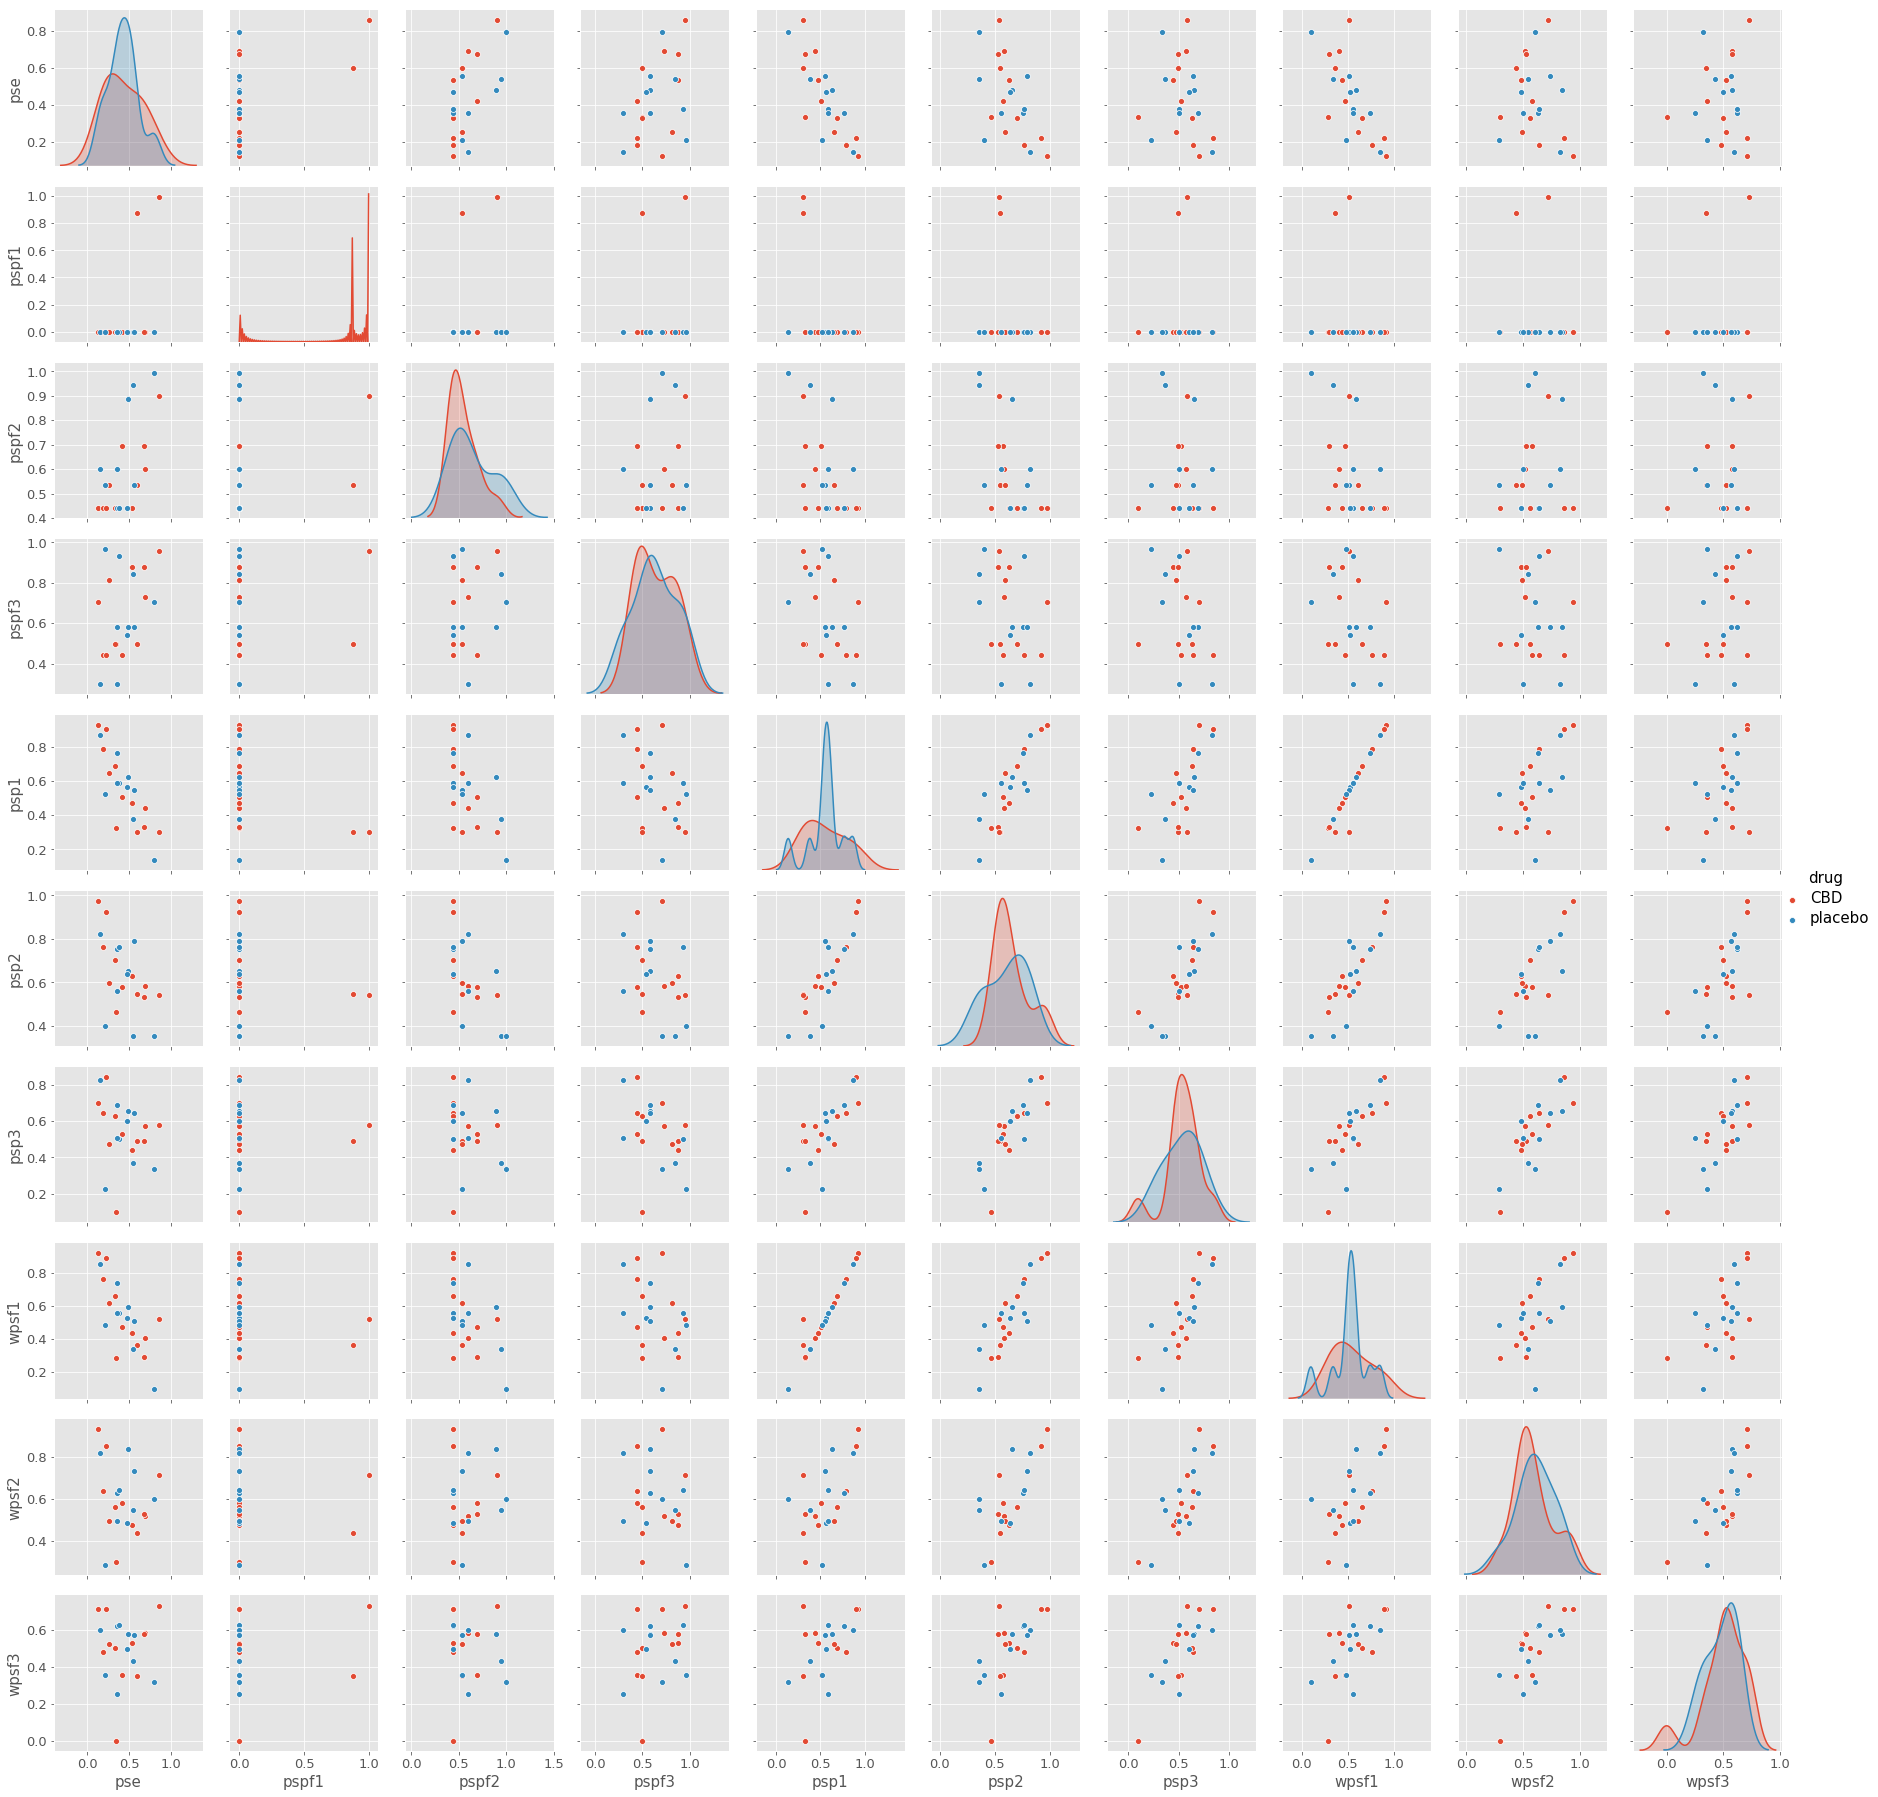

In [29]:
#Pairplot - medida A
pairplot(df_measureA,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


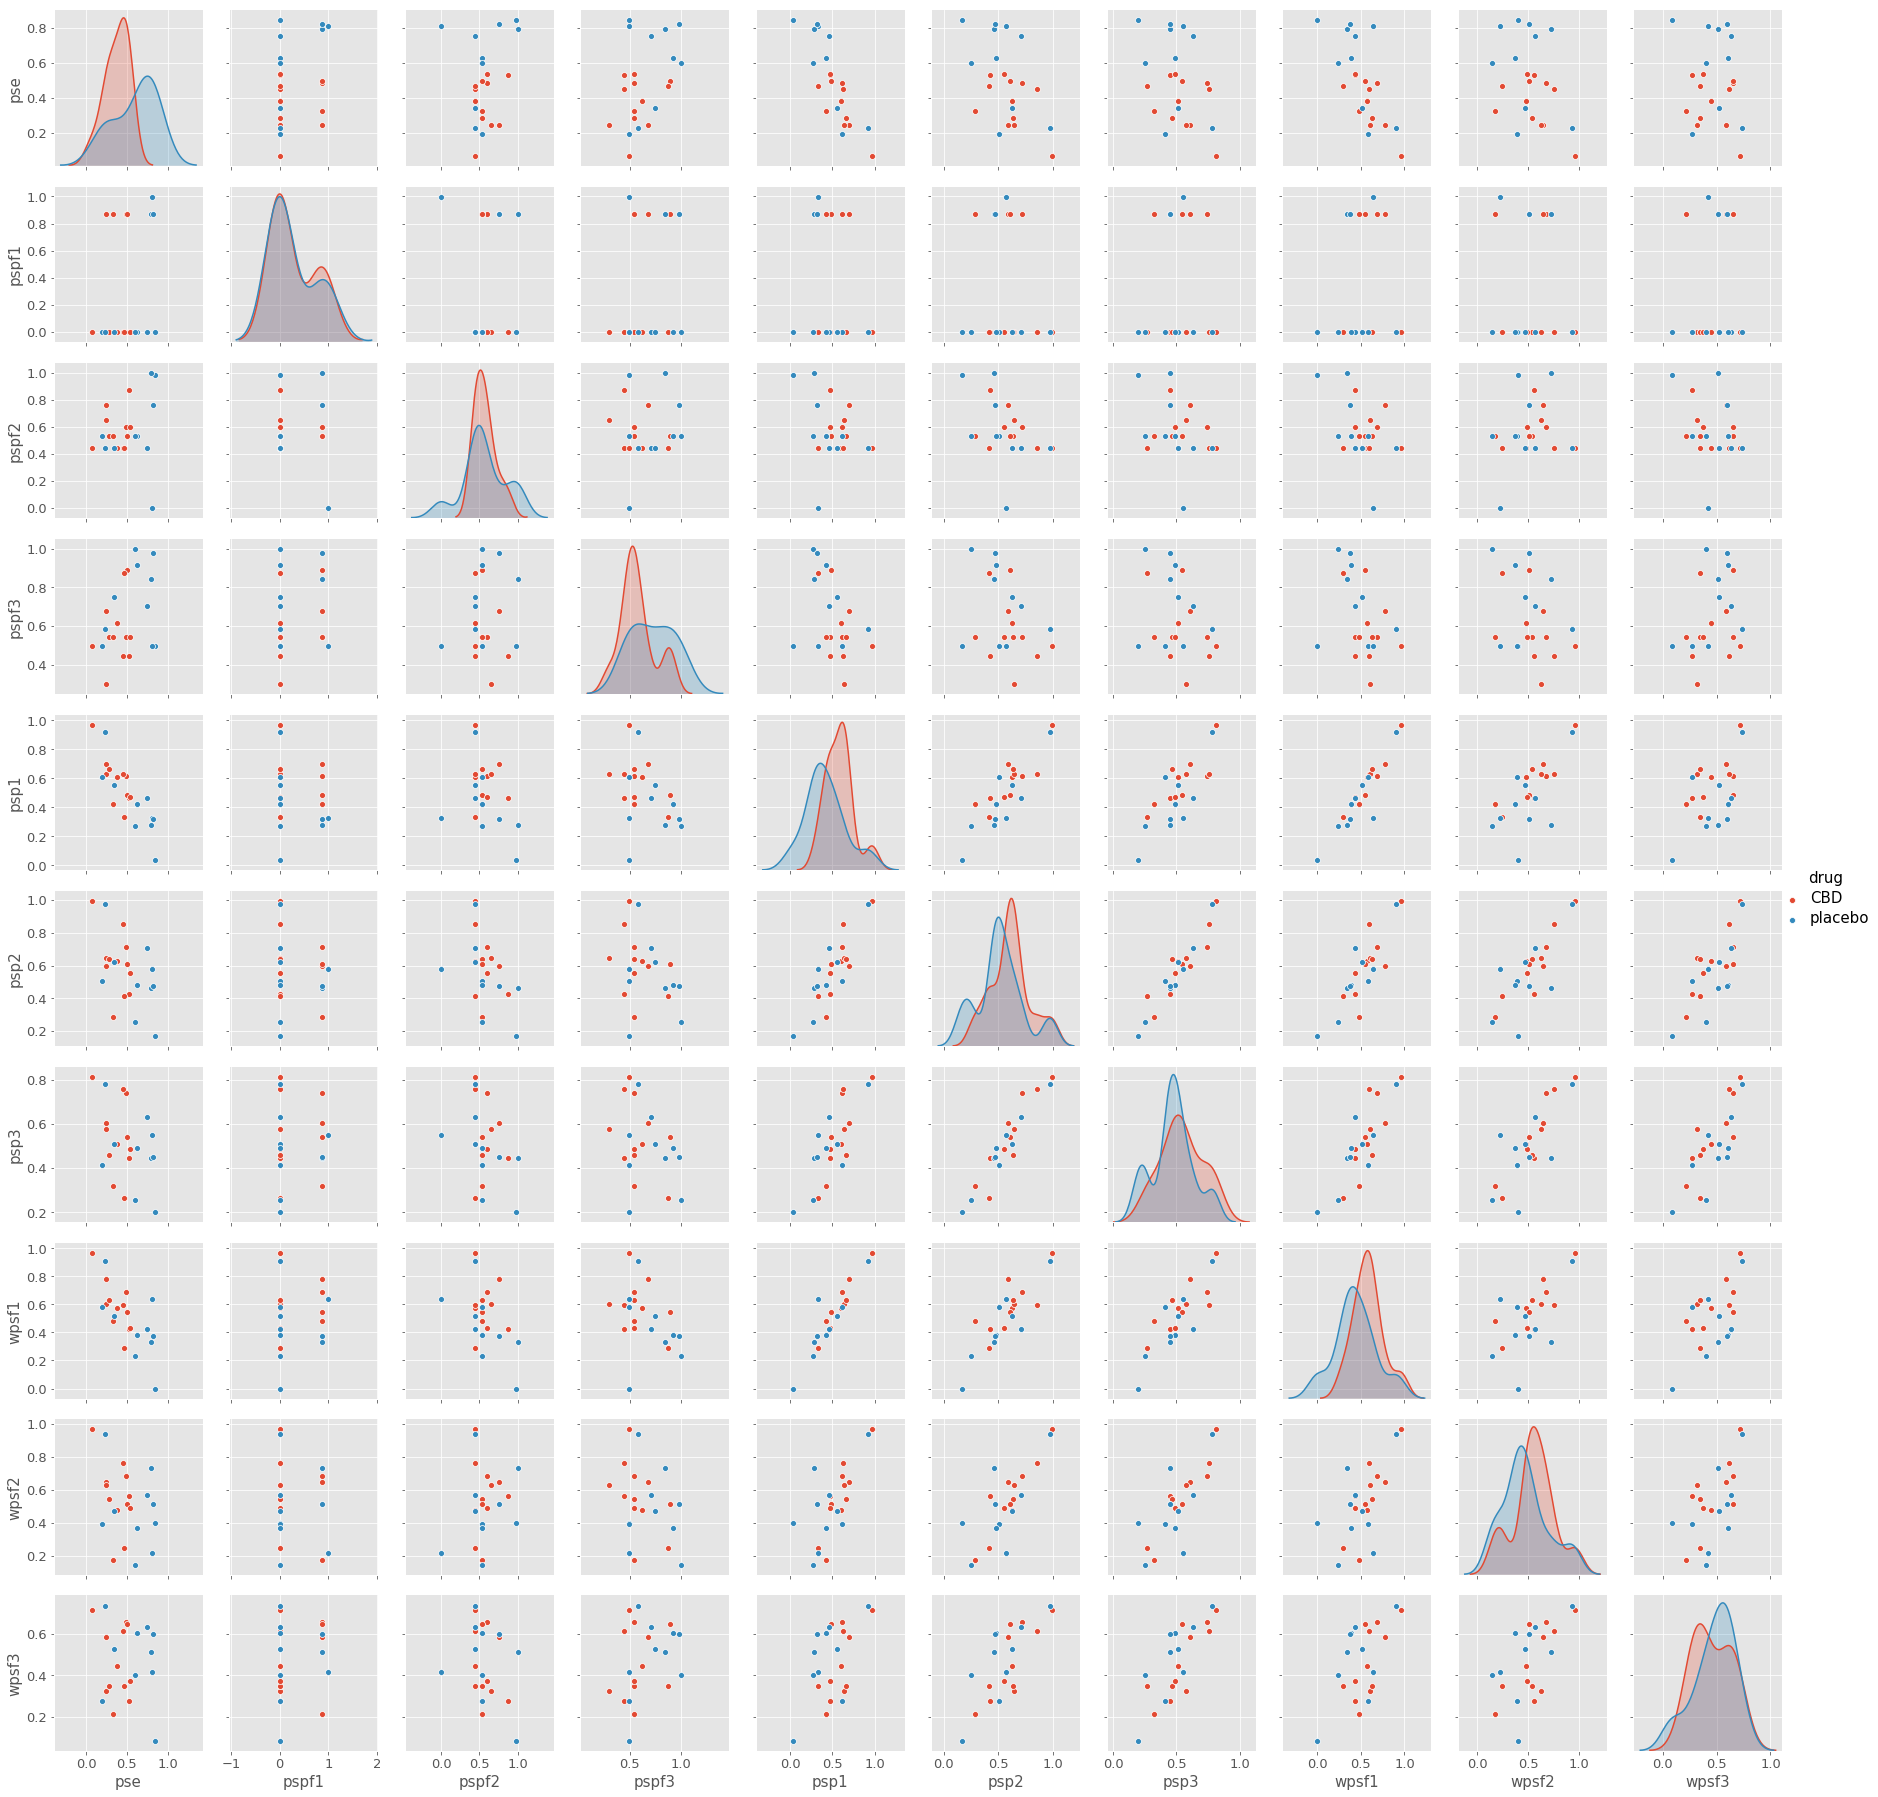

In [30]:
#Pairplot - medida S1
pairplot(df_measureS1,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


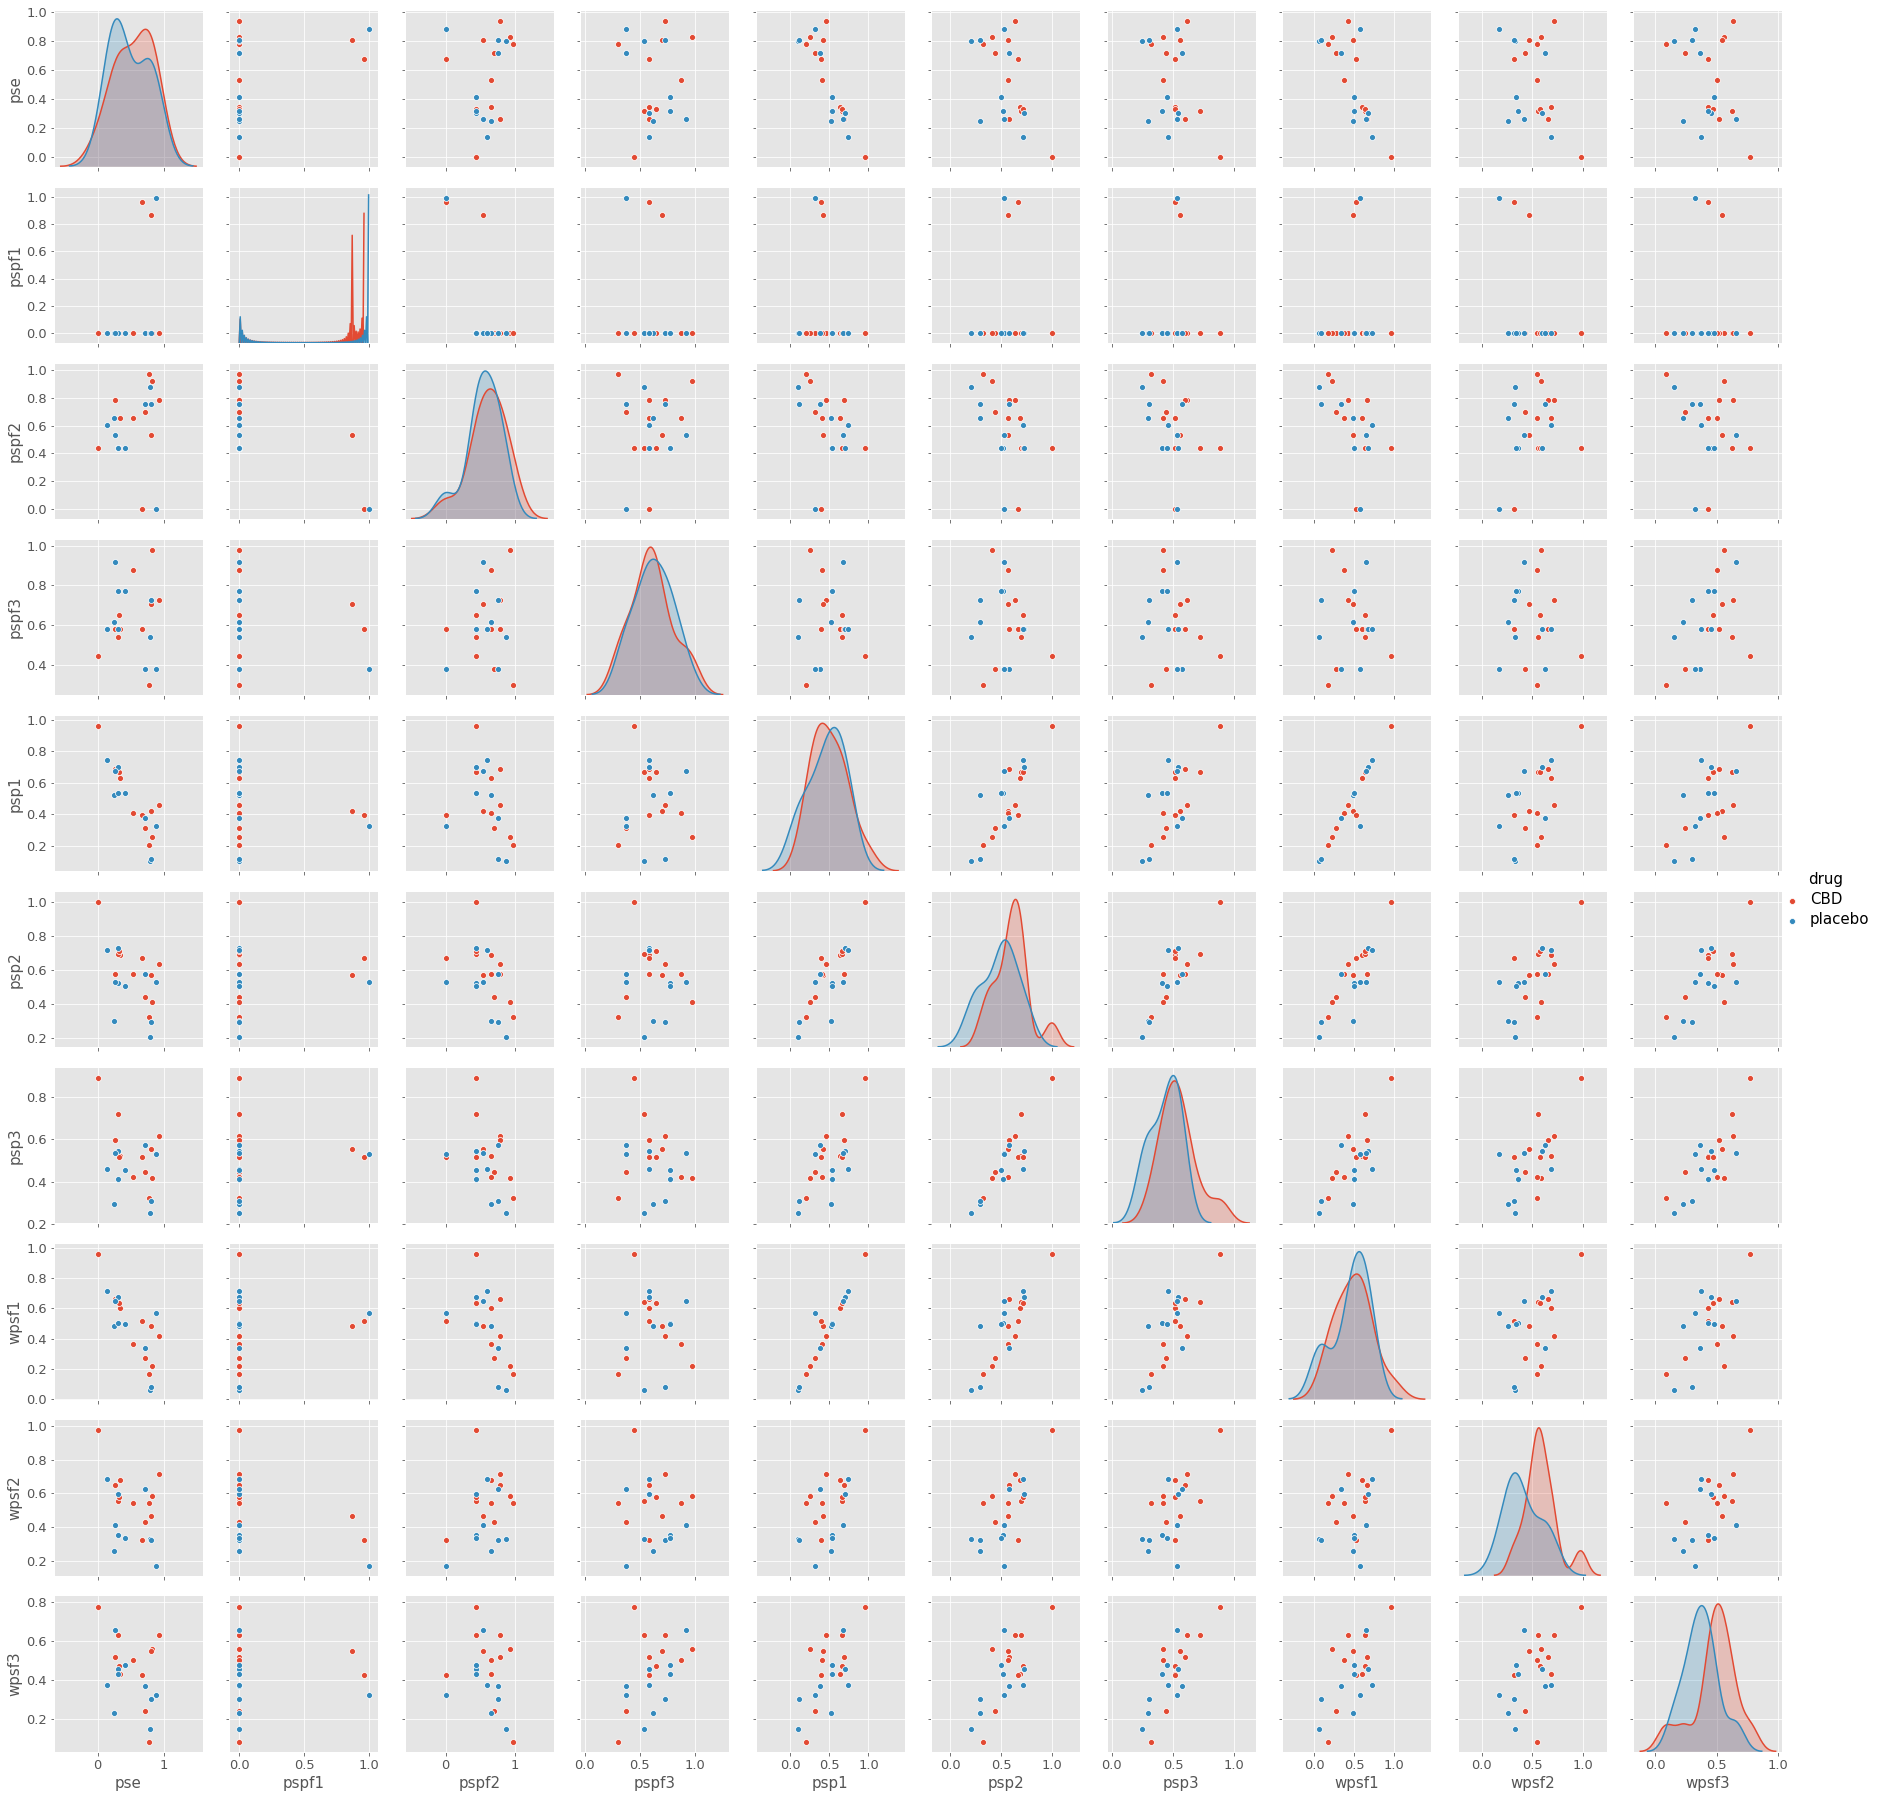

In [31]:
#Pairplot - medida S2
pairplot(df_measureS2,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


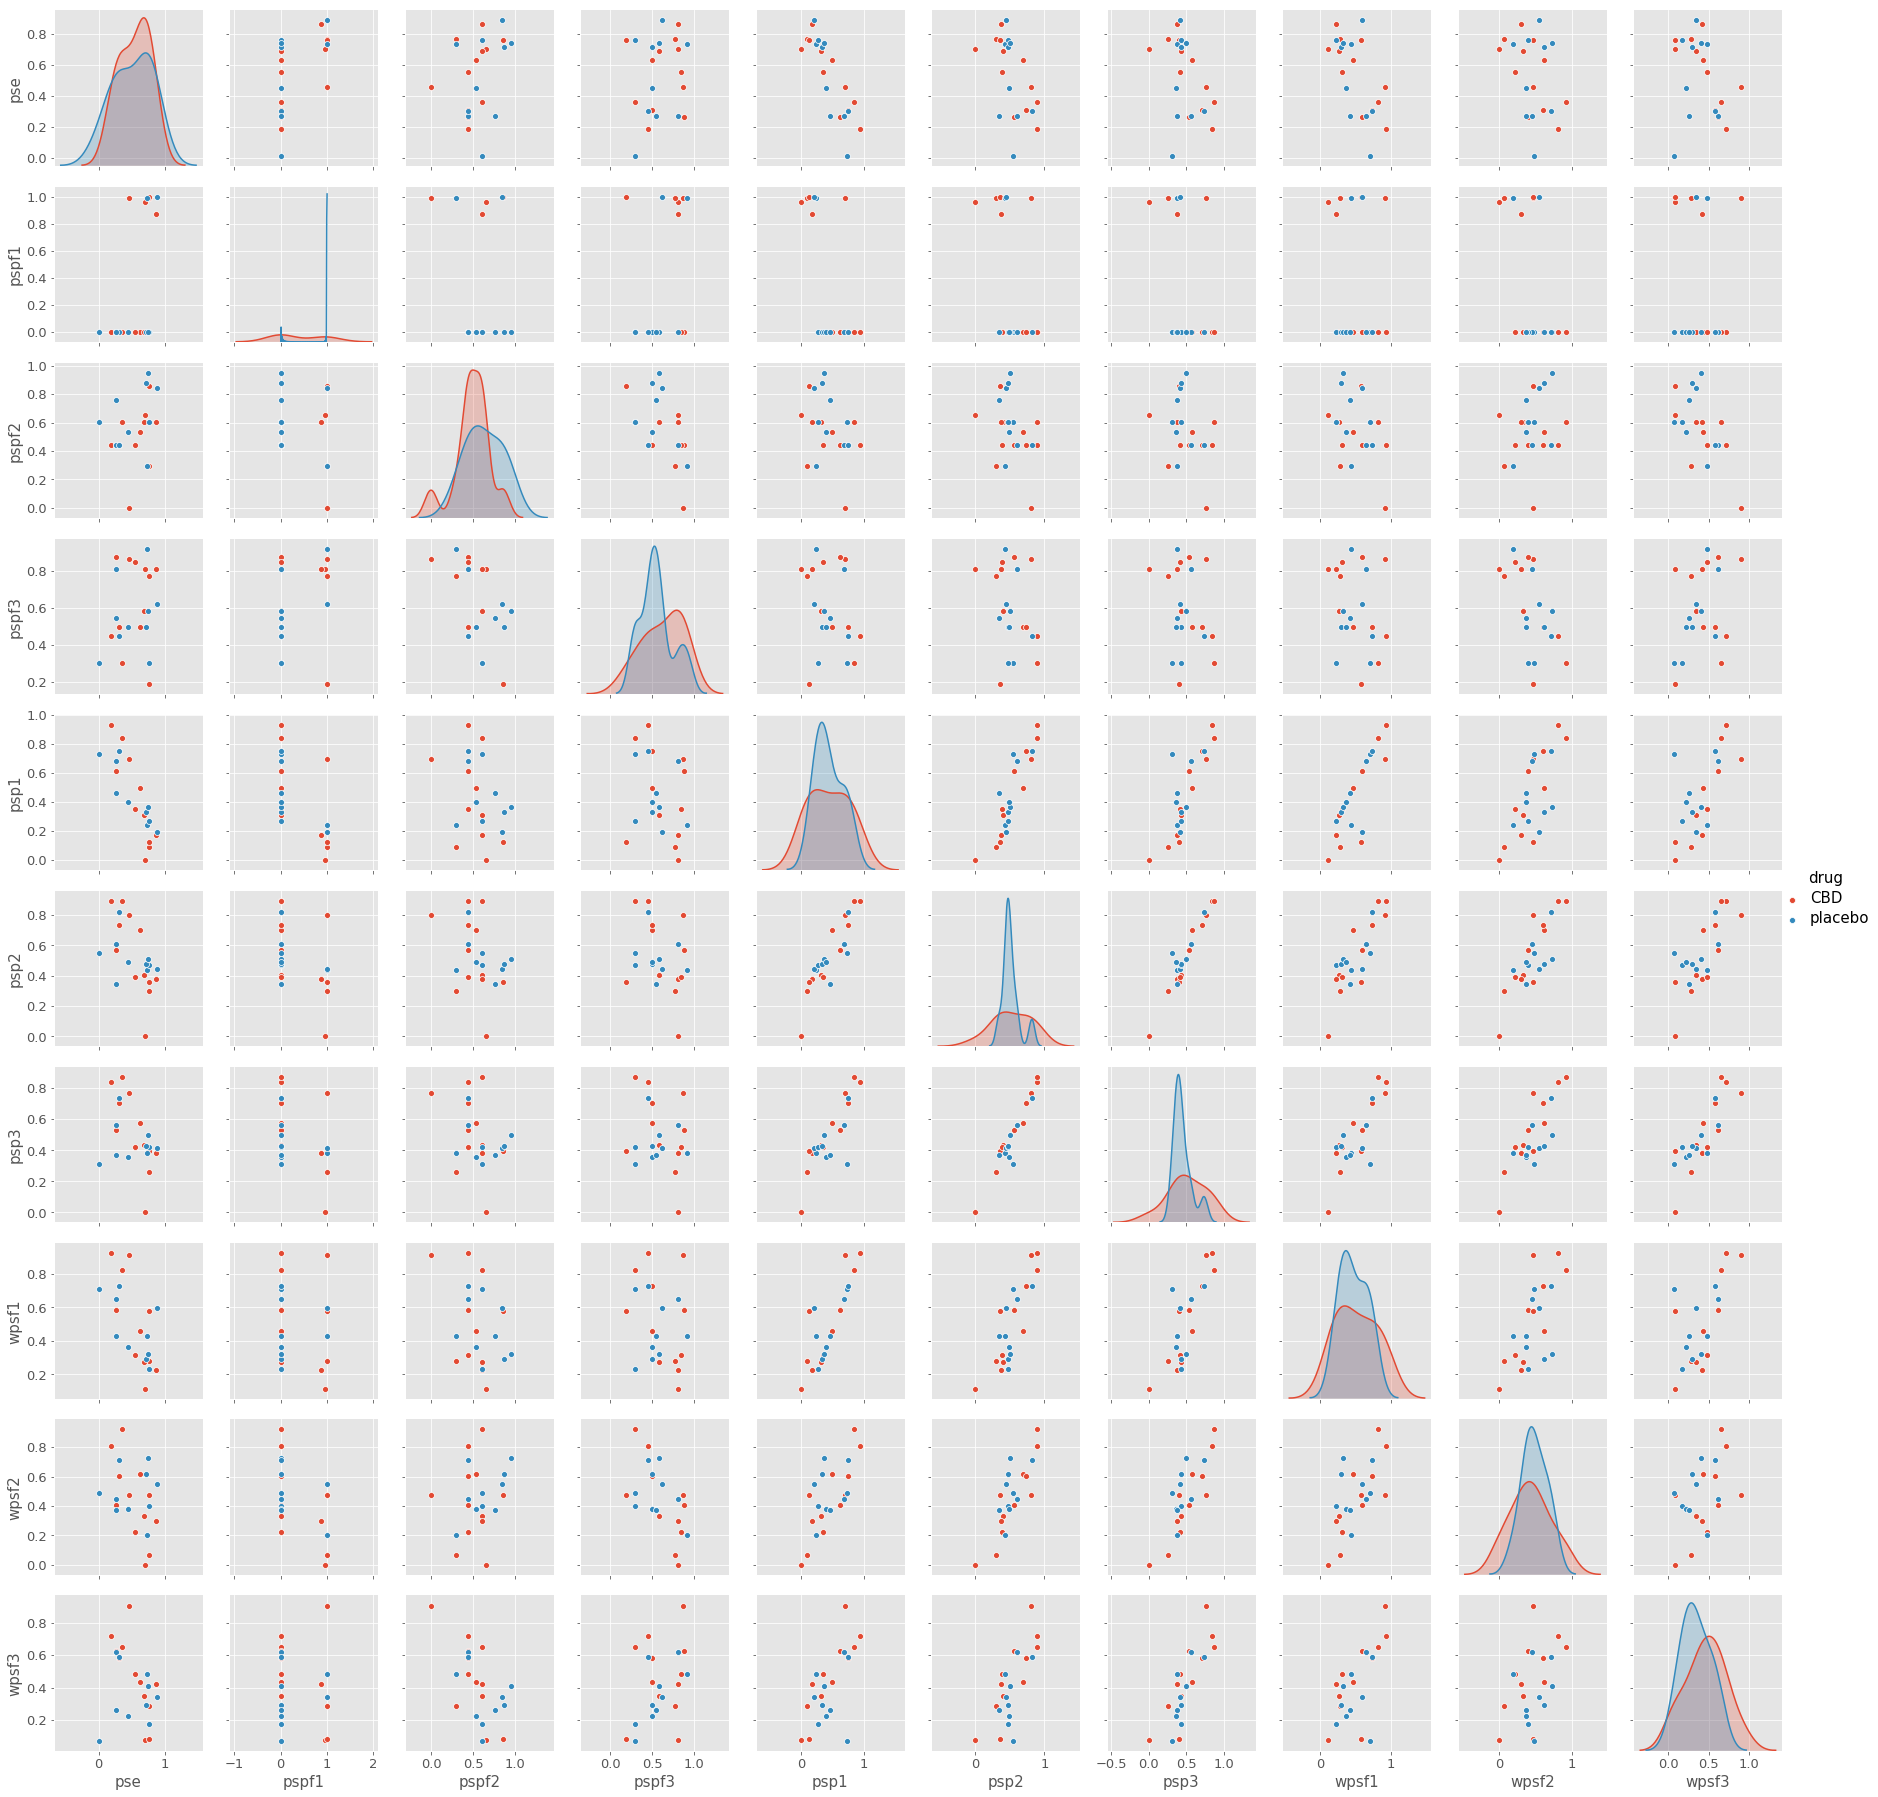

In [32]:
#Pairplot - medida F1
pairplot(df_measureF1,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


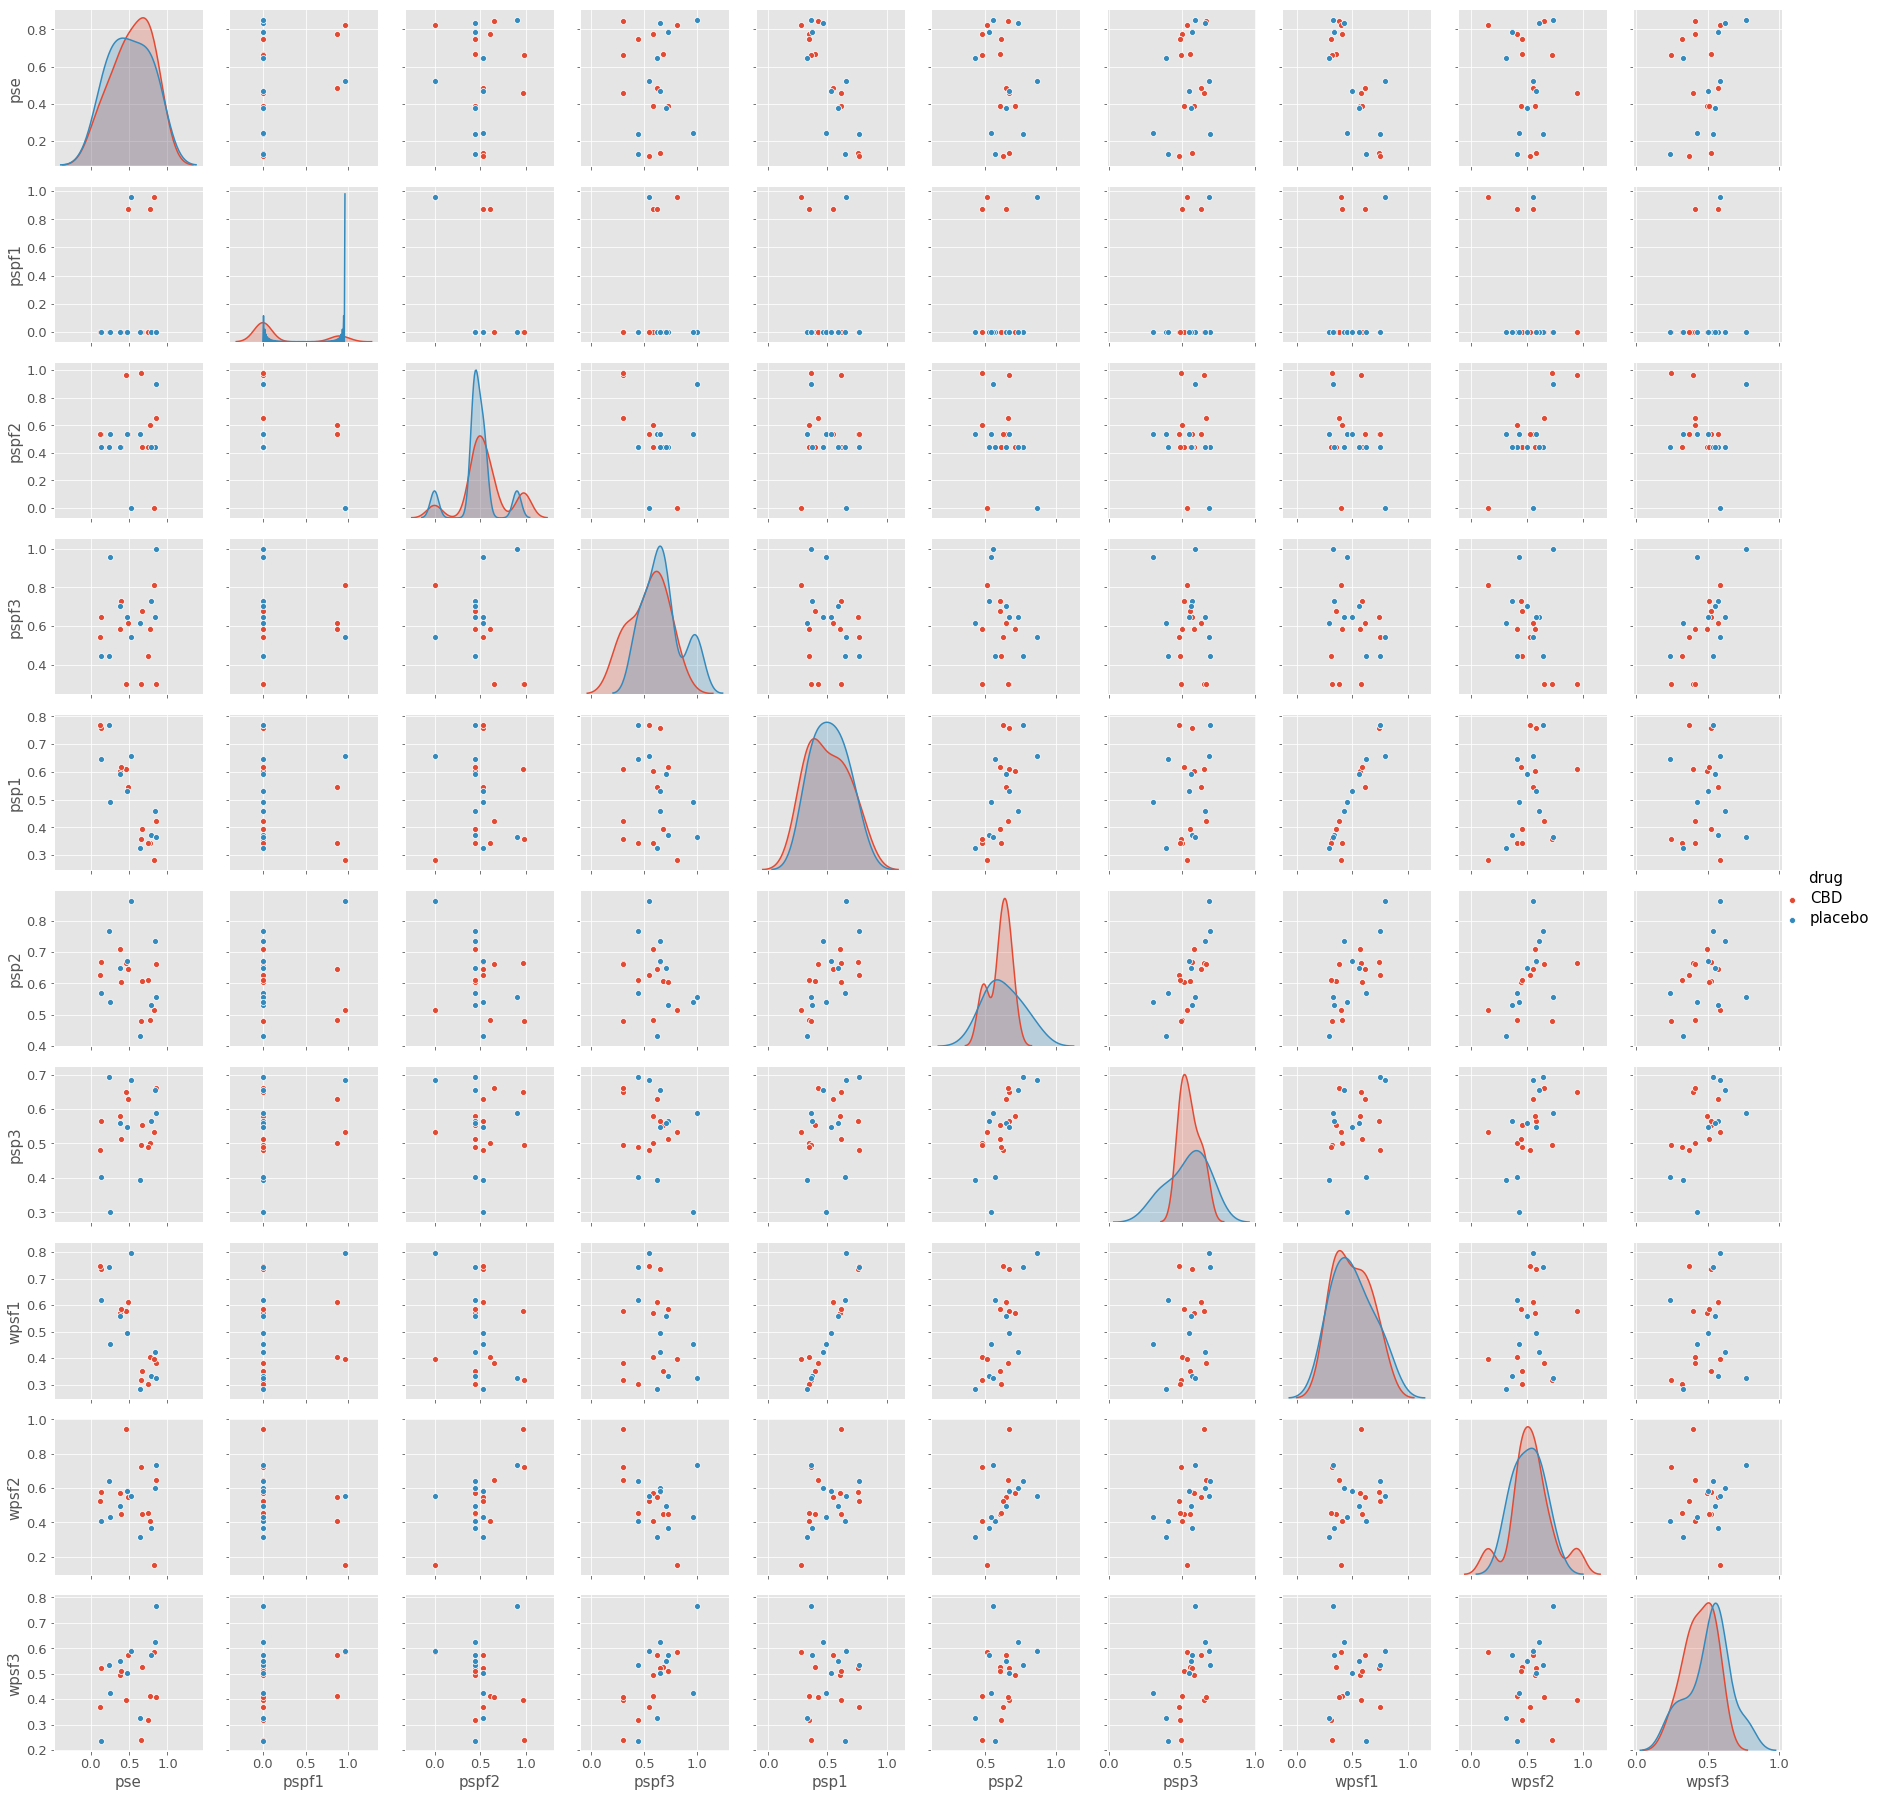

In [33]:
#Pairplot - medida F2
pairplot(df_measureF2,plot_cols,'drug')

### 2.4.2 Avaliação 2

In [34]:
#Dividindo dataset por medida
df_measureB = df_evaluate2[df_evaluate2['measure'] == 'B'].drop(columns=['measure','evaluate'])
df_measureP = df_evaluate2[df_evaluate2['measure'] == 'P'].drop(columns=['measure','evaluate'])
df_measureA = df_evaluate2[df_evaluate2['measure'] == 'A'].drop(columns=['measure','evaluate'])
df_measureS1 = df_evaluate2[df_evaluate2['measure'] == 'S1'].drop(columns=['measure','evaluate'])
df_measureS2 = df_evaluate2[df_evaluate2['measure'] == 'S2'].drop(columns=['measure','evaluate'])
df_measureF1 = df_evaluate2[df_evaluate2['measure'] == 'F1'].drop(columns=['measure','evaluate'])
df_measureF2 = df_evaluate2[df_evaluate2['measure'] == 'F2'].drop(columns=['measure','evaluate'])

#Colunas para plot
plot_cols = df_evaluate1.drop(columns=['measure','evaluate','drug']).columns.values

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


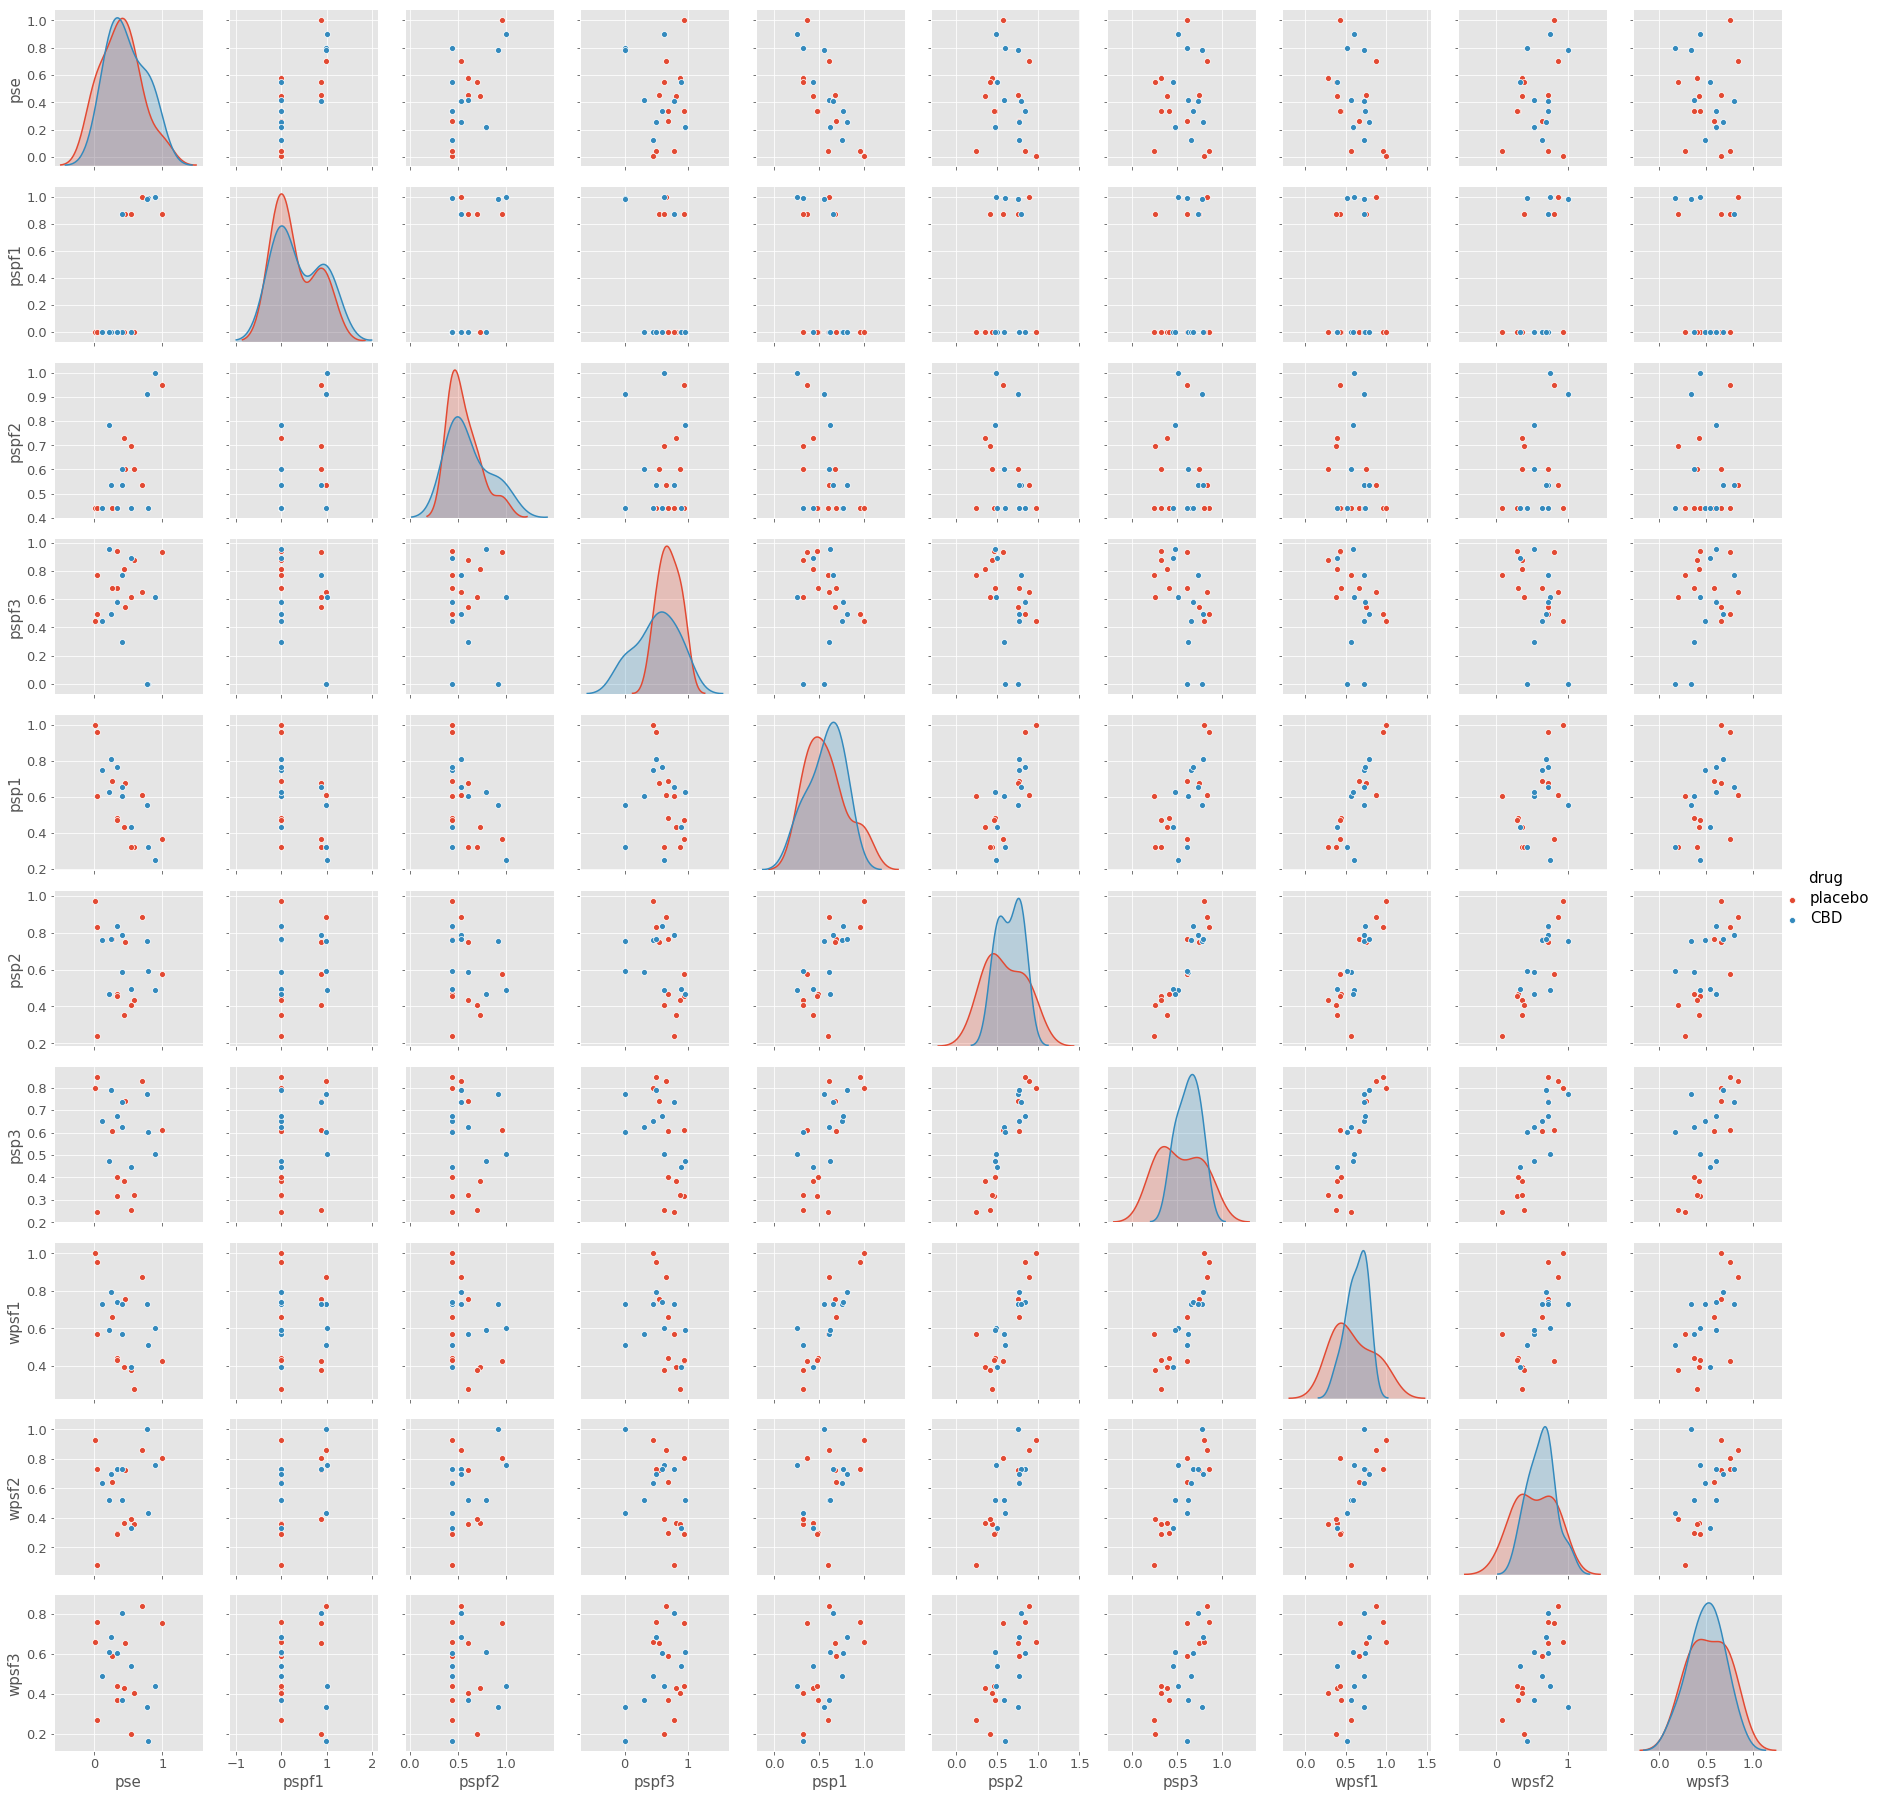

In [35]:
#Pairplot - medida B
pairplot(df_measureB,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


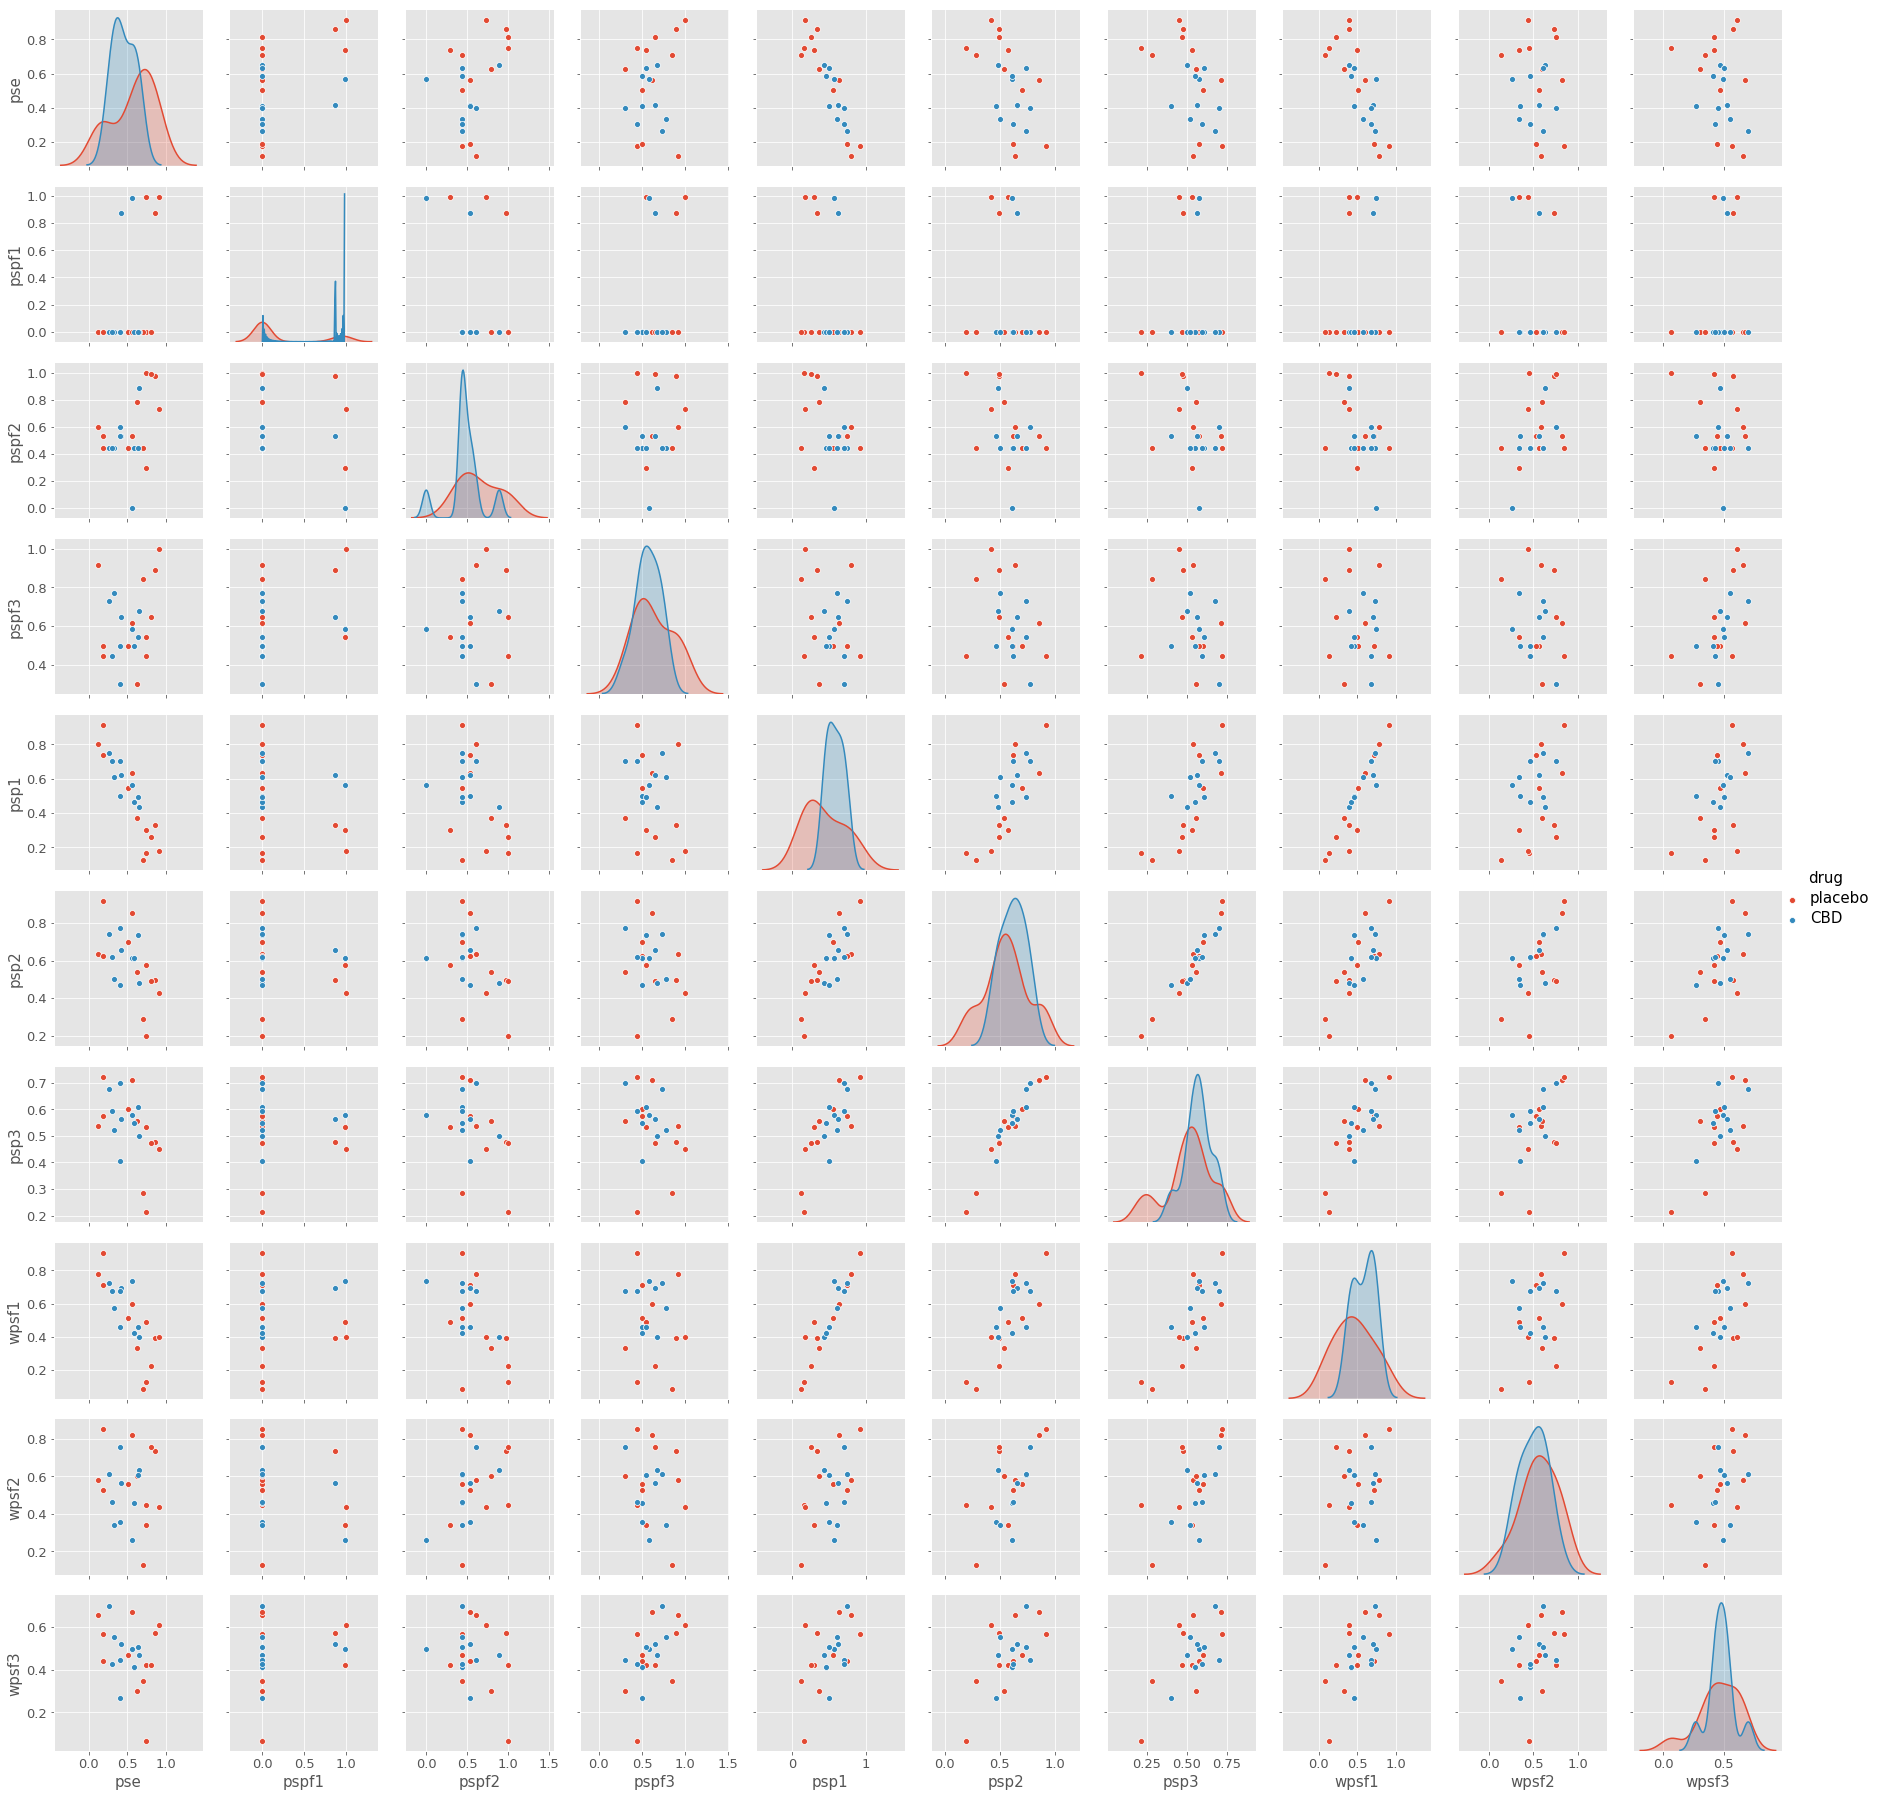

In [36]:
#Pairplot - medida P
pairplot(df_measureP,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


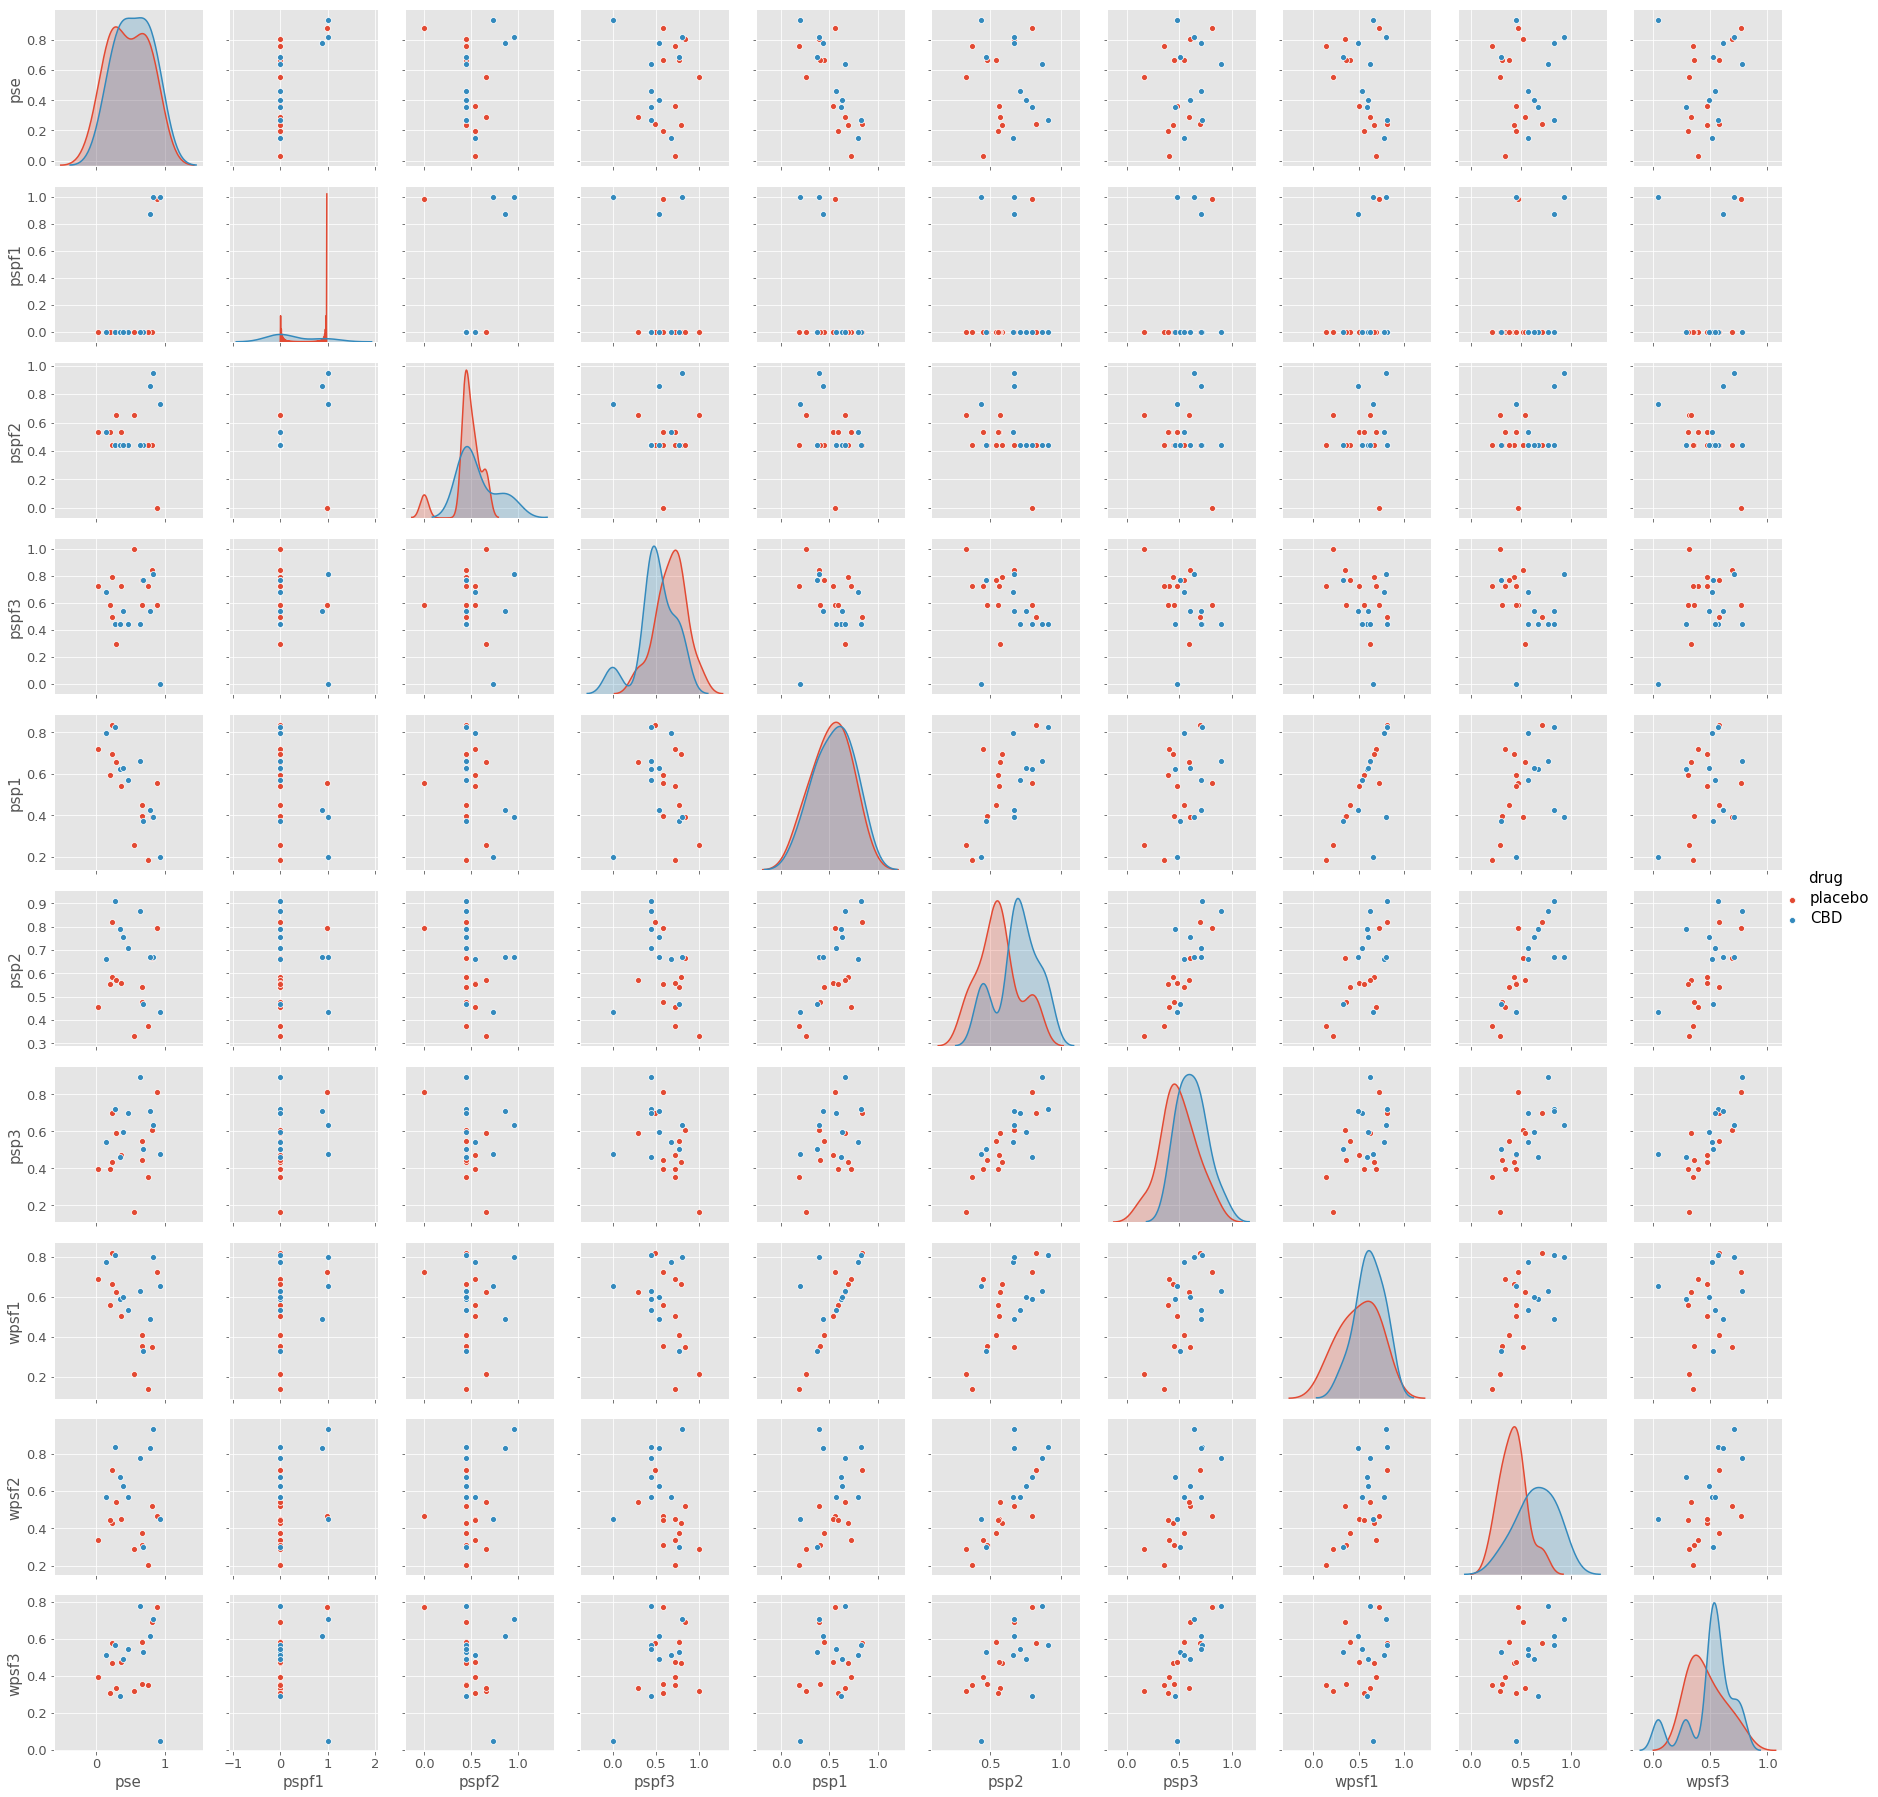

In [37]:
#Pairplot - medida A
pairplot(df_measureA,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


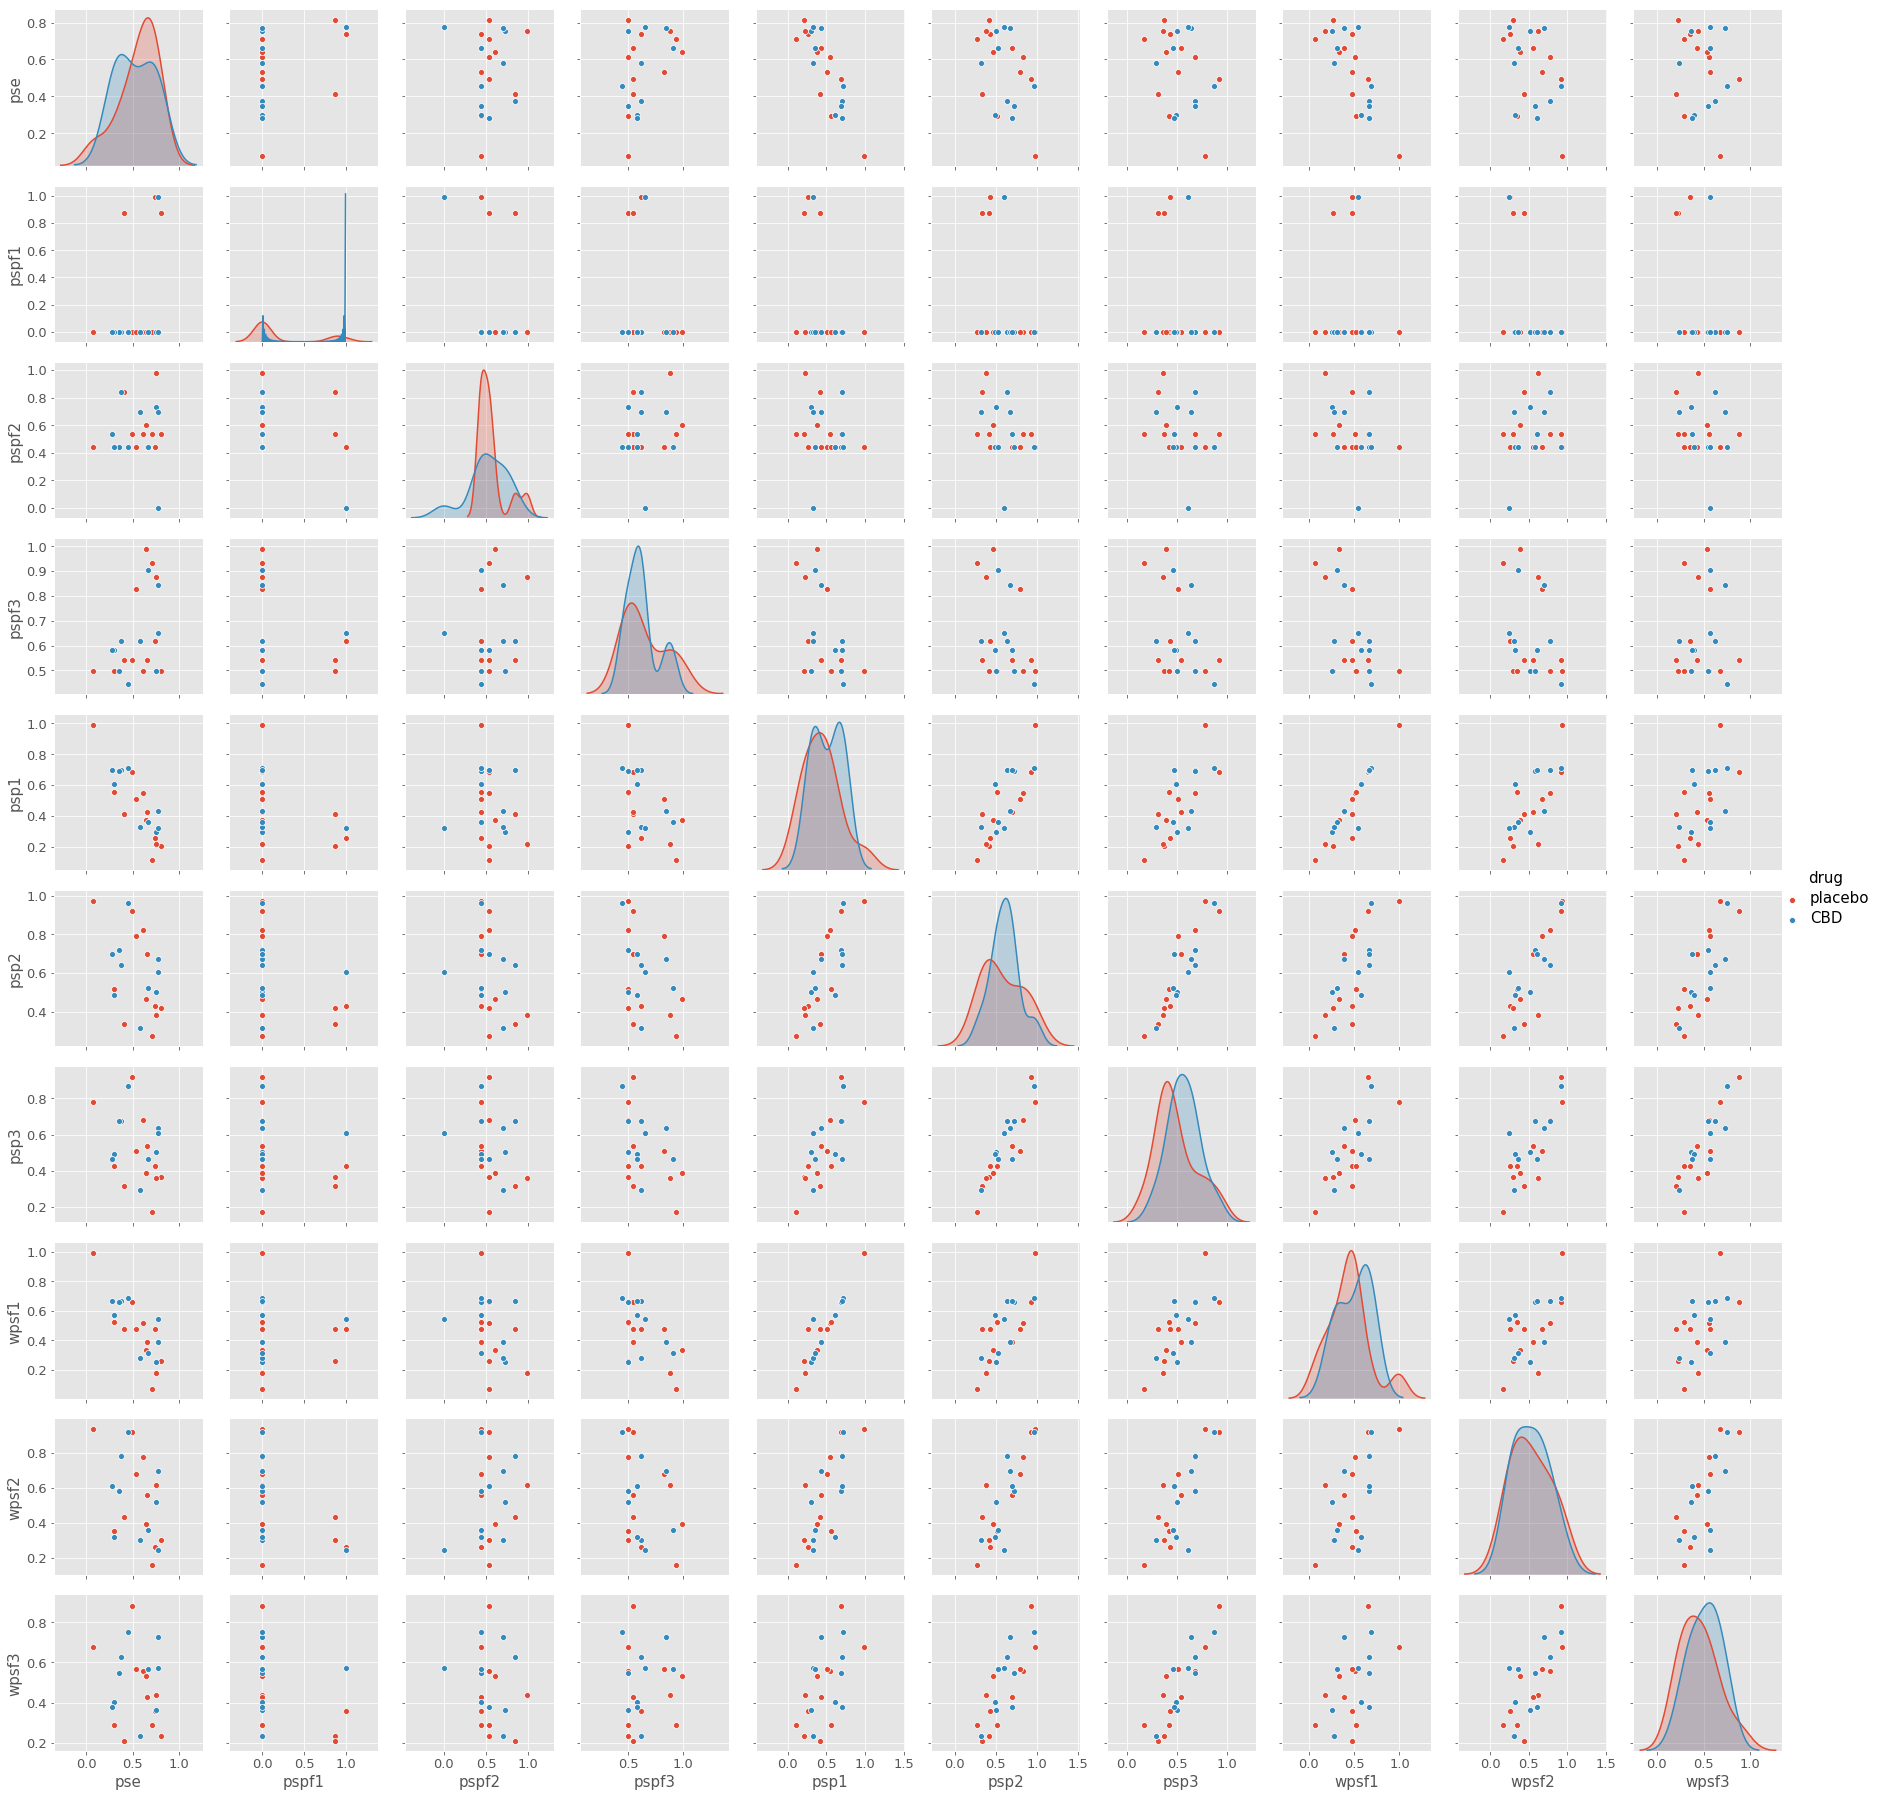

In [38]:
#Pairplot - medida S1
pairplot(df_measureS1,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


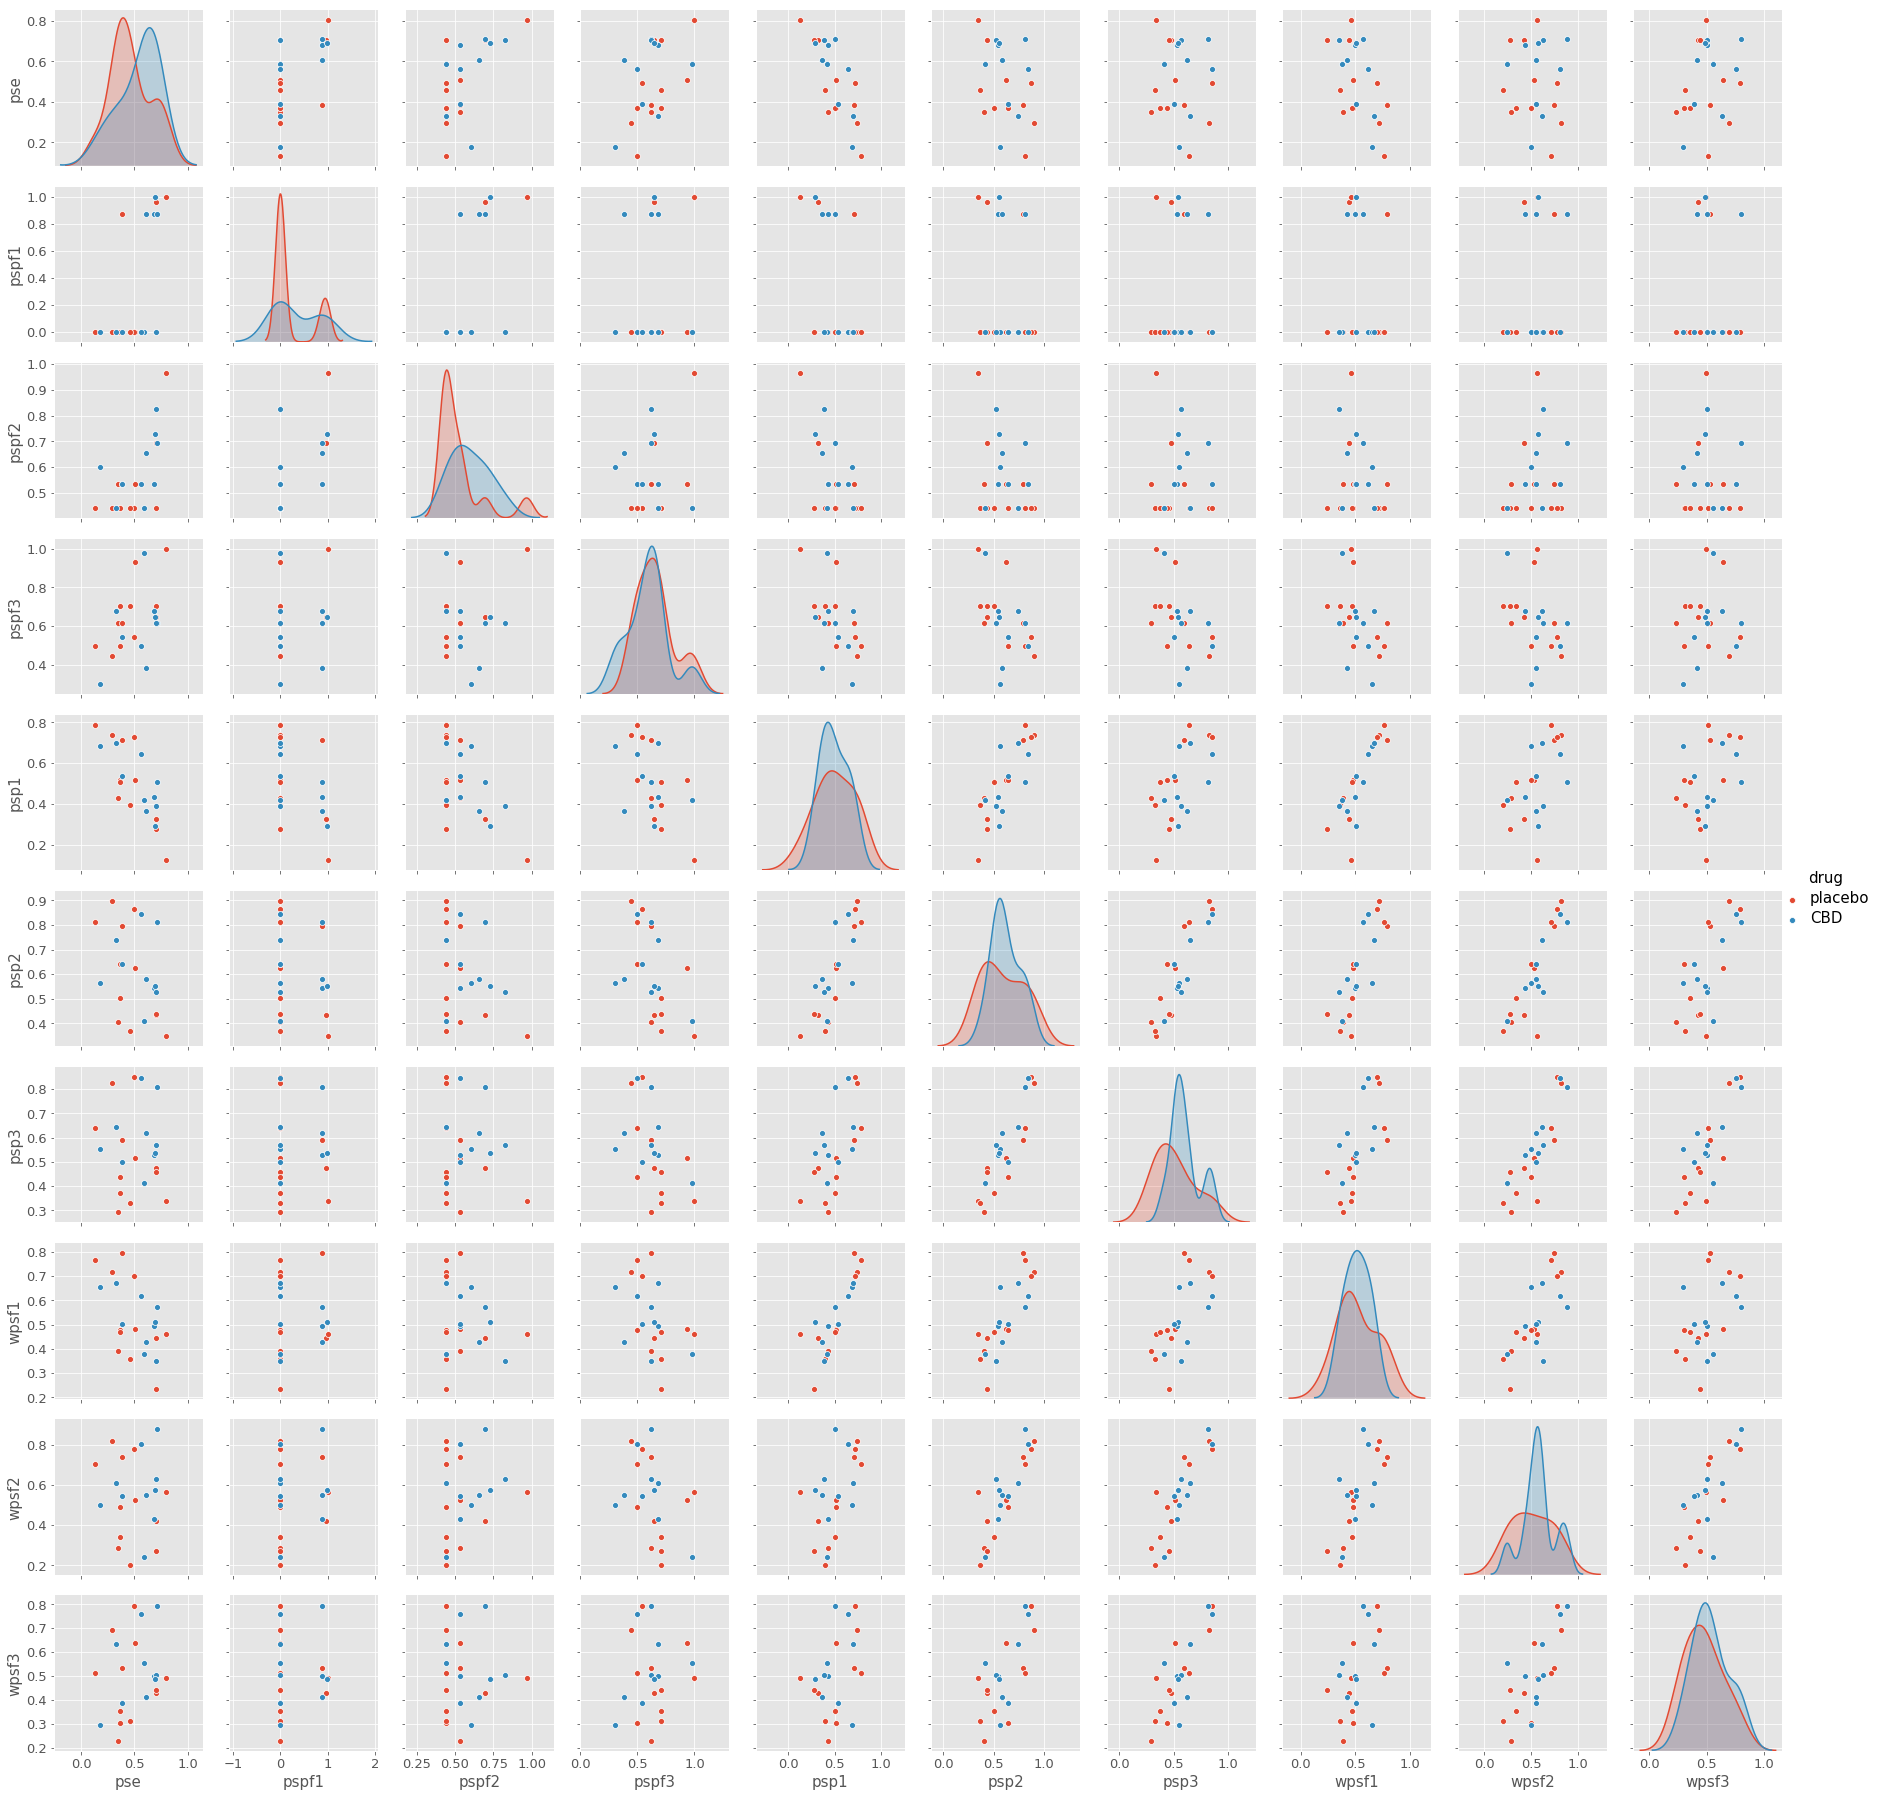

In [39]:
#Pairplot - medida S2
pairplot(df_measureS2,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


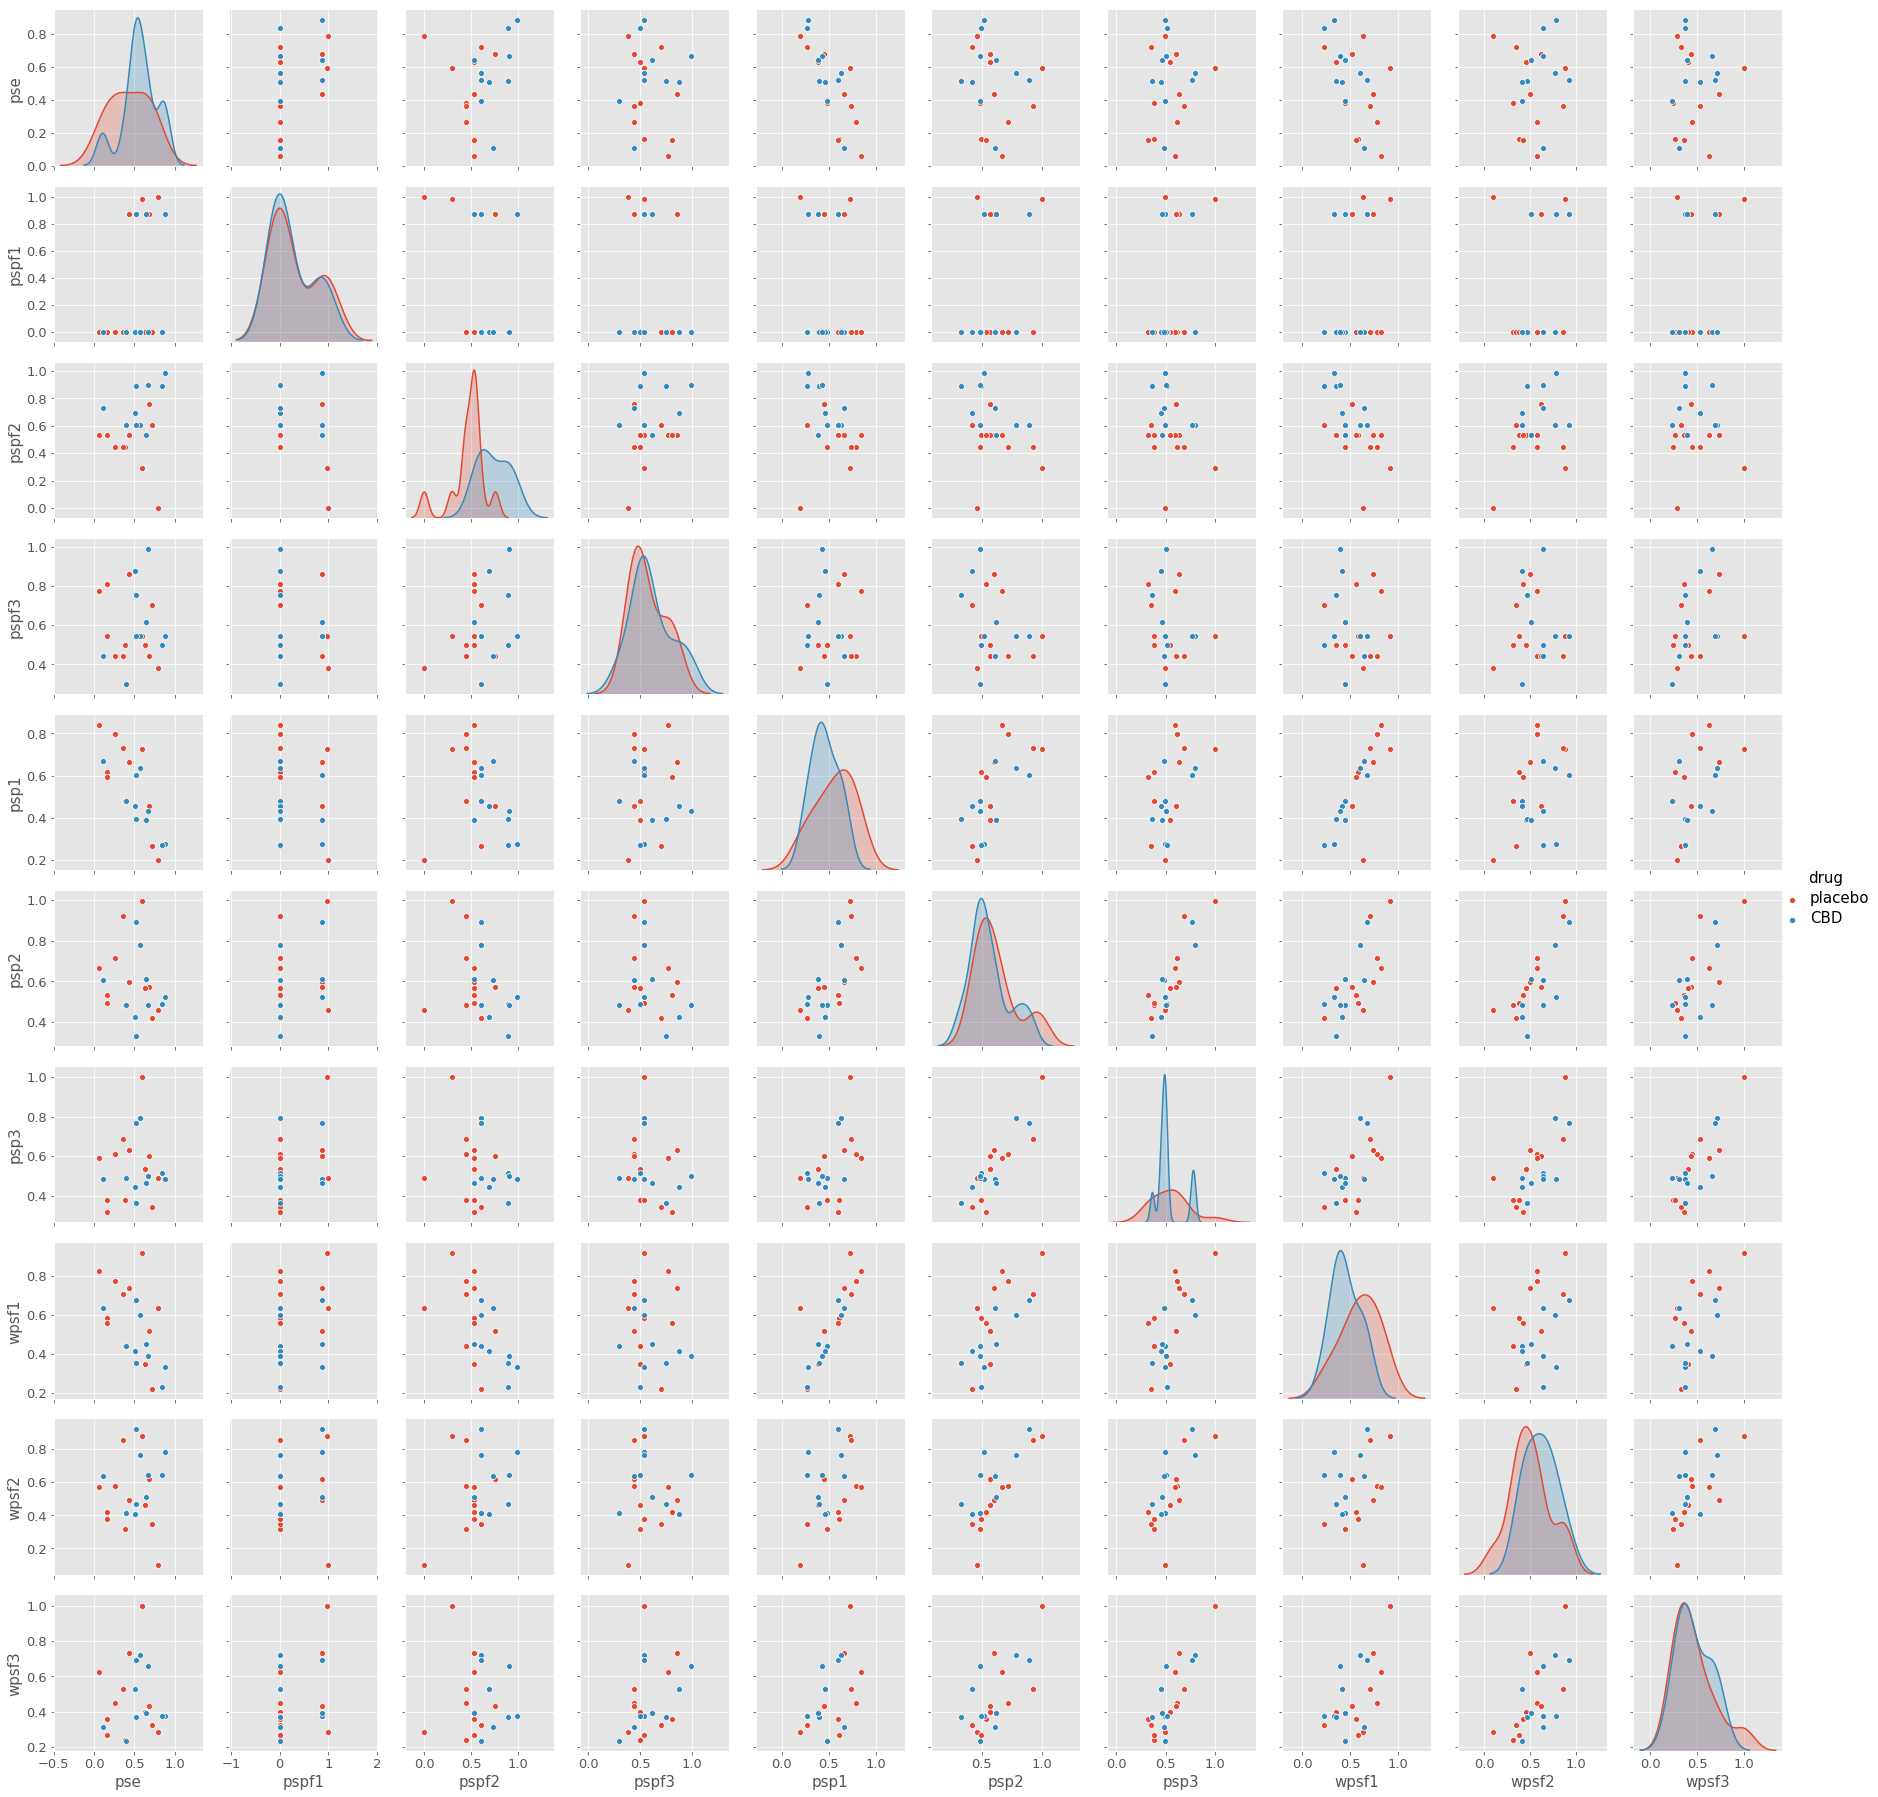

In [40]:
#Pairplot - medida F1
pairplot(df_measureF1,plot_cols,'drug')

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


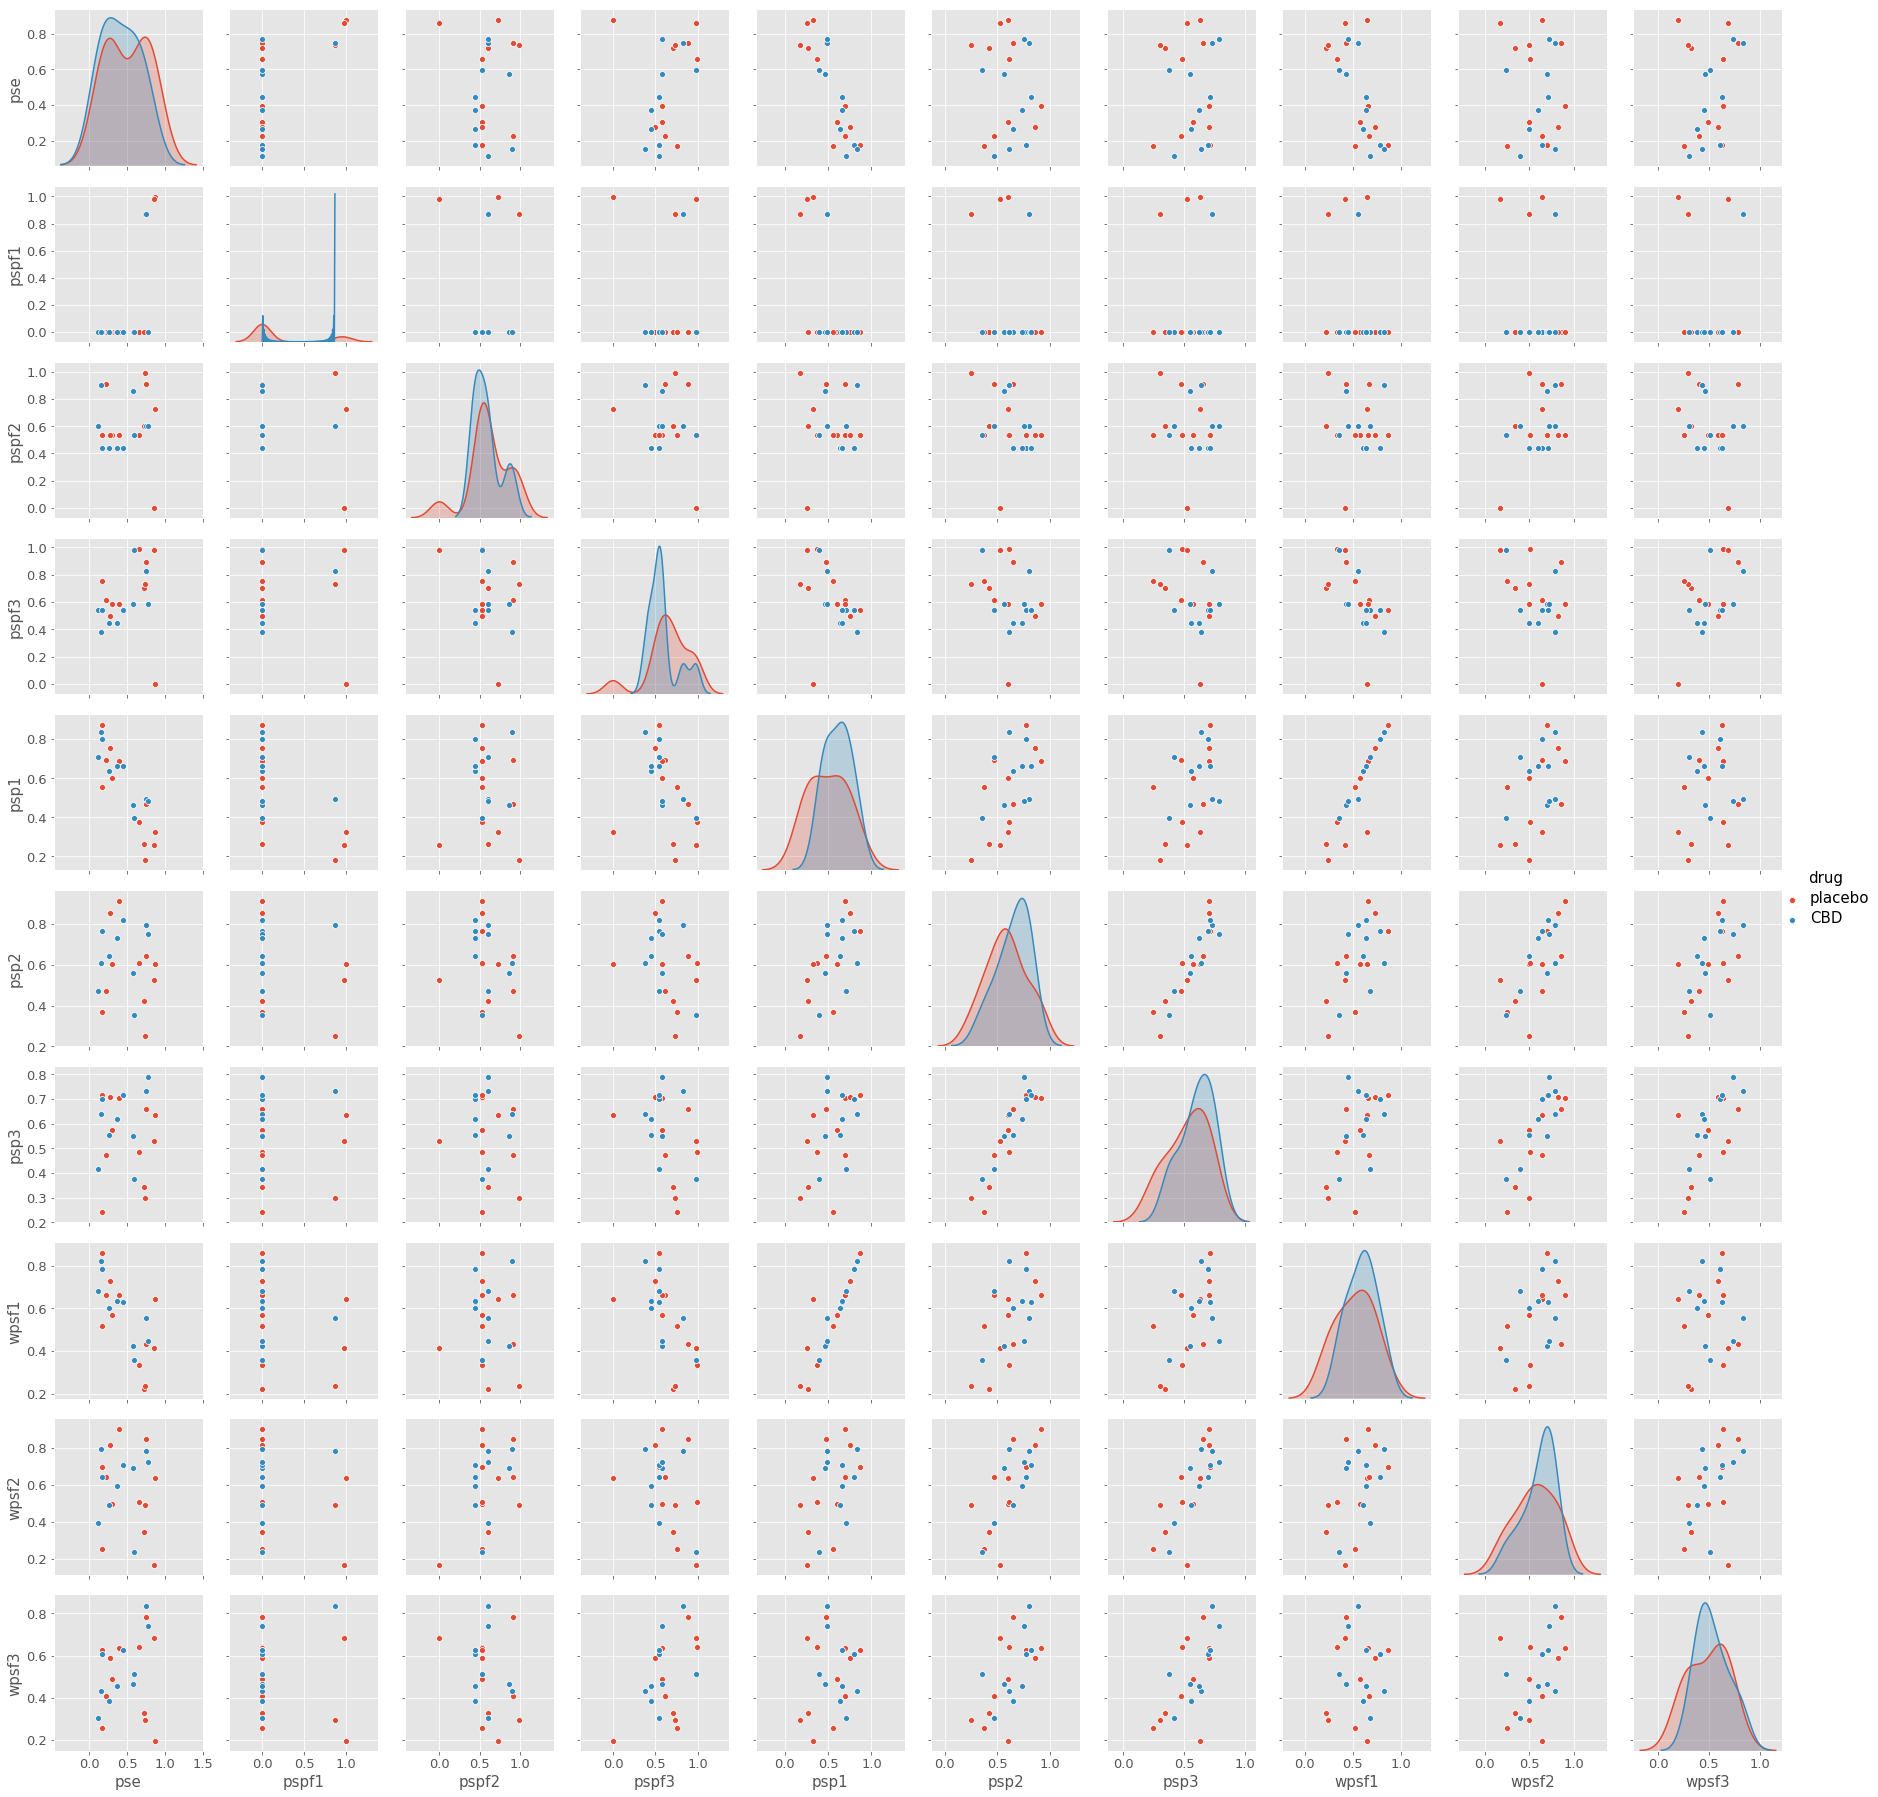

In [41]:
#Pairplot - medida F2
pairplot(df_measureF2,plot_cols,'drug')

Pelos pairplot's verificamos que existem variáveis e medidas que deixam os espaços mais separáveis quanto a droga.

Pode ser interessante avaliar, então, o dataset somente nesses atributos e medidas que sejam mais diferentes entre si.

## 2.5 Dataset features

Iremos analisar as features por pessoa para verificar quais são mais importantes.

In [42]:
#Setando diretorio Data como o atual
os.chdir('../Data')

#Leitura dos dados
df_features = pd.read_csv('features.csv')

#Media 0  e desvio padrao 1
df_features.iloc[:,2:] = StandardScaler().fit_transform(df_features.iloc[:,2:])

/home/sugi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sugi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [43]:
#Criando PCA
pca = PCA().fit(df_features.iloc[:,2:])

In [44]:
#Precisamos de 20 dentre 576 componentes para explicar 98% da variação
pca.explained_variance_ratio_[0:20].sum()

0.9855645893764883

Nós aplicamos o PCA para verificar se teria como explicar a variação com poucos atributos e vemos que isso é possível. 

Essa pode ser uma alternativa a ser tentada.

## 2.6 Resumo das séries temporais

Média e desvio padrão dos dados ao longo do tempo.

In [45]:
#Calcula a média das séries temporais
df_summary_parkinson = df_parkinson.drop(columns=['measure','evaluate']).groupby(['drug','name']).agg(['mean','std']).reset_index()

In [46]:
#Renomeando colunas
list_col = []
for col in df_summary_parkinson.columns:
    list_col.append(col[0]+'_'+col[1])
    
list_col[0] = 'drug'
list_col[1] = 'name'
df_summary_parkinson.columns = list_col

#Colunas numericas
numeric_cols = list_col[2:]

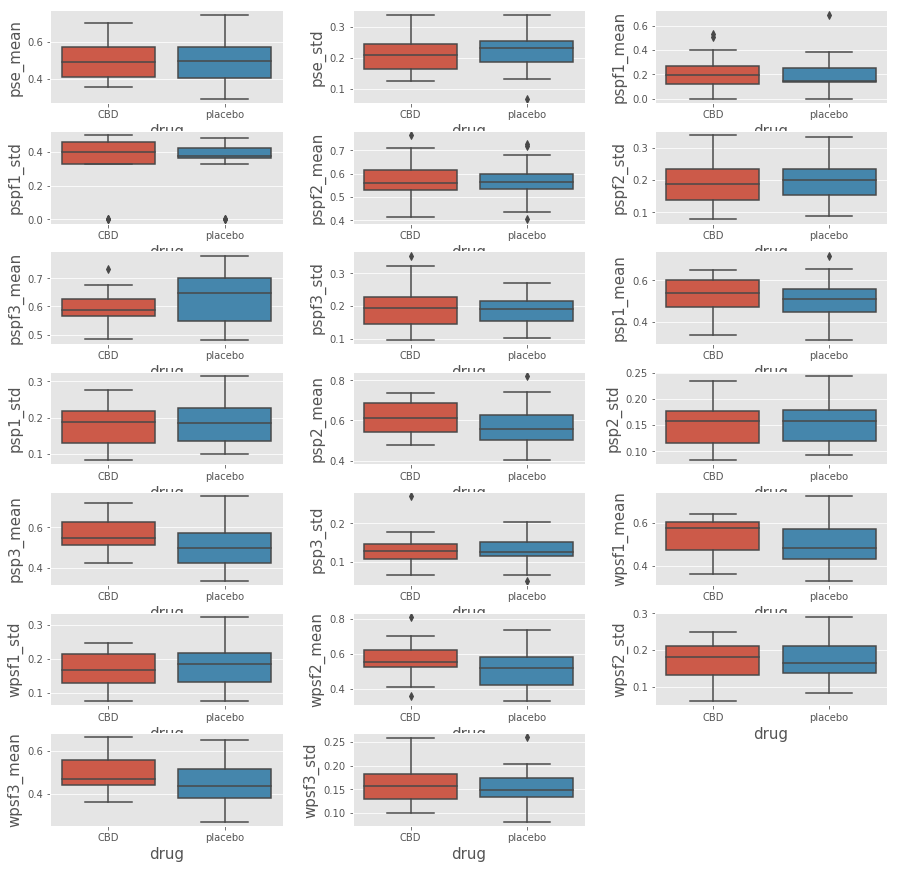

In [47]:
#Boxplot para os atributos com resumo
boxplot(df_summary_parkinson,numeric_cols,'drug')

In [48]:
#ANOVA
_,pvalue = f_oneway(df_summary_parkinson.loc[df_summary_parkinson['drug']=='placebo',numeric_cols],df_summary_parkinson.loc[df_summary_parkinson['drug']=='CBD',numeric_cols])
dict(zip(numeric_cols,pvalue))

{'pse_mean': 0.849181776816376,
 'pse_std': 0.31259975269586576,
 'pspf1_mean': 0.5580242045760901,
 'pspf1_std': 0.7630092901979206,
 'pspf2_mean': 0.7069946412242145,
 'pspf2_std': 0.7546846993022799,
 'pspf3_mean': 0.17230162030448873,
 'pspf3_std': 0.47860876059066637,
 'psp1_mean': 0.24199222087894948,
 'psp1_std': 0.5978319515077335,
 'psp2_mean': 0.11053323679907832,
 'psp2_std': 0.641925433794896,
 'psp3_mean': 0.03785485046885098,
 'psp3_std': 0.9683054902977402,
 'wpsf1_mean': 0.22057298416249985,
 'wpsf1_std': 0.5667751304671422,
 'wpsf2_mean': 0.07802971421296949,
 'wpsf2_std': 0.7590111524319287,
 'wpsf3_mean': 0.1009476103042247,
 'wpsf3_std': 0.9526397335497069}

# 3. Transformação e análise dos dados

Aplicação do PCA para reduzir a dimensionalidade e novas análises dos espaços para selecionar as medidas que são mais interessantes.

## 3.1 PCA

In [49]:
#Variaveis dependentes
X = df_parkinson.select_dtypes('float')

#Criando PCA
pca = PCA(n_components=X.shape[1]).fit(X)

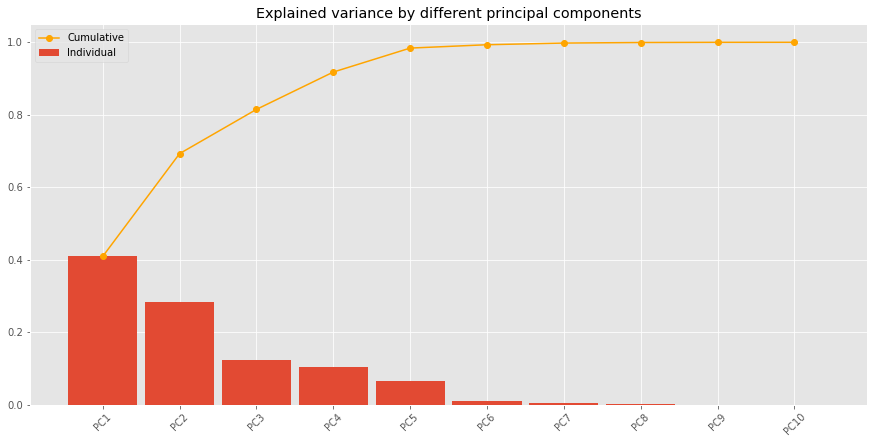

In [50]:
'''Plot da variância explicada do PCA'''
def plot_pca(pca,size):
    #Plot dos 'size' primeiros PC's
    x_list = []
    for i in range(size):
        x_list.append('PC' + str(i+1))

    #Criando figura
    fig,ax = plt.subplots(figsize=(15,7))
    ax.set_title('Explained variance by different principal components')
    ax.bar(height=pca.explained_variance_ratio_[0:size],x=x_list,width=0.9,label='Individual')
    ax.plot(x_list,np.cumsum(pca.explained_variance_ratio_[0:size]),marker='o',color='orange',label='Cumulative')
    
    #Rotaciona xticklabels em 45 graus
    for xtick in ax.get_xticklabels():
        xtick.set_rotation(45)
    
    ax.legend()
    plt.show()
    
plot_pca(pca,X.shape[1])

Vamos utilizar apenas 5 componentes por eles já explicarem praticamente toda a variância.

In [51]:
#5 primeiros PC's
X = pd.DataFrame(pca.transform(X)[:,0:5])
X.columns = ['PC1','PC2','PC3','PC4','PC5']

#Slice
df_parkinson = df_parkinson.select_dtypes(['int','object'])

#Concatenando resultados
df_parkinson = pd.concat([df_parkinson.reset_index(),X],axis=1)
df_parkinson.set_index('name',inplace=True)

#Salvando dados
df_parkinson.to_csv('parkinson_pca.csv',index=True)


## 3.2 Análises dos espaços

Baseados nos outros gráficos iremos plotar os seguintes pairplot's:

- Avaliação 1:
    - Medida P
- Avaliação 2:
    - Medida B
    - Medida A
    - Medida F1

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


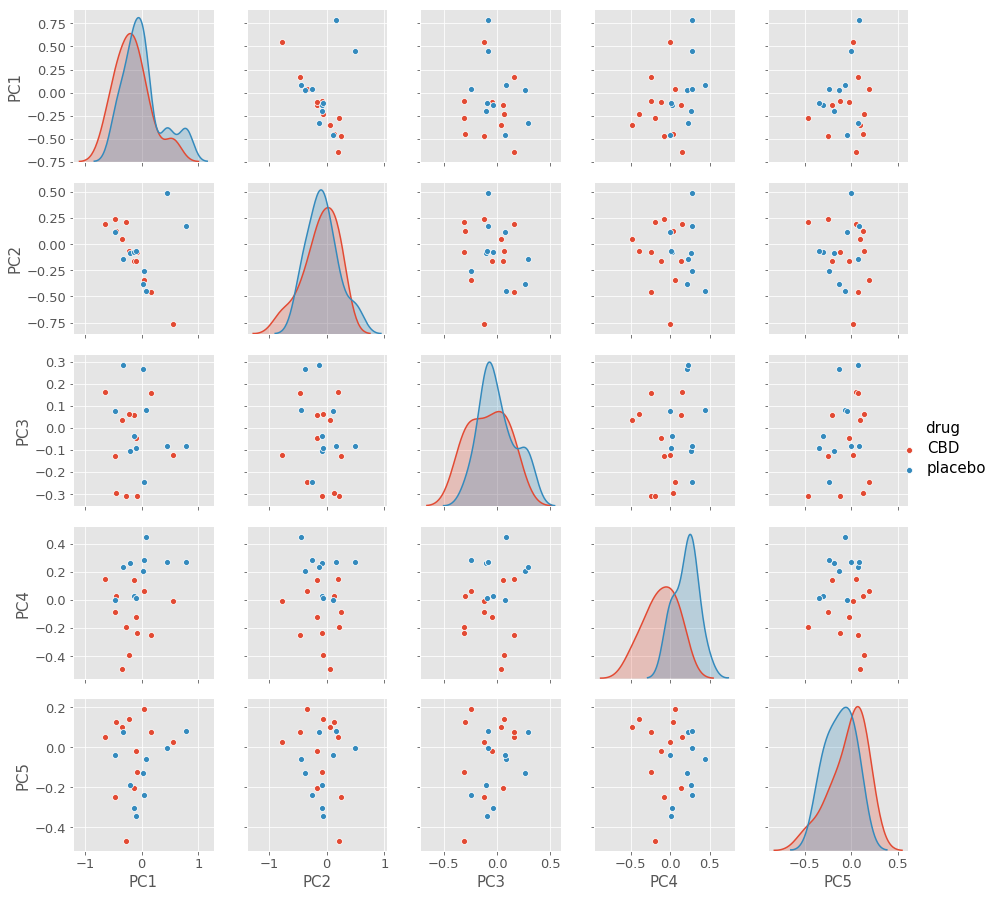

In [52]:
#Condicao para plot
condition = (df_parkinson['measure'] == 'P') & (df_parkinson['evaluate'] == 1)

#Pairplot
pairplot(df_parkinson.loc[condition],['PC1','PC2','PC3','PC4','PC5'],'drug')

PC4 com qualquer outra combinação de PC's aparesenta ser uma boa escolha pelos espaços serem bem separáveis.

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


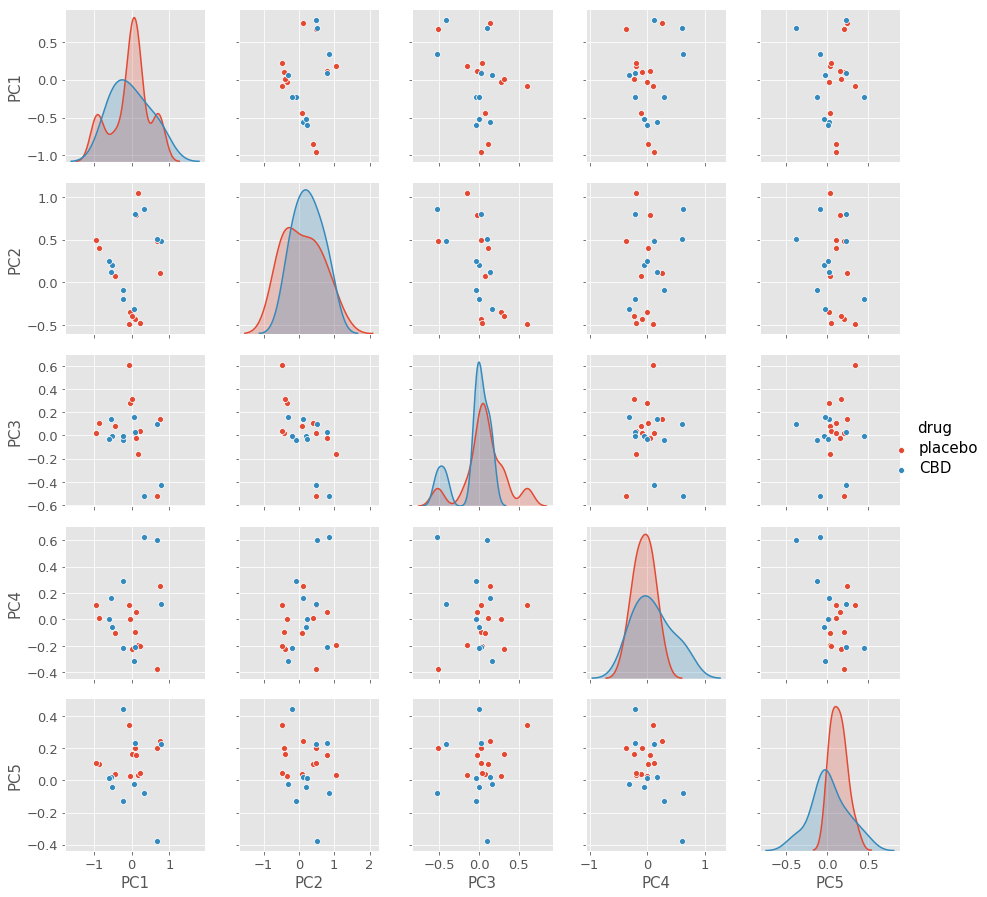

In [53]:
#Condicao para plot
condition = (df_parkinson['measure'] == 'B') & (df_parkinson['evaluate'] == 2)

#Pairplot
pairplot(df_parkinson.loc[condition],['PC1','PC2','PC3','PC4','PC5'],'drug')

A melhor escolha nessa caso será o PC4/PC5 ou PC1/PC5.

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


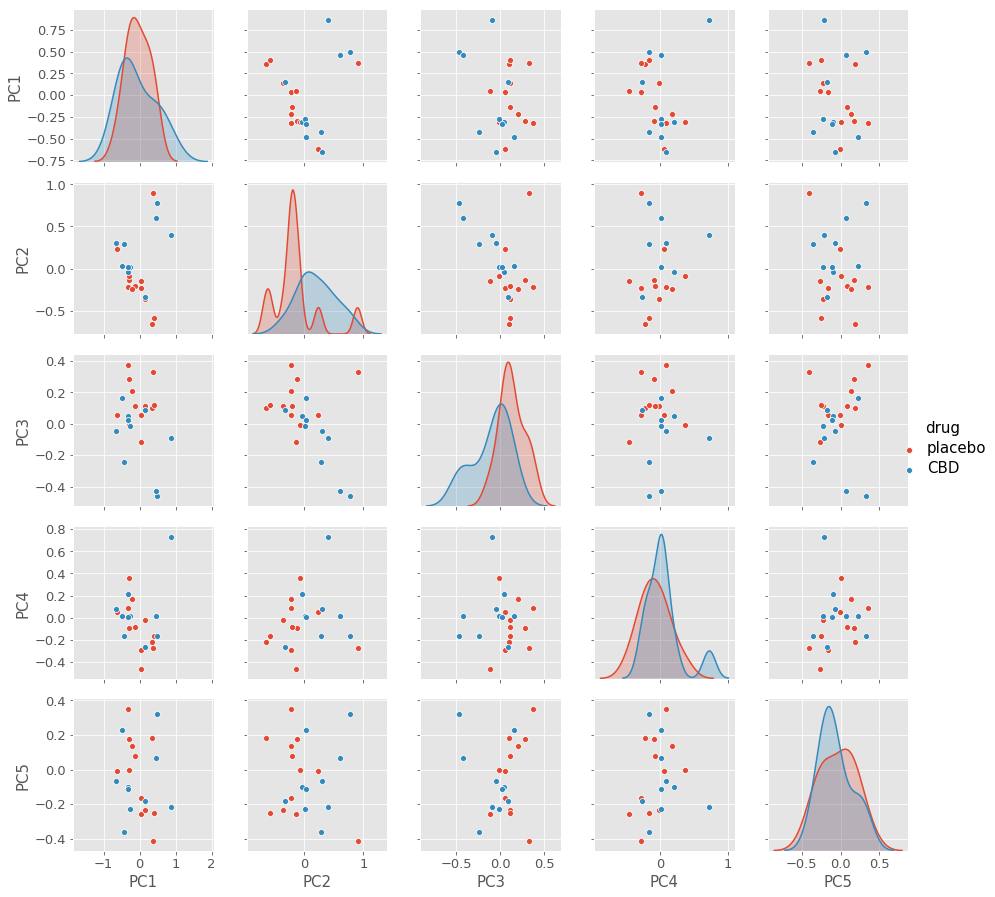

In [54]:
#Condicao para plot
condition = (df_parkinson['measure'] == 'A') & (df_parkinson['evaluate'] == 2)

#Pairplot
pairplot(df_parkinson.loc[condition],['PC1','PC2','PC3','PC4','PC5'],'drug')

A melhor escolha será PC2 com qualquer outro PC.

/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


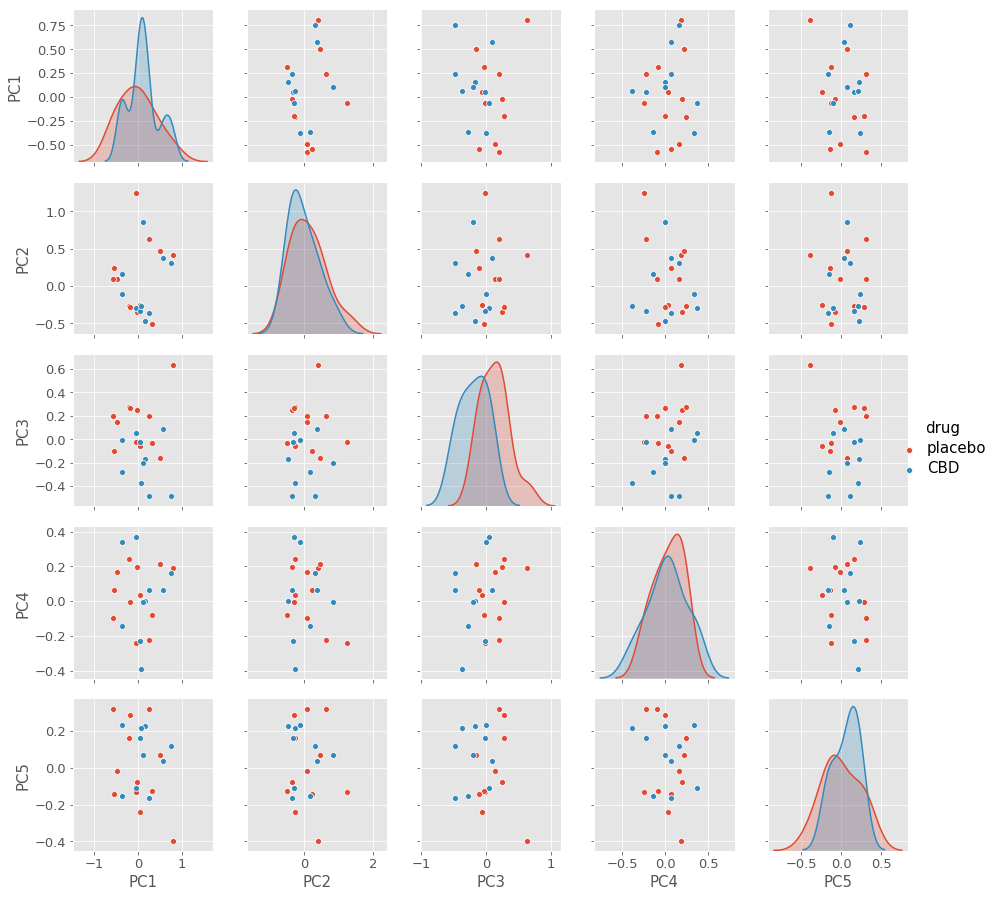

In [55]:
#Condicao para plot
condition = (df_parkinson['measure'] == 'F1') & (df_parkinson['evaluate'] == 2)

#Pairplot
pairplot(df_parkinson.loc[condition],['PC1','PC2','PC3','PC4','PC5'],'drug')

A melhor escolha será PC3 com qualquer outro PC.

# 4. Conclusões

Pelos que vemos nas análises quanto mais realizamos divisões, mais diferentes são as conclusões. Por causa disso seria interessante considerar todas as variáveis categóricas possíveis.

A criação das novas métricas (wpsf2 e wpsf3) podem auxiliar na modelagem por em alguns casos serem relevantes.

O resumo das variáveis ao longo do tempo não parece ser tão interessante por haver certa perca de informação. Caso seja realizado isso, considerar unir algumas medidas (Ex: S1 e S2 vira S) ao invés de unir todas em uma.

Os pairplot's mostram que existe uma grande confundimento no espaço, i.e, em geral as classes estão sobrepostas. Contudo, para algumas variáveis e medidas temos uma melhor separação do espaço.

A aplicação do PCA com seleção de alguns componentes em certas medidas gera espaços bem separáveis.